In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import csv

!pip install torchmetrics
from torchmetrics.regression import PearsonCorrCoef

from sklearn.decomposition import PCA

In [ ]:
packages = !pip freeze
with open('/content/drive/MyDrive/grad_school/thesis/mass_spec/requirements.txt', 'r') as file:


In [ ]:
# import other notebook with function definitions
!pip install import-ipynb
import import_ipynb
# importing functions from other notebook
%cd /content/drive/MyDrive/grad_school/thesis/mass_spec/cleaned_notebooks/
import model_and_function_defs as defs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
/content/drive/MyDrive/grad_school/thesis/mass_spec/cleaned_notebooks
importing Jupyter notebook from model_and_function_defs.ipynb


In [ ]:
# encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_encoder_full_dataset.pth'
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_encoder_915_dataset.pth'
generator_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_generator_batch_training.pth'
spectra = pd.read_csv('/content/drive/MyDrive/grad_school/thesis/mass_spec/data/scaled_spectra_with_instrument_type.csv')
embeddings = pd.read_csv('/content/drive/MyDrive/grad_school/thesis/mass_spec/data/MoNA_embeddings_multiple_instrument_types.csv')

In [ ]:
########### Chem names + instrument encodings as labels

def create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', instrument_idx = 8, batch_size=10, training_chems = None, model = 'encoder', fill_num=100):
  """
  Clean and format data

  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - instrument_idx: (int) Encoded index of instrument to be set aside for testing
  - batch_size: (int) Batch size to use for training
  - training_chems: (list) When training small group models this param can be used to specify which chems to include in the dataset

  Returns:
    Tuple:
    - x_train (pd.DataFrame): Custom dataset for training.
    - train_labels (list): List of labels for the training dataset.
  """

  # separate specified chemical and instrument type for testing
  all_test_chem_columns = [col for col in spectra.columns if test_chem in col]
  # filter out the test instrument type
  test_cols = []
  test_labels = []
  for col in all_test_chem_columns:
    instrument_encoding = list(spectra[col][-12:])
    if instrument_encoding.index(1) == instrument_idx:
      test_cols.append(col)
      label = list(spectra[col][915:])
      test_labels.append(label)

  data = torch.tensor(spectra[test_cols][:915].T.values, dtype=torch.float)
  labels = torch.tensor(test_labels, dtype=torch.float)
  x_test = TensorDataset(data, labels)

  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_labels = []
  for col in train_cols:
    train_labels.append(list(spectra[col][915:]))

  data = torch.tensor(spectra[list(train_cols)][:915].T.values, dtype=torch.float)
  labels = torch.tensor(train_labels, dtype=torch.float)

  for i, spectrum in enumerate(data):
    # fill in fill_num random numbers of the spectrum with 0s
    random_numbers = random.sample(range(915), fill_num)
    for num in random_numbers:
      spectrum[num] = 0

  x_train = TensorDataset(data, labels)

  # currently chem names are numbered (eg. Fenchol.1, Fechol.2, etc)
  # removing those numbers
  train_labels = [label.split('.')[0] for label in train_cols]
  test_labels = [label.split('.')[0] for label in test_cols]

  x_train_dataset = DataLoader(dataset=x_train, batch_size=batch_size, shuffle=True)
  if test_chem == 'None':
    return x_train_dataset, train_labels
  else:
    x_test_dataset = DataLoader(dataset=x_test, batch_size=batch_size, shuffle=True)
    return x_train_dataset, train_labels, x_test_dataset, test_labels

In [ ]:
# def plot_enc_pca(all_embeddings, true_embeddings, output_embeddings, unique_labels, output_labels):
def plot_enc_pca(all_embeddings, output_embeddings, output_labels):
  """
  Run pca on encoder output embeddings and plot results against pca of Chemception embeddings

  Args:
  - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - output_embeddings: (list) Encoder output embeddings.
  - output_labels: (list) Chemical names for each embedding in the encoder's output.
  """

  pca = PCA(n_components=2)
  pca.fit(all_embeddings.T)

  unique_labels = sorted(list(set(output_labels)))
  embeddings_subset = [all_embeddings[chem] for chem in unique_labels]
  # true_transformed = pca.transform(true_embeddings)
  true_transformed = pca.transform(embeddings_subset)

  output_transformed = pca.transform(output_embeddings)

  # colors = [unique_labels.index(chem) for chem in output_labels]
  color_map = {chem: idx for idx, chem in enumerate(unique_labels)}

  # Map labels to colors for both true and output embeddings
  true_colors = [color_map[chem] for chem in unique_labels]
  output_colors = [color_map[chem] for chem in output_labels]
  # print(len(set(output_colors)))

  true_x = [pair[0] for pair in true_transformed]
  true_y = [pair[1] for pair in true_transformed]
  scatter = plt.scatter(true_x, true_y, c=true_colors,
                        cmap='tab20')

  output_x = [pair[0] for pair in output_transformed]
  output_y = [pair[1] for pair in output_transformed]
  plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

  plt.legend(handles=scatter.legend_elements()[0],
              labels=unique_labels,
              loc='upper right',
              prop={'size':7})


  plt.title('Chemception Embeddings PCA vs. Encoder Output PCA')
  plt.xticks([])
  plt.yticks([])

  plt.show()

In [ ]:
# getting a list of all the chemicals in the dataset. Used later
encoder_dataset, encoder_labels = create_dataset(spectra, embeddings, test_chem='None', batch_size=1)
all_chemical_names = sorted(list(set(encoder_labels)))

# Generator Pretraining:
---

In [ ]:
class Encoder(nn.Module):
  def __init__(self, learning_rate):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Linear(915,878),
      nn.LeakyReLU(inplace=True),
      nn.Linear(878,841),
      nn.LeakyReLU(inplace=True),
      nn.Linear(841,804),
      nn.LeakyReLU(inplace=True),
      nn.Linear(804,767),
      nn.LeakyReLU(inplace=True),
      nn.Linear(767, 730),
      nn.LeakyReLU(inplace=True),
      nn.Linear(730, 693),
      nn.LeakyReLU(inplace=True),
      nn.Linear(693, 656),
      nn.LeakyReLU(inplace=True),
      nn.Linear(656, 619),
      nn.LeakyReLU(inplace=True),
      nn.Linear(619, 582),
      nn.LeakyReLU(inplace=True),
      nn.Linear(582, 545),
      nn.LeakyReLU(inplace=True),
      nn.Linear(545, 512),
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, weight_decay=1e-5)
    self.criterion = nn.MSELoss()
    self.epochs = epochs

  def forward(self, x):
    x = self.encoder(x)
    return x

  def train_model(self, dataset, embeddings, sorted_labels):
    # log of loss over epochs
    self.training_loss = []
    model_output = []
    output_labels = []

    for epoch in range(self.epochs):
      # accumulate epoch output and loss
      epoch_training_loss = 0

      for batch, labels in dataset:
        output = self(batch[:915])

        chem_names = [sorted_labels[list(encoding).index(1)] for encoding in labels]
        y_true = torch.Tensor([embeddings[chem_name] for chem_name in chem_names])
        loss = self.criterion(output, y_true)
        epoch_training_loss += loss

        # back propogation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if (epoch + 1) == self.epochs:
          # model_output.append(output)
          for emb, chem_name in zip(output, chem_names):
            output_labels.append(chem_name)
            model_output.append(emb)

      average_loss = epoch_training_loss/len(dataset)
      self.training_loss.append(average_loss)

      if (epoch + 1) % 1 == 0:
        print('Epoch[{}/{}], loss: {}'.format(epoch+1, self.epochs, average_loss))


    return model_output, output_labels


  def test_model(self, test_data, test_labels):
    self.eval()
    test_output = []
    self.test_loss = 0

    with torch.no_grad():
      for spectrum, label in zip(test_data, test_labels):
        output = self(spectrum)
        y_true = torch.tensor(self.embeddings[label])
        loss = self.criterion(output, y_true)

        self.test_loss += loss.item()
        test_output.append(output)

    print(f'Test loss: ', self.test_loss/len(test_data))
    self.test_loss = self.test_loss/len(test_data)
    self.test_output = test_output

    return test_output

In [ ]:
def train_encoder(model, sorted_labels, epochs, batch_size, chem_group_names=None, spectra=spectra, embeddings=embeddings, full_spectra_epochs=0, fill_num=0):
  # log of loss over epochs
  training_loss = []
  model_output = []
  output_labels = []


  for epoch in range(epochs):
    # accumulate epoch output and loss
    epoch_training_loss = 0

    # # for the first full_spectra_epochs epochs, the model gets to see the full spectra. After that it only gets the partial spectra
    # if epoch < full_spectra_epochs:
    #   fill_num = 0
    # else:
    #   fill_num = 100

    # # every 5 epochs, the model gets to see the full spectra. The rest of the time it only gets the partial spectra
    # if epoch % 5 == 0:
    #   fill_num = 0
    # else:
    #   fill_num = 100

    # every 10 epochs increase the number of data points filled with 0s until fill_num = 100. Allows model to learn harder and harder problems
    if fill_num < 50:
      if epoch % 10 == 0:
        fill_num += 5
    elif fill_num < 100:
      if epoch % 15 == 0:
        fill_num += 5

    if chem_group_names:
      x_train, train_labels, _, _ = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', training_chems=chem_group_names, batch_size=batch_size, fill_num=fill_num)
    else:
      x_train, train_labels, _, _ = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', batch_size=batch_size, fill_num=fill_num)

    for batch, labels in x_train:
      output = model(batch)

      chem_names = [sorted_labels[list(encoding).index(1)] for encoding in labels]
      y_true = torch.Tensor([embeddings[chem_name] for chem_name in chem_names])
      loss = model.criterion(output, y_true)
      epoch_training_loss += loss

      # back propogation
      model.optimizer.zero_grad()
      loss.backward()
      model.optimizer.step()

      if (epoch + 1) == epochs:
        for emb, chem_name in zip(output, chem_names):
          output_labels.append(chem_name)
          model_output.append(emb)

    average_loss = epoch_training_loss/len(x_train)
    training_loss.append(average_loss)

    if (epoch + 1) % 5 == 0:
      print('Epoch[{}/{}], loss: {}'.format(epoch+1, epochs, average_loss))


  return model_output, output_labels

In [ ]:
encoder = Encoder(learning_rate=.00001)
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=300, batch_size=100, full_spectra_epochs=10)
## ALREADY TRAINED FOR 200 EPOCHS at lr=.0001 ### - next for 100 at .00001

Epoch[5/300], loss: 0.07626999169588089
Epoch[10/300], loss: 0.07522845268249512
Epoch[15/300], loss: 0.0707915723323822
Epoch[20/300], loss: 0.05411214753985405
Epoch[25/300], loss: 0.04362735524773598
Epoch[30/300], loss: 0.038812149316072464
Epoch[35/300], loss: 0.03696572408080101
Epoch[40/300], loss: 0.03664928302168846
Epoch[45/300], loss: 0.03624453395605087
Epoch[50/300], loss: 0.03626714646816254
Epoch[55/300], loss: 0.03646340221166611
Epoch[60/300], loss: 0.03583082556724548
Epoch[65/300], loss: 0.03618505969643593
Epoch[70/300], loss: 0.03591936454176903
Epoch[75/300], loss: 0.03632194176316261
Epoch[80/300], loss: 0.035787347704172134
Epoch[85/300], loss: 0.035568345338106155
Epoch[90/300], loss: 0.03554859757423401
Epoch[95/300], loss: 0.03596138581633568
Epoch[100/300], loss: 0.03540557622909546
Epoch[105/300], loss: 0.03540210798382759
Epoch[110/300], loss: 0.03521817550063133
Epoch[115/300], loss: 0.03456857055425644
Epoch[120/300], loss: 0.03384644165635109
Epoch[125/

In [ ]:
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_encoder_full_dataset.pth'
encoder = Encoder(learning_rate=.00001)
encoder.load_state_dict(torch.load(encoder_path))
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=1, batch_size=32, fill_num = 100)

In [ ]:
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_partial_spectra.pth'
torch.save(encoder.state_dict(), encoder_path)

encoder = Encoder(learning_rate=.00001)
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_partial_spectra.pth'
encoder.load_state_dict(torch.load(encoder_path))
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=100, batch_size=32, full_spectra_epochs=10, fill_num = 20)

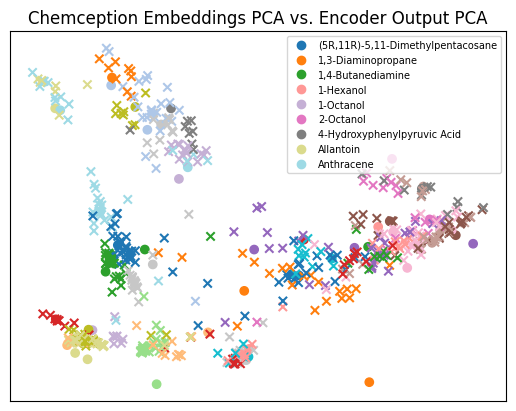

In [ ]:
# With increasingly less data
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

Should probably train this one for a while with fill_num=100 so it has longer to learn that! Right now I think it's only getting up to fill_num=90

In [ ]:
encoder = Encoder(learning_rate=.0001)
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=200, batch_size=100, full_spectra_epochs=10)
## ALREADY TRAINED FOR 200 EPOCHS at lr=.0001 ### - next for 100 at .00001

Epoch[5/200], loss: 0.047435611486434937
Epoch[10/200], loss: 0.035958271473646164
Epoch[15/200], loss: 0.03517092391848564
Epoch[20/200], loss: 0.03475871682167053
Epoch[25/200], loss: 0.03467714414000511
Epoch[30/200], loss: 0.03225397318601608
Epoch[35/200], loss: 0.02647939883172512
Epoch[40/200], loss: 0.02315647155046463
Epoch[45/200], loss: 0.021380892023444176
Epoch[50/200], loss: 0.020563416182994843
Epoch[55/200], loss: 0.01943231374025345
Epoch[60/200], loss: 0.01765846461057663
Epoch[65/200], loss: 0.015881069004535675
Epoch[70/200], loss: 0.015133224427700043
Epoch[75/200], loss: 0.0137016661465168
Epoch[80/200], loss: 0.012403632514178753
Epoch[85/200], loss: 0.011717121116816998
Epoch[90/200], loss: 0.00952209159731865
Epoch[95/200], loss: 0.008295997977256775
Epoch[100/200], loss: 0.007917718030512333
Epoch[105/200], loss: 0.007413792889565229
Epoch[110/200], loss: 0.006803582888096571
Epoch[115/200], loss: 0.0064486912451684475
Epoch[120/200], loss: 0.00589317595586180

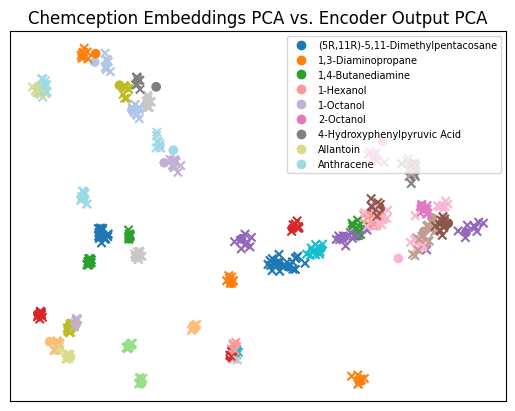

In [ ]:
# With full spectra for all of training
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

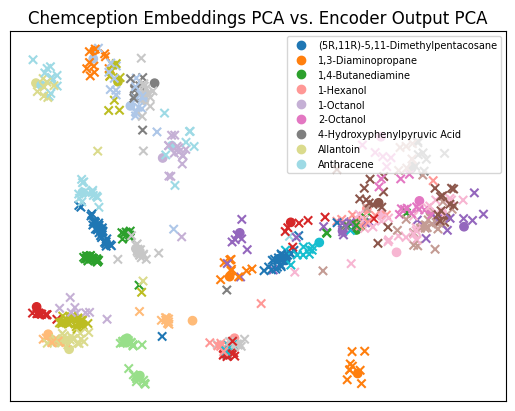

In [ ]:
# With increasingly less data
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

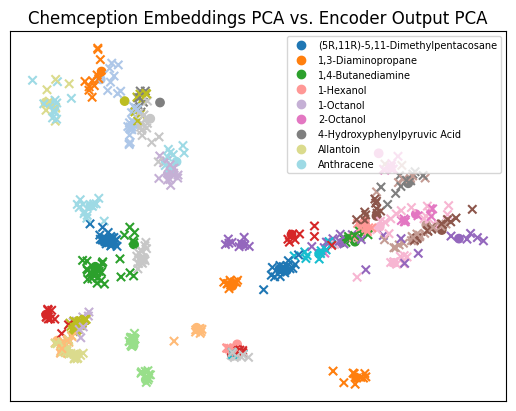

In [ ]:
# With every 5th epoch as real spectra
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

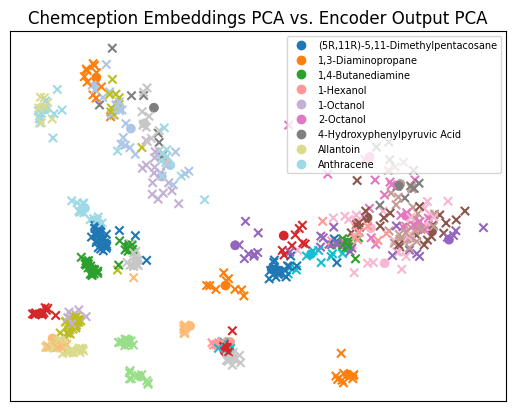

In [ ]:
# With 10 epochs of full spectra first
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

In [ ]:
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_partial_spectra.pth'
torch.save(encoder.state_dict(), encoder_path)

In [ ]:
encoder = Encoder(learning_rate=.00001)
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_partial_spectra.pth'
encoder.load_state_dict(torch.load(encoder_path))
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=100, batch_size=32, full_spectra_epochs=10, fill_num = 20)

Epoch[5/100], loss: 0.000879871950019151
Epoch[10/100], loss: 0.0009586999658495188
Epoch[15/100], loss: 0.0009448037599213421
Epoch[20/100], loss: 0.0010865511139854789
Epoch[25/100], loss: 0.0008636204875074327
Epoch[30/100], loss: 0.0008064167923294008
Epoch[35/100], loss: 0.0008810569997876883
Epoch[40/100], loss: 0.0008859293884597719
Epoch[45/100], loss: 0.0011030978057533503
Epoch[50/100], loss: 0.0009245926048606634
Epoch[55/100], loss: 0.0012569841928780079
Epoch[60/100], loss: 0.0009324924321845174
Epoch[65/100], loss: 0.0010347639909014106
Epoch[70/100], loss: 0.0009683789685368538
Epoch[75/100], loss: 0.0009088997612707317
Epoch[80/100], loss: 0.000934816082008183
Epoch[85/100], loss: 0.0011112161446362734
Epoch[90/100], loss: 0.0007705481839366257
Epoch[95/100], loss: 0.0010058716870844364
Epoch[100/100], loss: 0.0009136336739175022


In [ ]:
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

In [ ]:
encoder = Encoder(learning_rate=.00001)
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_partial_spectra.pth'
encoder.load_state_dict(torch.load(encoder_path))
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs=100, batch_size=32)

Epoch[5/100], loss: 0.0010236608795821667
Epoch[10/100], loss: 0.001009745872579515
Epoch[15/100], loss: 0.0010012834100052714
Epoch[20/100], loss: 0.001131899654865265
Epoch[25/100], loss: 0.0009023145539686084
Epoch[30/100], loss: 0.0008635056437924504
Epoch[35/100], loss: 0.0009519303566776216
Epoch[40/100], loss: 0.0008658752194605768
Epoch[45/100], loss: 0.0007442465866915882
Epoch[50/100], loss: 0.0007968803402036428
Epoch[55/100], loss: 0.0007890573469921947
Epoch[60/100], loss: 0.0007974329055286944
Epoch[65/100], loss: 0.00080695009091869
Epoch[70/100], loss: 0.0007589698652736843
Epoch[75/100], loss: 0.0008499915129505098
Epoch[80/100], loss: 0.0008576340042054653
Epoch[85/100], loss: 0.0007727971533313394
Epoch[90/100], loss: 0.0007190441247075796
Epoch[95/100], loss: 0.0008993026567623019
Epoch[100/100], loss: 0.0006750425673089921


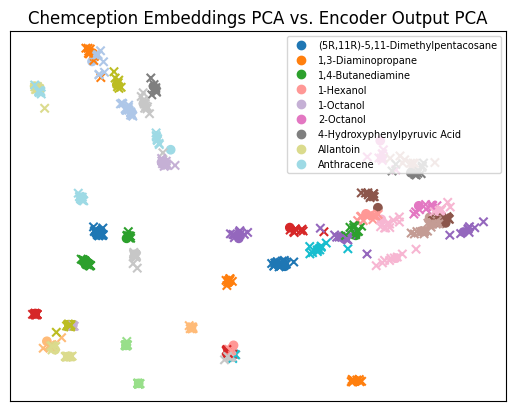

In [ ]:
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

In [ ]:
encoder_dataset, encoder_labels, enc_test_dataset, enc_test_labels = create_dataset(spectra, embeddings, test_chem='Succinic Acid', batch_size=32)
## ALREADY TRAINED FOR 200 EPOCHS at lr=.0001 ###
encoder = Encoder(learning_rate=.00001)
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_encoder_full_dataset.pth'
# encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_encoder_915_dataset.pth'
encoder.load_state_dict(torch.load(encoder_path))
enc_output, output_labels = train_encoder(encoder, encoder_dataset, embeddings, encoder_labels, epochs=100)

Epoch[1/100], loss: 0.00042685907101258636
Epoch[2/100], loss: 0.00039744997047819197
Epoch[3/100], loss: 0.0003818643745034933
Epoch[4/100], loss: 0.00035726200439967215
Epoch[5/100], loss: 0.00035896722692996264
Epoch[6/100], loss: 0.00036020102561451495
Epoch[7/100], loss: 0.00034920673351734877
Epoch[8/100], loss: 0.000349907495547086
Epoch[9/100], loss: 0.0003708606236614287
Epoch[10/100], loss: 0.00034636733471415937
Epoch[11/100], loss: 0.00035062231472693384
Epoch[12/100], loss: 0.0003349485923536122
Epoch[13/100], loss: 0.0003364680742379278
Epoch[14/100], loss: 0.0003404823655728251
Epoch[15/100], loss: 0.00033410347532480955
Epoch[16/100], loss: 0.0003279999946244061
Epoch[17/100], loss: 0.0003378484689164907
Epoch[18/100], loss: 0.00033834672649390996
Epoch[19/100], loss: 0.0003559043107088655
Epoch[20/100], loss: 0.00035665687755681574
Epoch[21/100], loss: 0.0003359709517098963
Epoch[22/100], loss: 0.00033309837453998625
Epoch[23/100], loss: 0.0003317179798614234
Epoch[24/

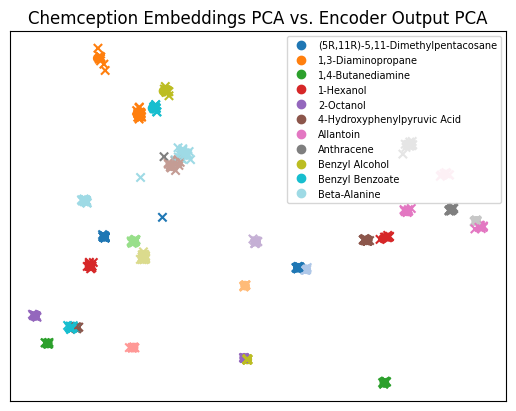

In [ ]:
plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)

In [ ]:
# encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_encoder_full_dataset.pth'
# torch.save(encoder.state_dict(), encoder_path)

In [ ]:
class BasePeakScaler(nn.Module):
    ''' Custom layer to scale spectra so that base peak = 100 '''
    def __init__(self):
      super().__init__()

    def forward(self, x):
      # max_val = max(x)
      # scaled_spec = (x/max_val)*100
      print(x.grad)
      max_values, _ = torch.max(x, dim=1, keepdim=True)
      print(x.grad)
      scaled_spectra = (x / max_values) * 100
      return scaled_spectra

In [ ]:
class Generator(nn.Module):
  def __init__(self, learning_rate, step_size=None, gamma=0.1):
    super().__init__()

    self.generator = nn.Sequential(
      nn.Linear(524, 573),
      nn.LeakyReLU(inplace=True),
      nn.Linear(573, 611),
      nn.LeakyReLU(inplace=True),
      nn.Linear(611, 649),
      nn.LeakyReLU(inplace=True),
      nn.Linear(649, 687),
      nn.LeakyReLU(inplace=True),
      nn.Linear(687, 725),
      nn.LeakyReLU(inplace=True),
      nn.Linear(725, 763),
      nn.LeakyReLU(inplace=True),
      nn.Linear(763, 801),
      nn.LeakyReLU(inplace=True),
      nn.Linear(801, 839),
      nn.LeakyReLU(inplace=True),
      nn.Linear(839, 877),
      nn.LeakyReLU(inplace=True),
      nn.Linear(877, 915)
    )

    # self.base_peak_scaler = BasePeakScaler()

    self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
    if step_size:
      self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.generator(x)
    # print(x.grad)
    # x = self.base_peak_scaler(x)
    return x

  def update_learning_rate(self, new_lr):
    for param_group in self.optimizer.param_groups:
      param_group['lr'] = new_lr

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, data):
#       values = data.values
#       self.data = torch.tensor(values, dtype=torch.float32, requires_grad=True)

#     def __len__(self):
#       return len(self.data)

#     def __getitem__(self, idx):
#       features = self.data[idx]
#       return features

In [ ]:
# def train_generator(generator, encoder, x_train, epochs, chem_group_names, batch_size, spectra=spectra, embeddings=embeddings, learning_rate=None, reduce_learning_rate_frequency=None):
def train_generator(generator, encoder, epochs, chem_group_names, batch_size, spectra=spectra, embeddings=embeddings, learning_rate=None, reduce_learning_rate_frequency=None):
  real_spectra = []
  output_spectra = []
  labels = []
  instruments = []
  train_embeddings = []
  training_loss = []

  for epoch in range(epochs):
    x_train, train_labels, _, _ = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', training_chems=chem_group_names, batch_size=batch_size)
    model_output = []
    epoch_training_loss = 0
    epoch_pearson_coeff = 0

    for batch, encodings in x_train:
      instrument_encodings = []
      label_encodings = []

      for encoding in encodings:
        instrument_encodings.append(list(encoding[-12:]))
        label_encodings.append(encoding[:-12])

      encoder_output = encoder(batch)
      embeddings_with_conditions = []

      for instrument, embedding in zip(instrument_encodings, encoder_output):
        emb_w_conditions = torch.cat((torch.Tensor(embedding).detach(), torch.Tensor(instrument)))
        embeddings_with_conditions.append(list(emb_w_conditions))

      embeddings_with_conditions = torch.tensor(embeddings_with_conditions, dtype=torch.float)
      instrument_encodings = torch.tensor(instrument_encodings, dtype=torch.float)
      full_batch = TensorDataset(torch.Tensor(embeddings_with_conditions), instrument_encodings)
      full_batch = DataLoader(dataset=full_batch, batch_size=batch_size)

      for data, _ in full_batch:
        output = generator(data.detach())

      mse = generator.criterion(output, batch)
      epoch_training_loss += mse
      loss = mse

      # back propogation
      generator.optimizer.zero_grad()
      loss.backward()
      generator.optimizer.step()

      average_loss = epoch_training_loss/len(x_train)
      training_loss.append(average_loss)

      if epoch+1 == epochs:
        for fake_spec, real_spec in zip(output, batch):
          max_val = max(fake_spec)
          scaled_spec = (fake_spec/max_val)*100
          output_spectra.append(scaled_spec)
          real_spectra.append(real_spec)
        for embedding in encoder_output:
          train_embeddings.append(embedding.detach().numpy())
        for label, instrument in zip(label_encodings, instrument_encodings):
          labels.append(label)
          instruments.append(instrument)

    # if (epoch+1) % 10 == 0:
    #   for param_group in generator.optimizer.param_groups:
    #     print(param_group['lr'])

    if (epoch + 1) % 5 == 0:
      print('Epoch[{}/{}]'.format(epoch+1, epochs))
      print('Epoch {} Average MSE: {:.6f}'.format(epoch+1, average_loss))
      print('-----------------------------------------------------------------')

    if reduce_learning_rate_frequency:
      # reduce learning rate every n epochs
      if (epoch+1) % reduce_learning_rate_frequency == 0:
        learning_rate = learning_rate * .1
        generator.update_learning_rate(learning_rate)
        print('REDUCING LEARNING RATE TO: ', learning_rate)

  return real_spectra, output_spectra, train_embeddings, labels, instruments

In [ ]:
# -------------------------------------------------------------------
# pre-training for generator on entire dataset to avoid mode collapse
# -------------------------------------------------------------------
batch_size = 32
x_train, train_labels, x_test, test_labels = create_dataset(spectra, embeddings, batch_size=batch_size)

epochs = 1
learning_rate = .001

generator = Generator(learning_rate)#, step_size=10)

# load pre-trained encoder
encoder = Encoder(learning_rate)
encoder.load_state_dict(torch.load(encoder_path))

real_spectra, output_spectra, train_embeddings, labels = train_generator(generator, encoder, x_train, epochs)#, learning_rate=learning_rate, reduce_learning_rate_frequency=50)
# real_spectra, output_spectra, train_embeddings, labels = train_generator(generator, encoder, encoder_dataset, epochs)

In [ ]:
# generator_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_generator_batch_training.pth'
# generator_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_generator_scaling.pth'
# torch.save(generator.state_dict(), generator_path)

# Group Generator Training:
---

In [ ]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [ ]:
from scipy.stats import pearsonr
def plot_results(real_spectra, fake_spectra, labels, instruments, idx=[0,10], window=300, cutoff = .5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:
      # if labels[i] not in ['Glutaric Acid']:#, 'Biphenyl']:
      if labels[i] == 'Biphenyl':
        idx[1] += 1
        continue
      # window = len(real_spec)
      # # finding the highest nonzero index in the real spec and the highest index above .1 in the fake spec.
      # # the fake spec has a decent amount of tiny noise so filtering out tiny values helps show the results
      # real_highest_nonzero = max([i for i, x in enumerate(real_spec) if x != 0])
      # fake_highest_nonzero = max([i for i, x in enumerate(fake_spec) if x >= .1])
      # window = max(real_highest_nonzero, fake_highest_nonzero)

      numbers = range(0,window)
      # input_frequencies = real_spec[0].detach().numpy()
      input_frequencies = real_spec.detach().numpy()

      """
      reconstructions have lots of very small and inaccurate predictions.
      since most correct values are above .5, setting all values below .5 to
      0 corrects some of the inaccuracies with minimal disruption
      """
      out_clone = fake_spec.clone().detach().numpy()
      out_frequencies = [0 if num < cutoff else num for num in out_clone]

      # r, _ = pearsonr(input_frequencies, out_clone)
      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      fake_base = list(fake_spec).index(max(fake_spec))

      if instruments[i] == 'EI-B' or instruments[i] == 'GC-EI-TOF':
        instrument = instruments[i]
      else:
        # we don't want to plot instruments other than the ones above but we still want the same number of plots
        # instrument='Other'
        idx[1] += 1
        continue

      fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, input_frequencies[:window])
      ax[0].set_title(f'Real {labels[i]} {instrument} Spectrum.', fontsize=18)
      # ax[0].set_title(f'Real {labels[i]} {instrument} Spectrum. Base at {real_base}', fontsize=16)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} {instrument} Spectrum. {round(float(weighted_cosine_similarity), 3)}', fontsize=18)
      # ax[1].set_title(f'Synthetic {labels[i]} {instrument} Spectrum. Base at {fake_base}', fontsize=16)
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [ ]:
# def training_part_two(continue_training_enc):
def training_part_two(continue_training_enc, encoder, x_train, chem_group_names, batch_size, spectra=spectra, embeddings=embeddings, all_chem_names=all_chemical_names):
  if continue_training_enc == 'n':
    if input('Train generator? y/n: ') == 'y':
      gen_epochs = int(input('How many epochs? '))

      print('----------------- Encoder Training Complete. Training Generator: -----------------')

      gen_lr = .001
      # load pre-trained generator
      generator = Generator(gen_lr)
      generator_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_generator_batch_training.pth'
      # generator.load_state_dict(torch.load(generator_path))

      # real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings = train_generator(generator, encoder, x_train, gen_epochs)
      real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings = train_generator(generator, encoder, gen_epochs, chem_group_names, batch_size)

      if input('Continue training generator? y/n: ') == 'n':
        return generator, real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings

      else:
        temp_generator_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/small_group_generator_temporary.pth'
        torch.save(generator.state_dict(), temp_generator_path)

        gen_epochs = int(input('How many epochs? '))
        lr = float(input('Learning rate? '))

        # load pre-trained generator
        generator = Generator(lr)
        generator.load_state_dict(torch.load(temp_generator_path))

        # real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings = train_generator(generator, encoder, x_train, gen_epochs)
        real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings = train_generator(generator, encoder, gen_epochs, chem_group_names, batch_size)

        return generator, real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings

    else:
      print('----------------- Encoder Training Complete. -----------------')
      return 'None', 'None', 'None', 'None', 'None', 'None'


  else:
    if input('New training set? y/n: ') == 'y':
      chem_group_names = input('Chemical names? ')
      batch_size = 32
      x_train, train_labels, x_test, test_labels = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', training_chems=chem_group_names, batch_size=batch_size)
    enc_epochs = int(input('How many epochs? '))
    lr = float(input('Learning rate? '))

    temp_enc_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/small_group_encoder_temporary.pth'
    torch.save(encoder.state_dict(), temp_enc_path)

    encoder = Encoder(lr)
    encoder.load_state_dict(torch.load(temp_enc_path))

    enc_output, output_labels = train_encoder(encoder, x_train, embeddings, all_chemical_names, epochs=enc_epochs)

    plotting_output = [emb.detach().numpy() for emb in enc_output]
    plot_enc_pca(embeddings, plotting_output, output_labels)

    continue_training_enc = input('Continue training encoder? y/n: ')

    # training_part_two(continue_training_enc, encoder, x_train)
    training_part_two(continue_training_enc, encoder, x_train, chem_group_names, batch_size)

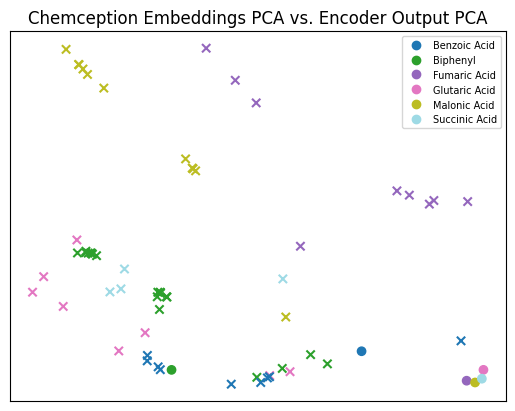

Continue training encoder? y/n: n
Train generator? y/n: y
How many epochs? 1
----------------- Encoder Training Complete. Training Generator: -----------------
Continue training generator? y/n: y
How many epochs? 1
Learning rate? .1


In [ ]:
initial_training = ['Succinic Acid']
chem_group_names = ['Glutaric Acid', 'Fumaric Acid', 'Malonic Acid', 'Succinic Acid', 'Benzoic Acid', 'Biphenyl']

batch_size = 32
x_train, train_labels, x_test, test_labels = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', training_chems=chem_group_names, batch_size=batch_size)

epochs = 1
enc_lr = .0001

# load pre-trained encoder
encoder = Encoder(enc_lr)
encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/batch_universal_encoder_full_dataset.pth'
# encoder_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/universal_encoder_915_dataset.pth'
# temp_enc_path = '/content/drive/MyDrive/grad_school/thesis/mass_spec/models/small_group_encoder_temporary.pth'
encoder.load_state_dict(torch.load(encoder_path))
# enc_output, output_labels = train_encoder(encoder, x_train, embeddings, all_chemical_names, epochs=epochs)
enc_output, output_labels = train_encoder(encoder, all_chemical_names, epochs, chem_group_names, batch_size)

plotting_output = [emb.detach().numpy() for emb in enc_output]
plot_enc_pca(embeddings, plotting_output, output_labels)
continue_training_enc = input('Continue training encoder? y/n: ')

# generator, real_spectra,
# output_spectra, train_embeddings, label_encodings, instrument_encodings = training_part_two(continue_training_enc, encoder, x_train)
generator, real_spectra, output_spectra, train_embeddings, label_encodings, instrument_encodings = training_part_two(continue_training_enc, encoder, x_train, chem_group_names, batch_size)

# Best results so far from training gen for 100 epochs @ .001 and 50 epochs @ .0001

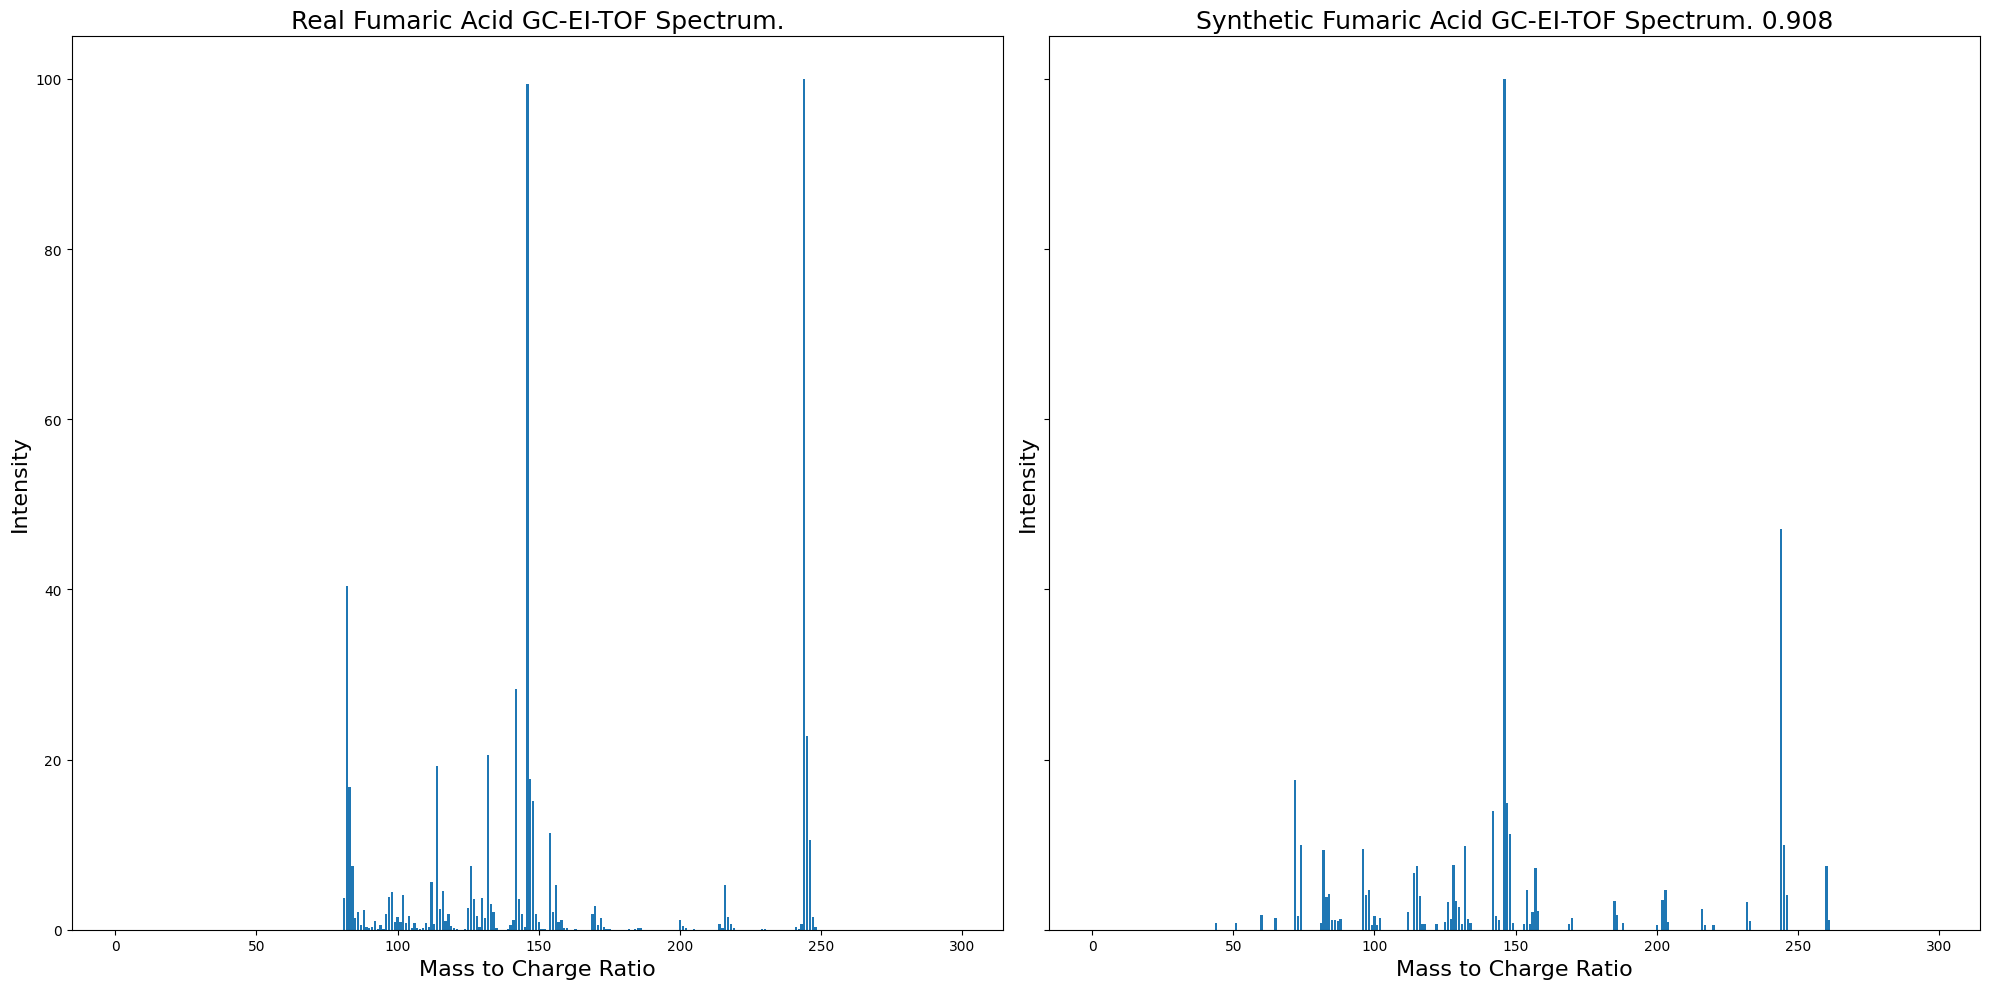

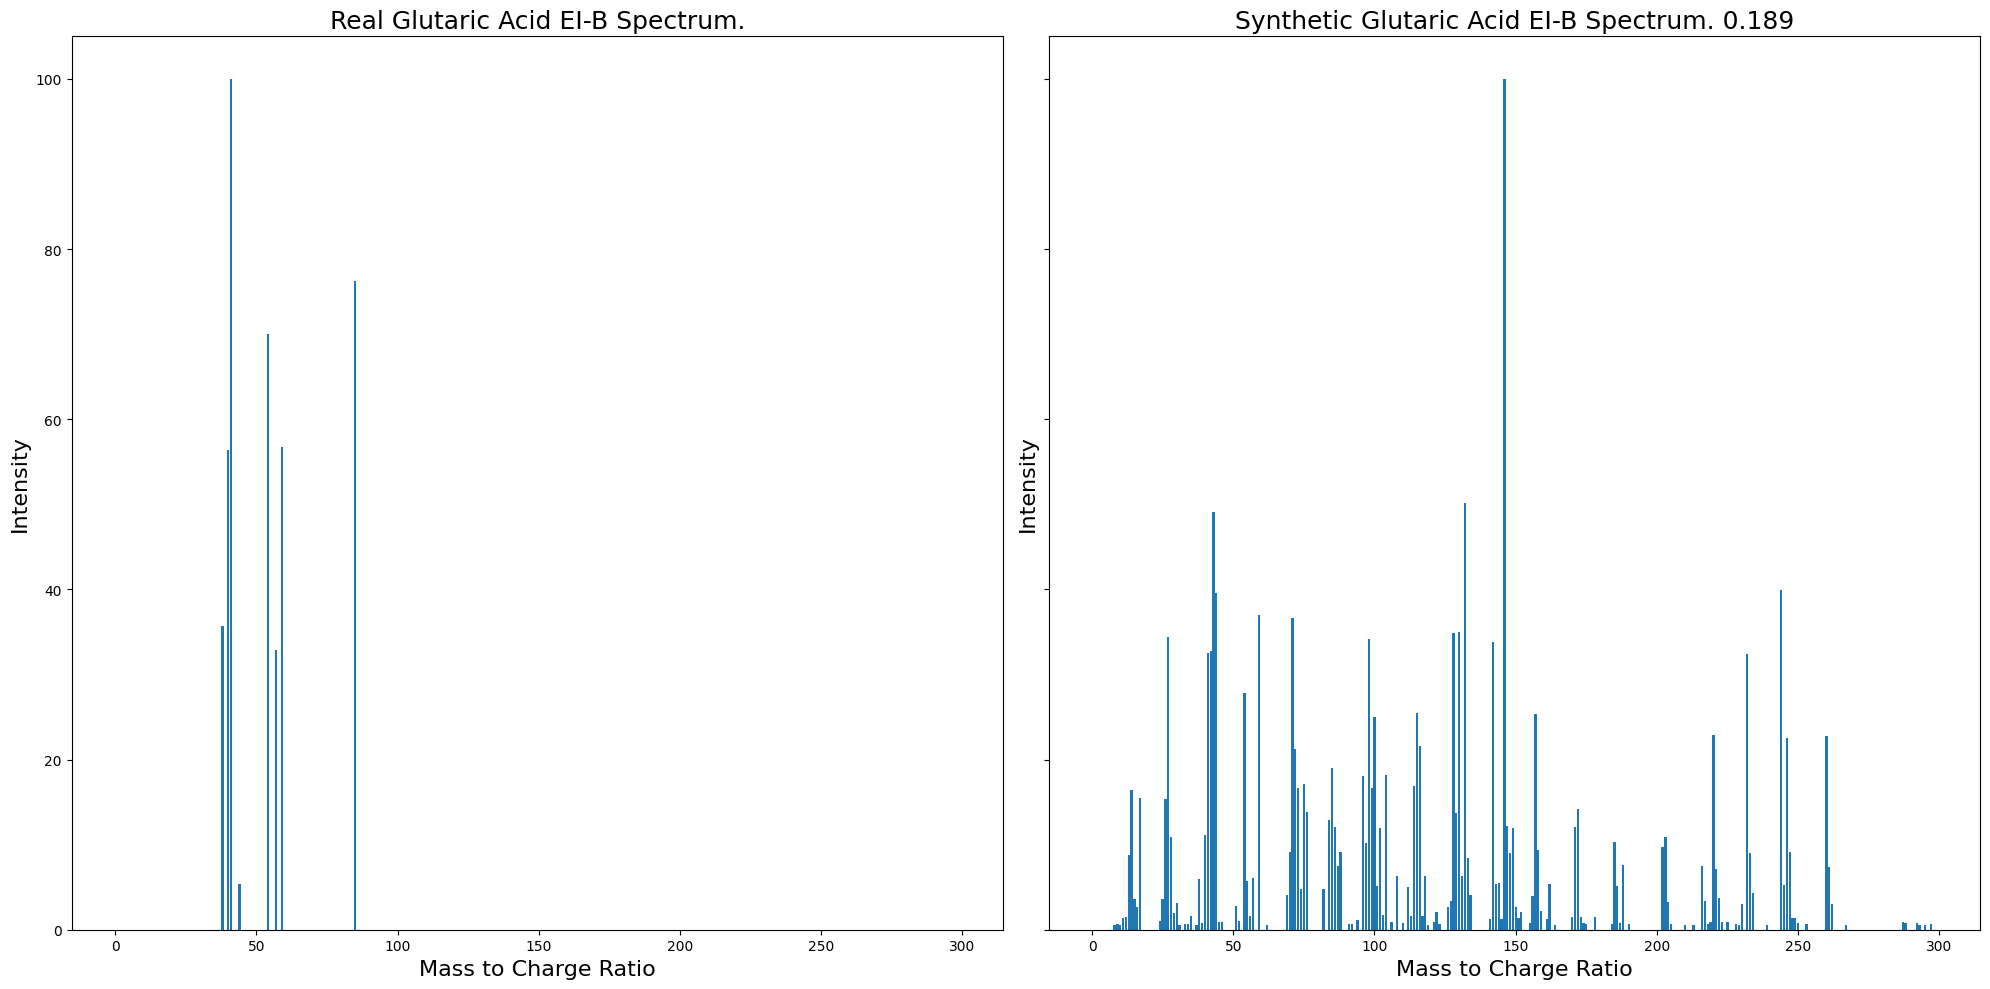

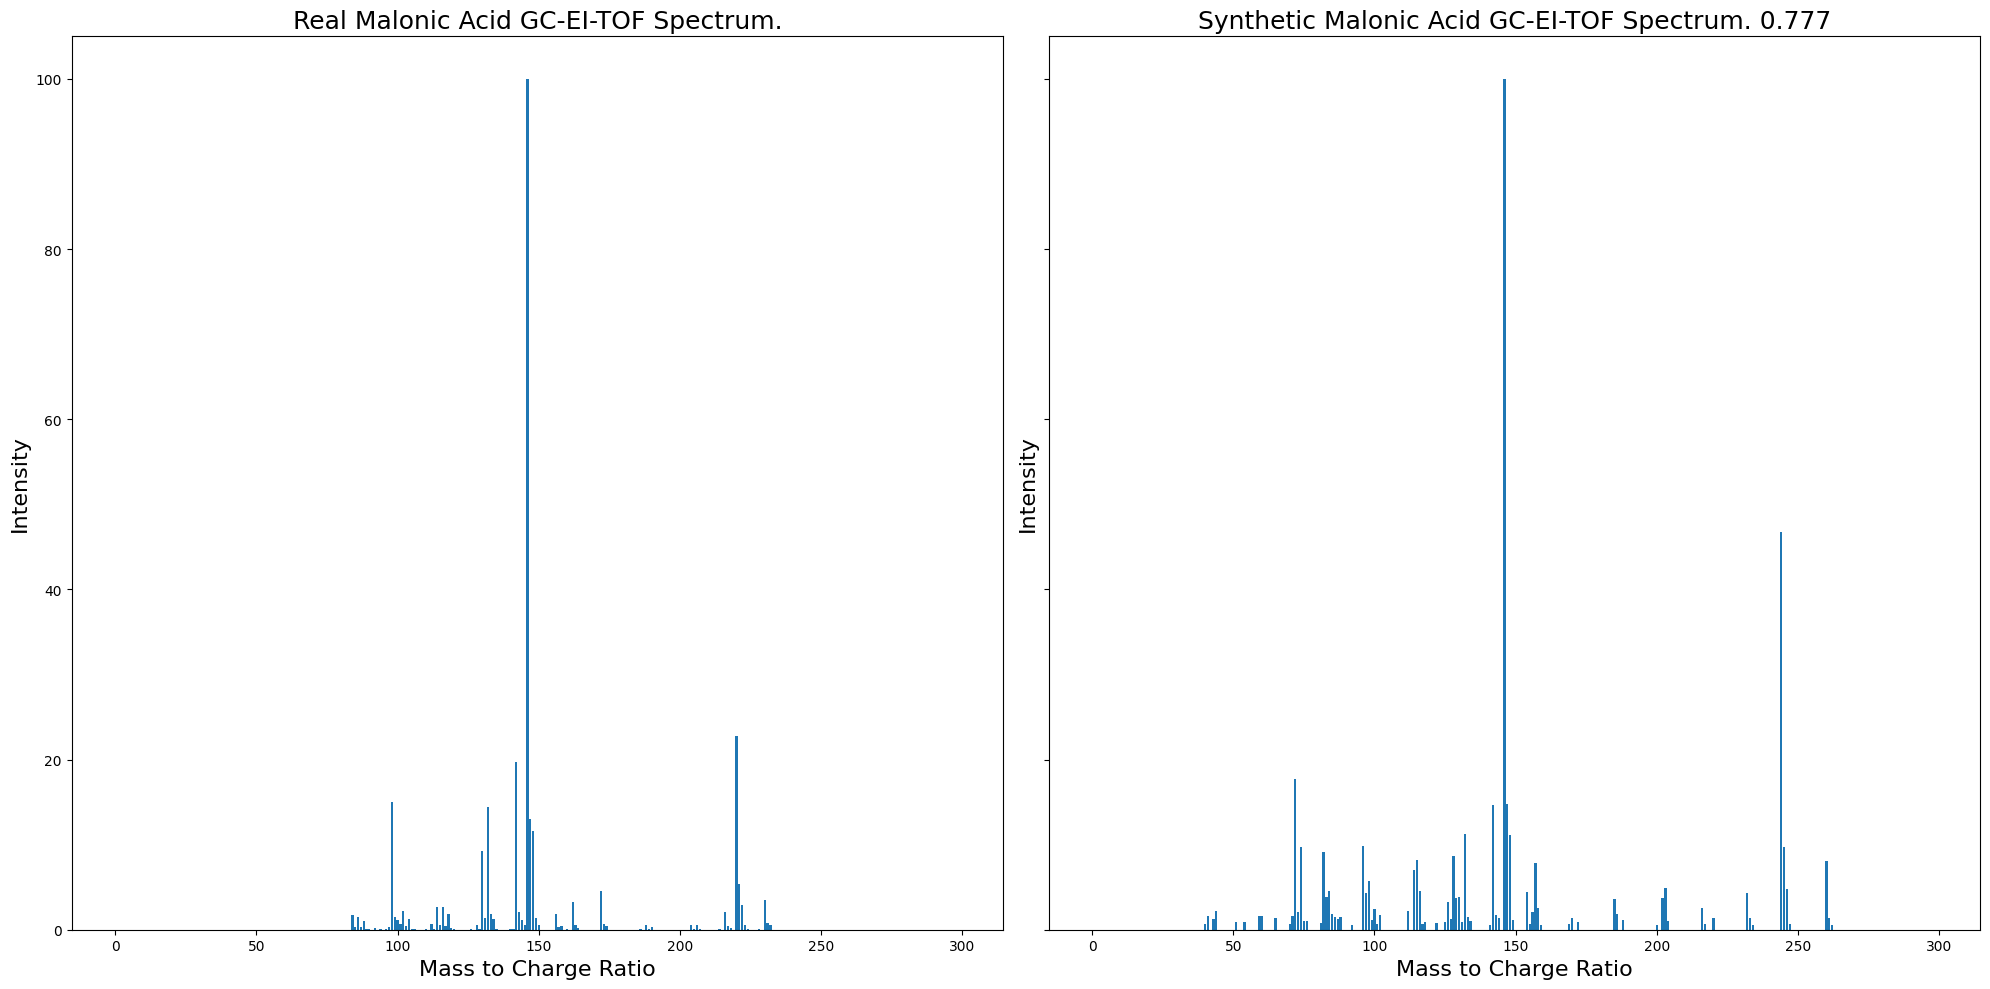

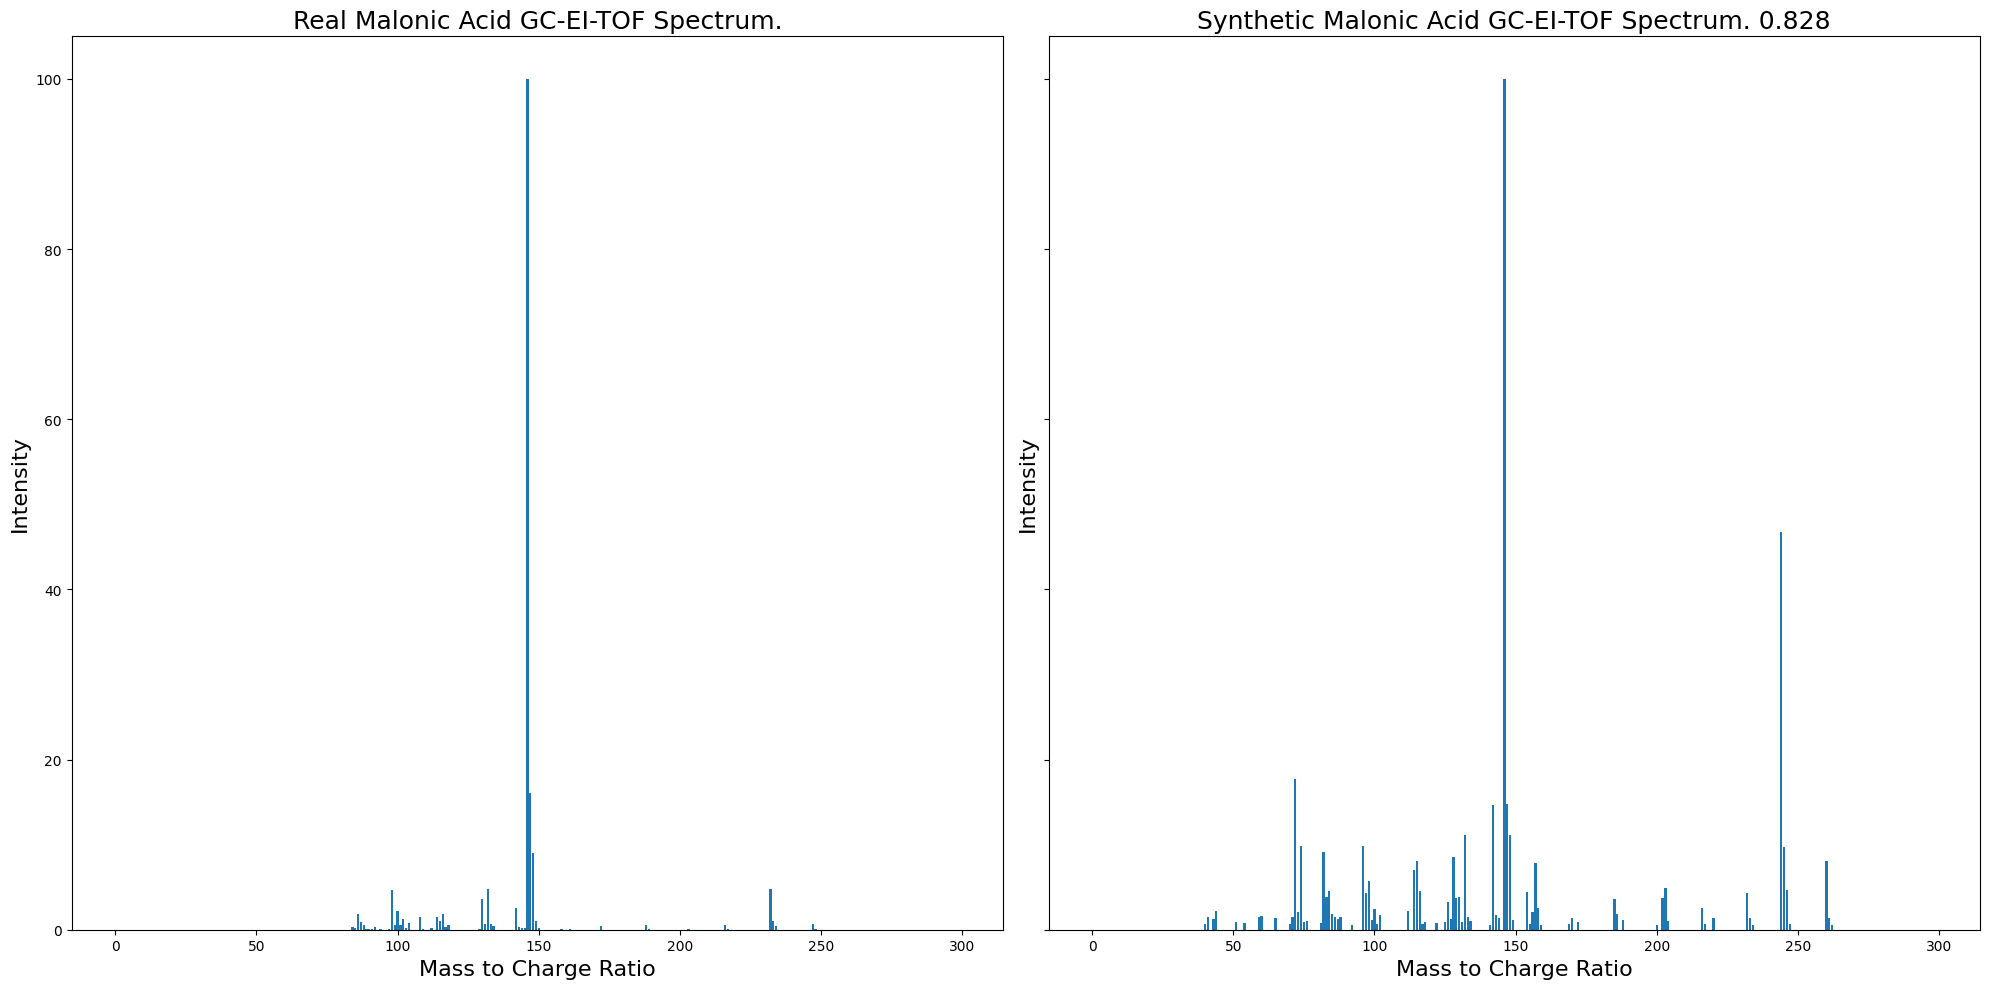

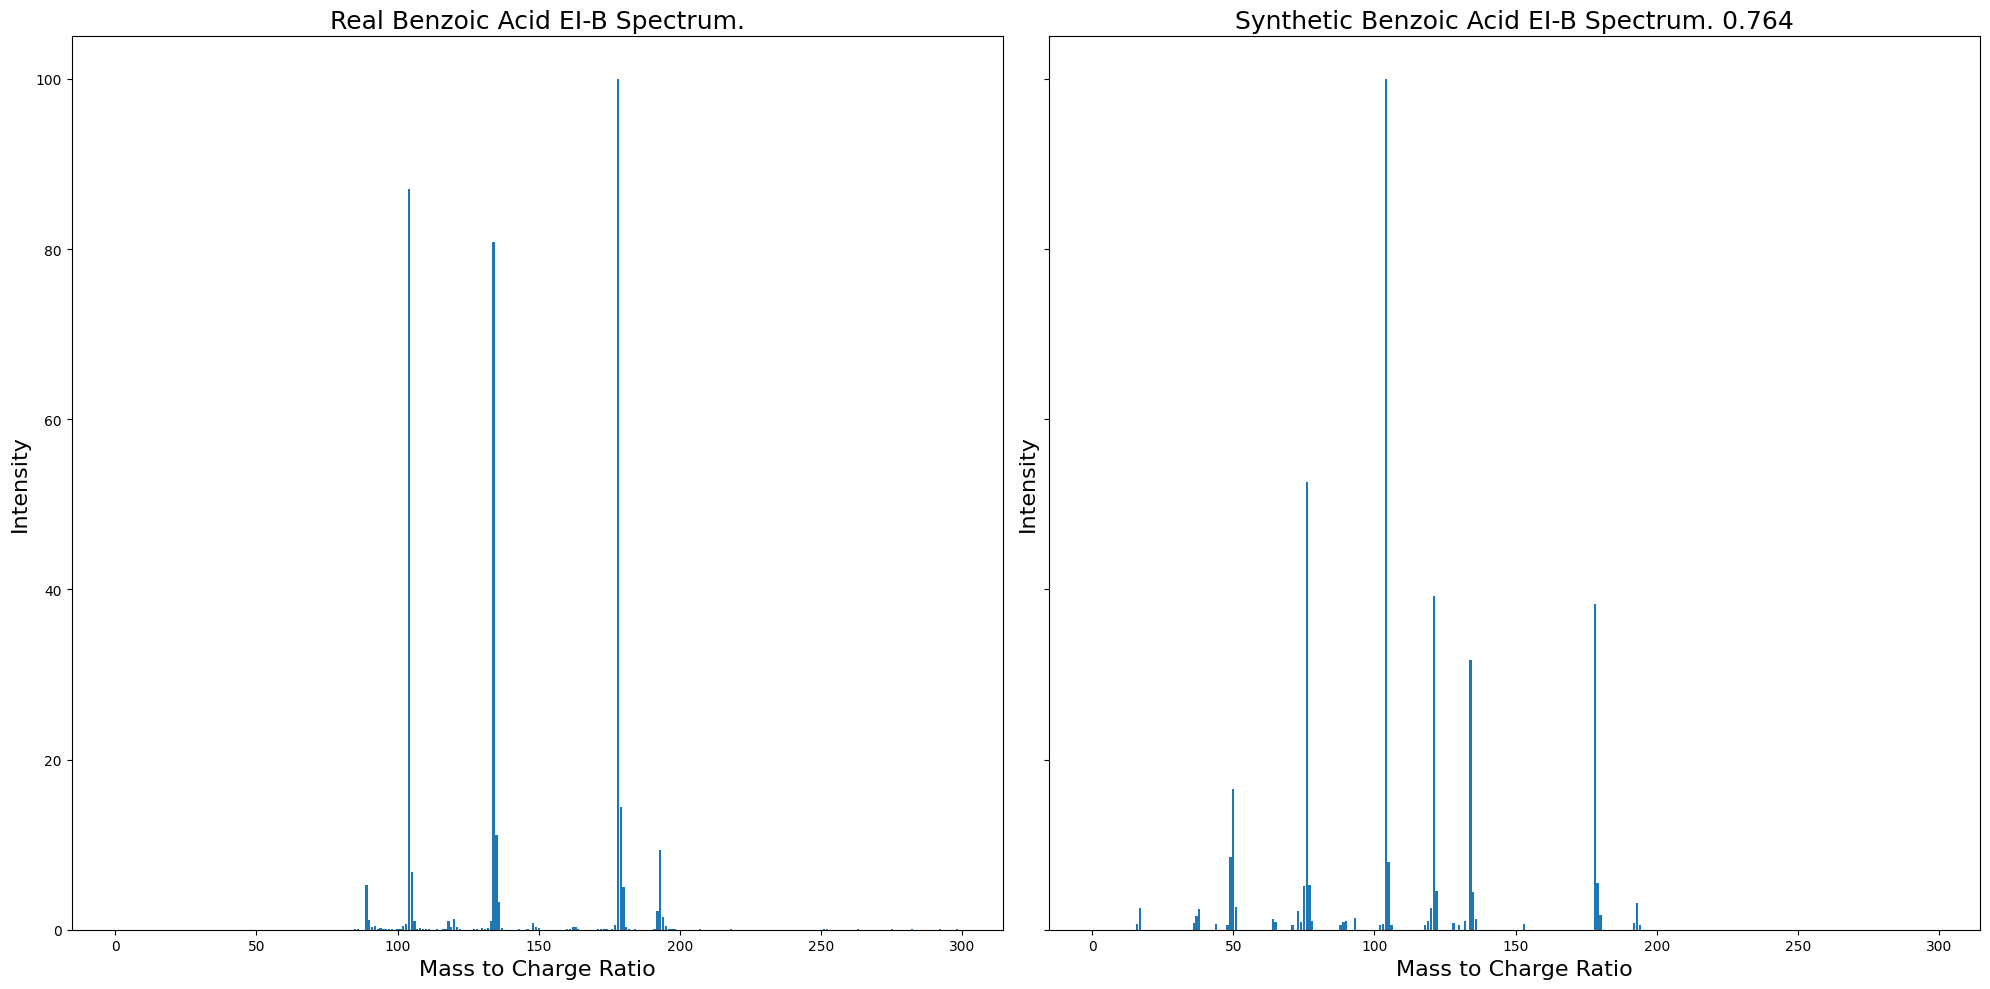

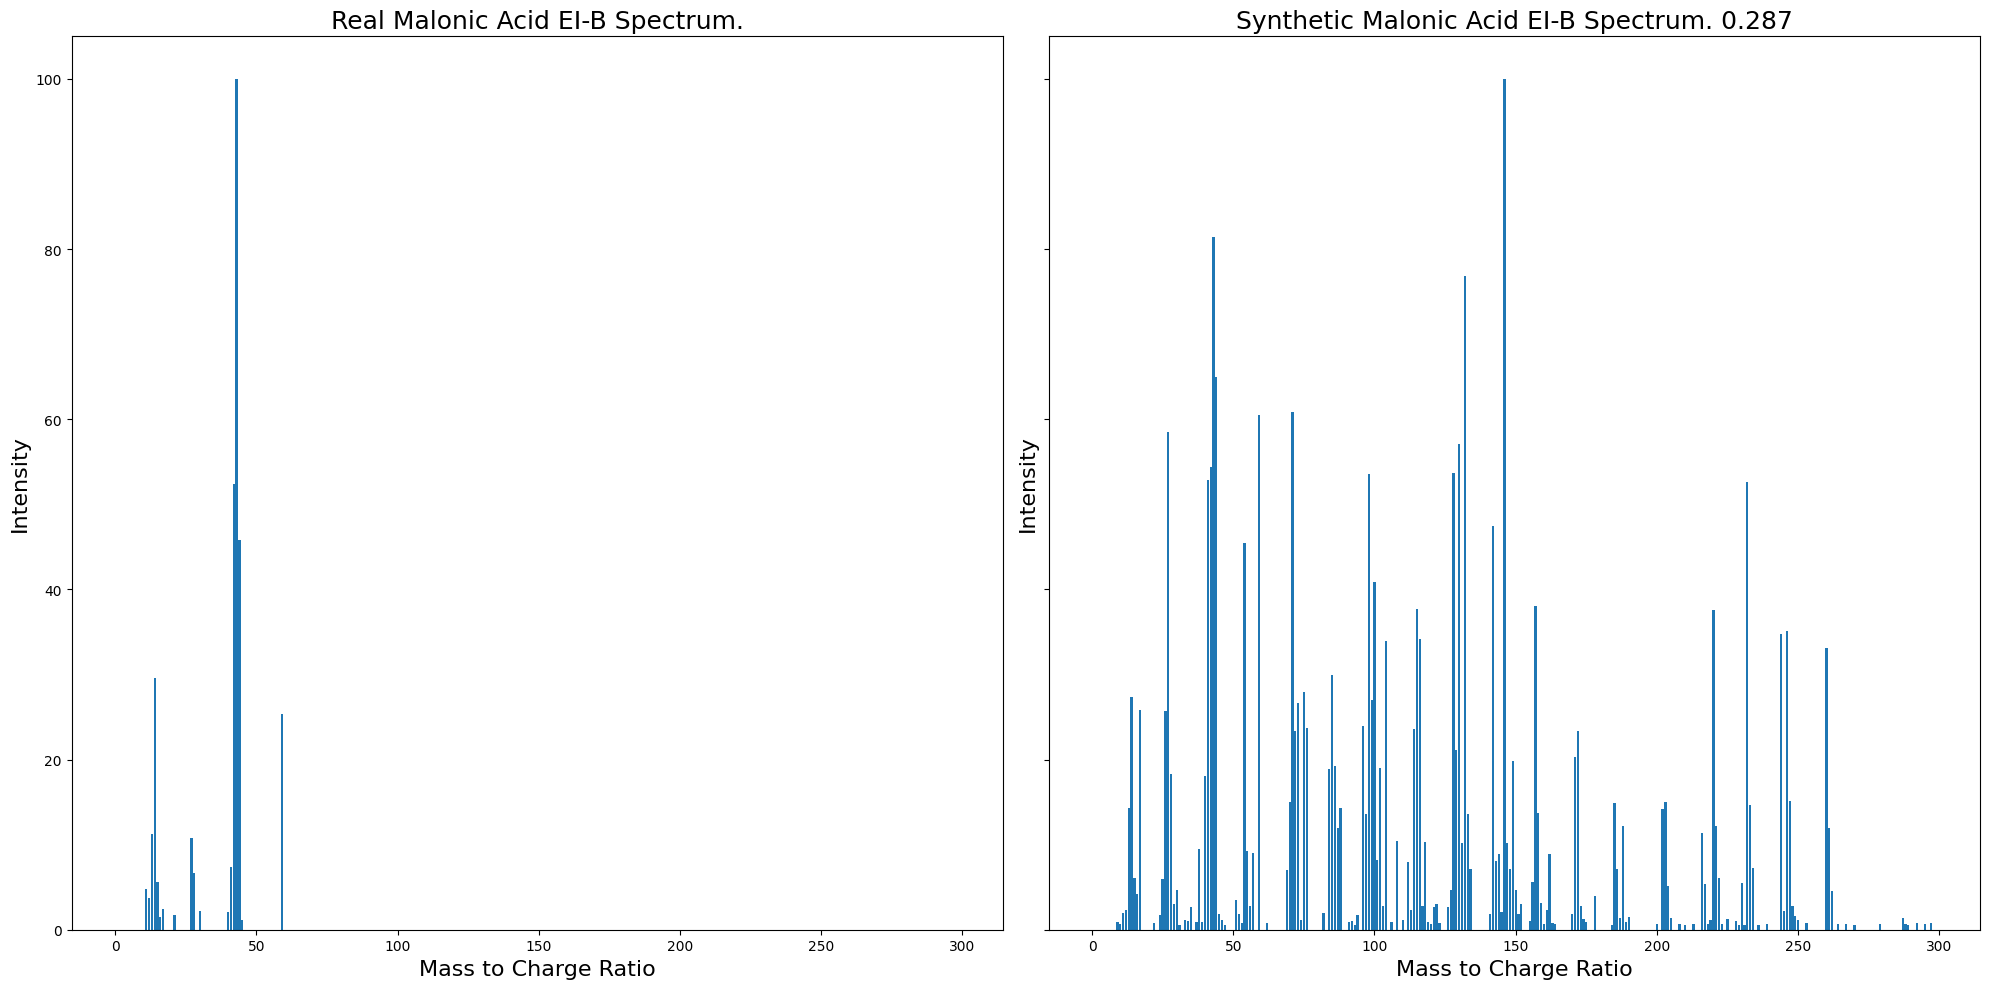

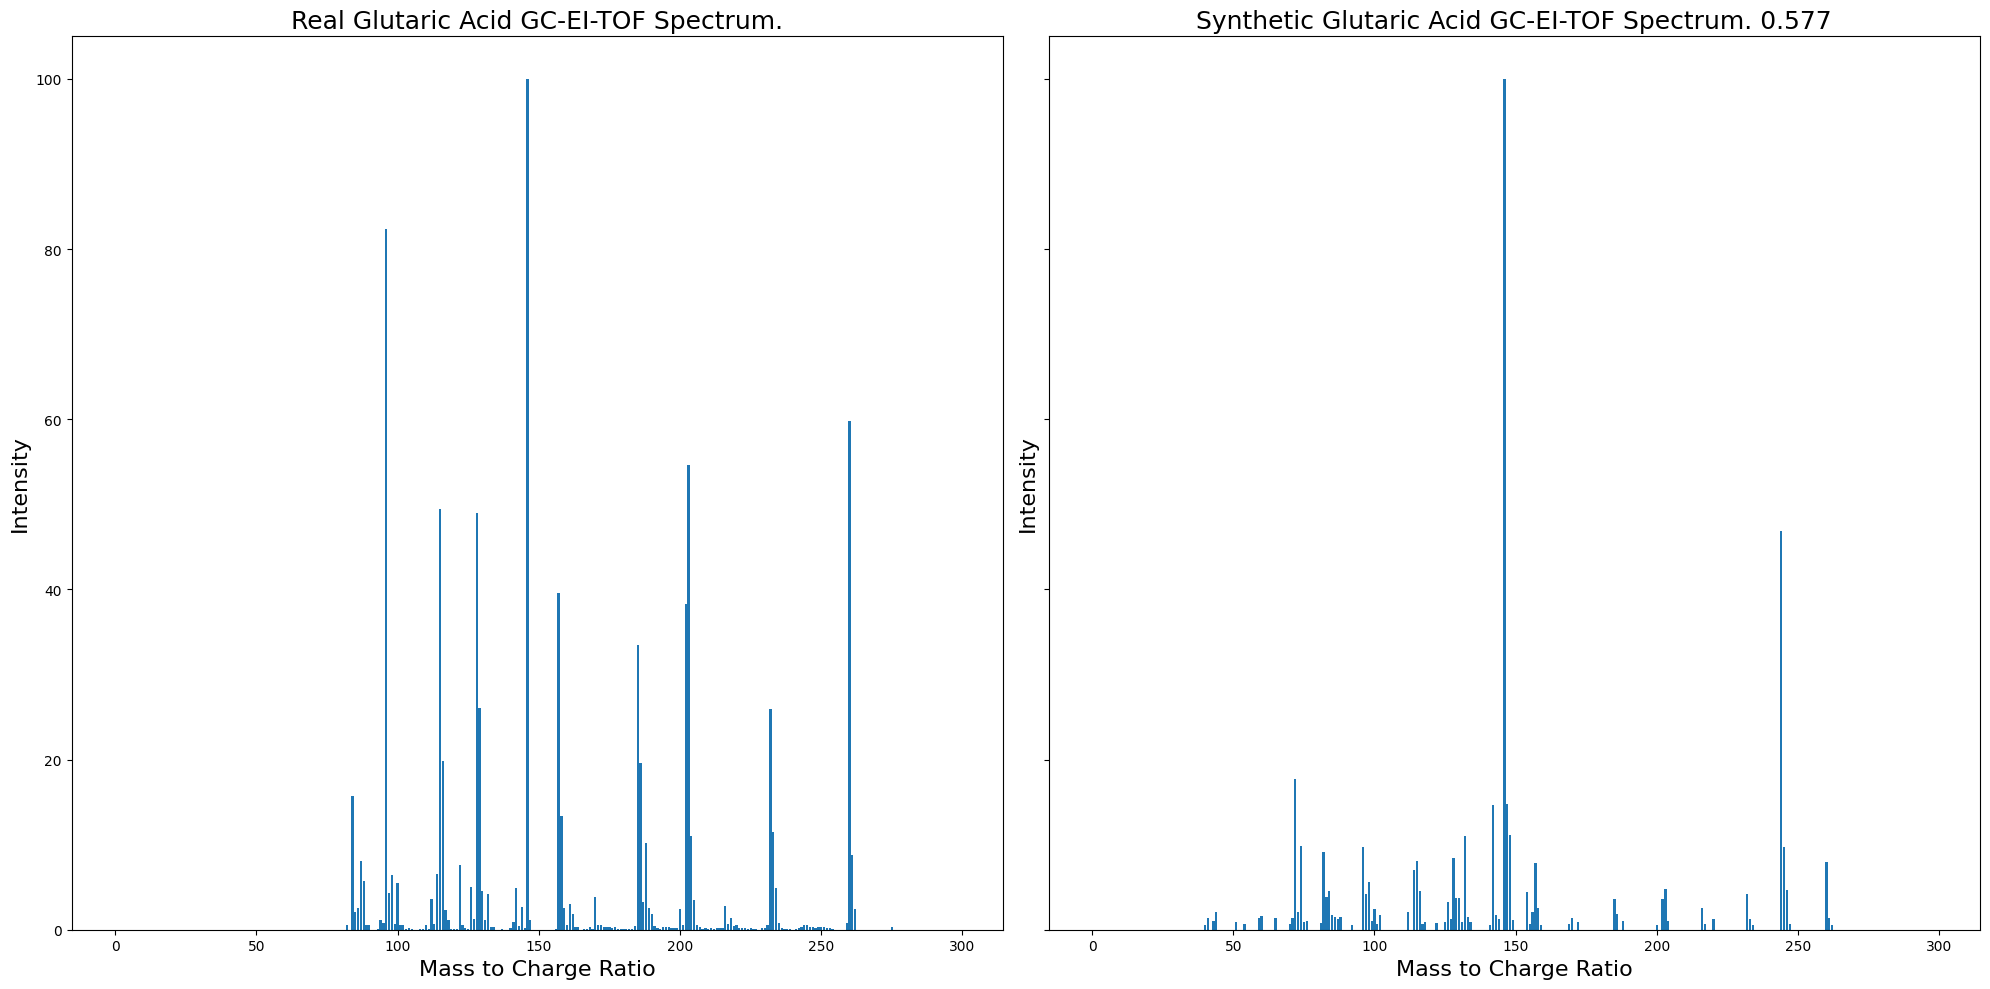

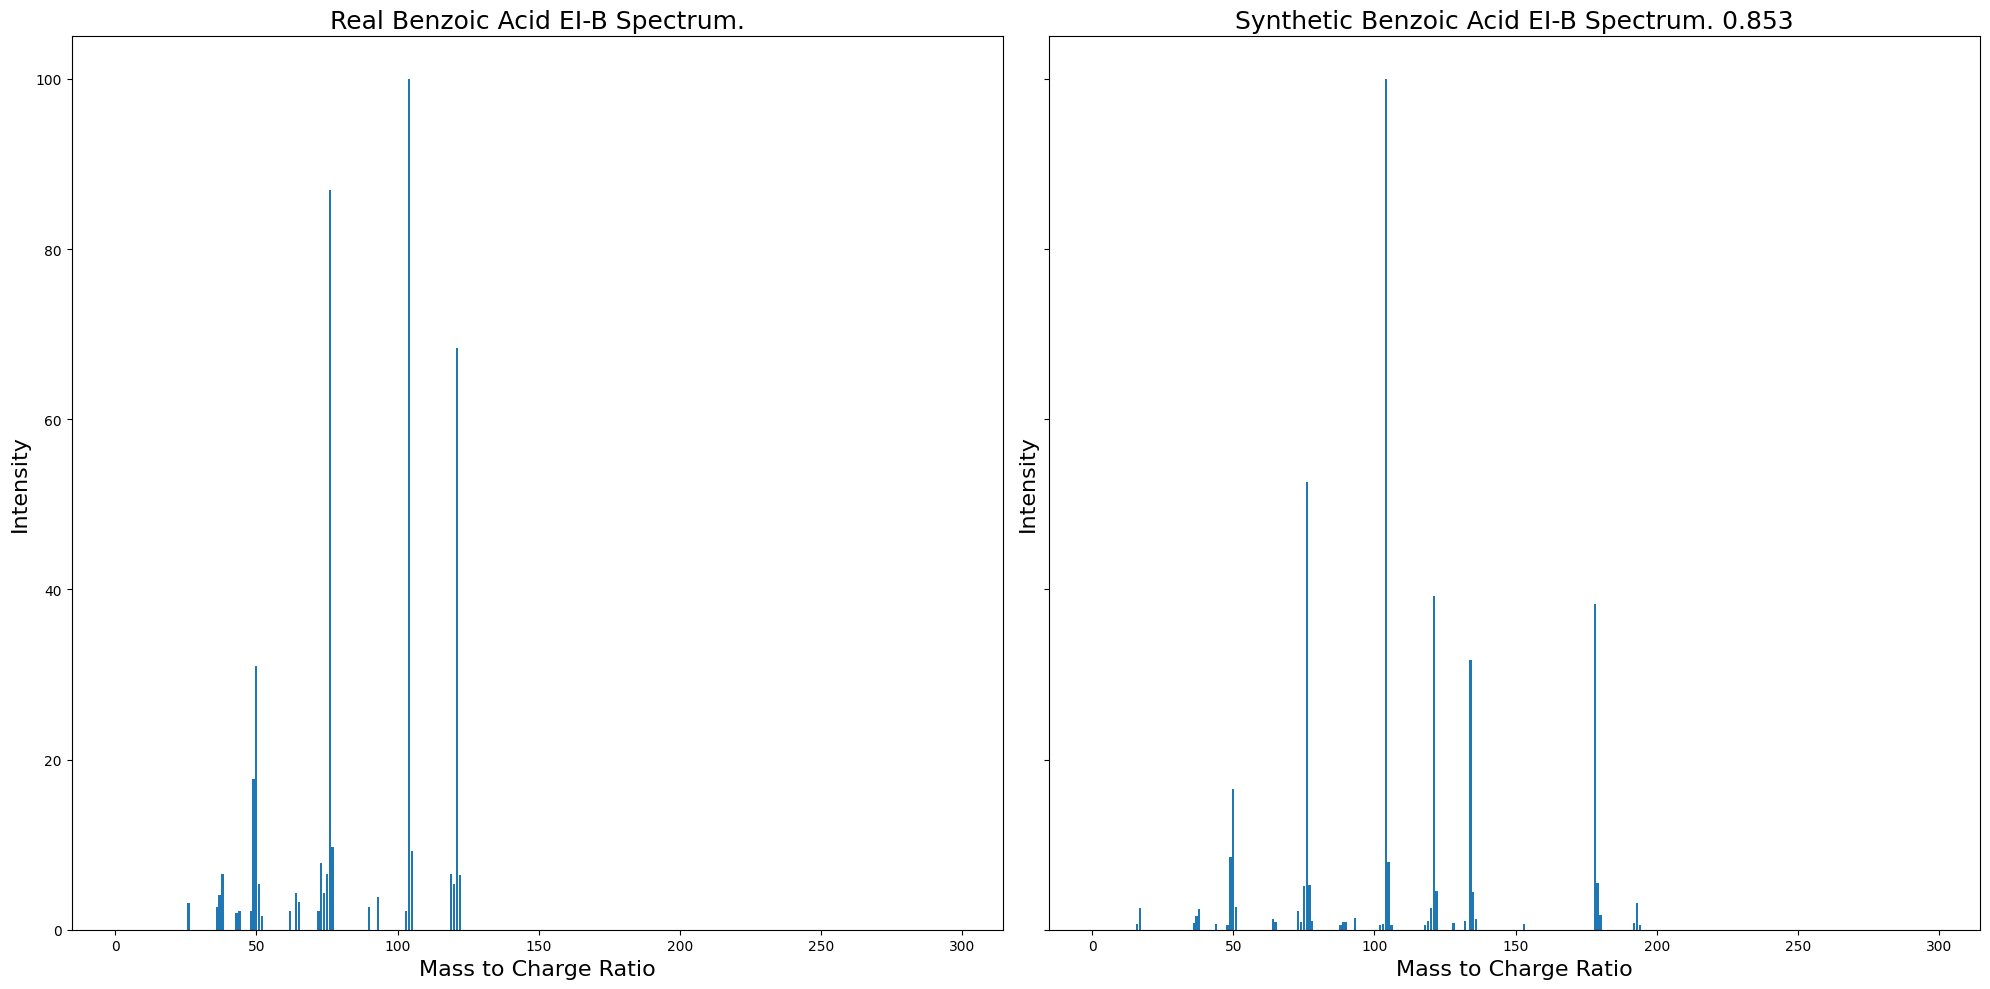

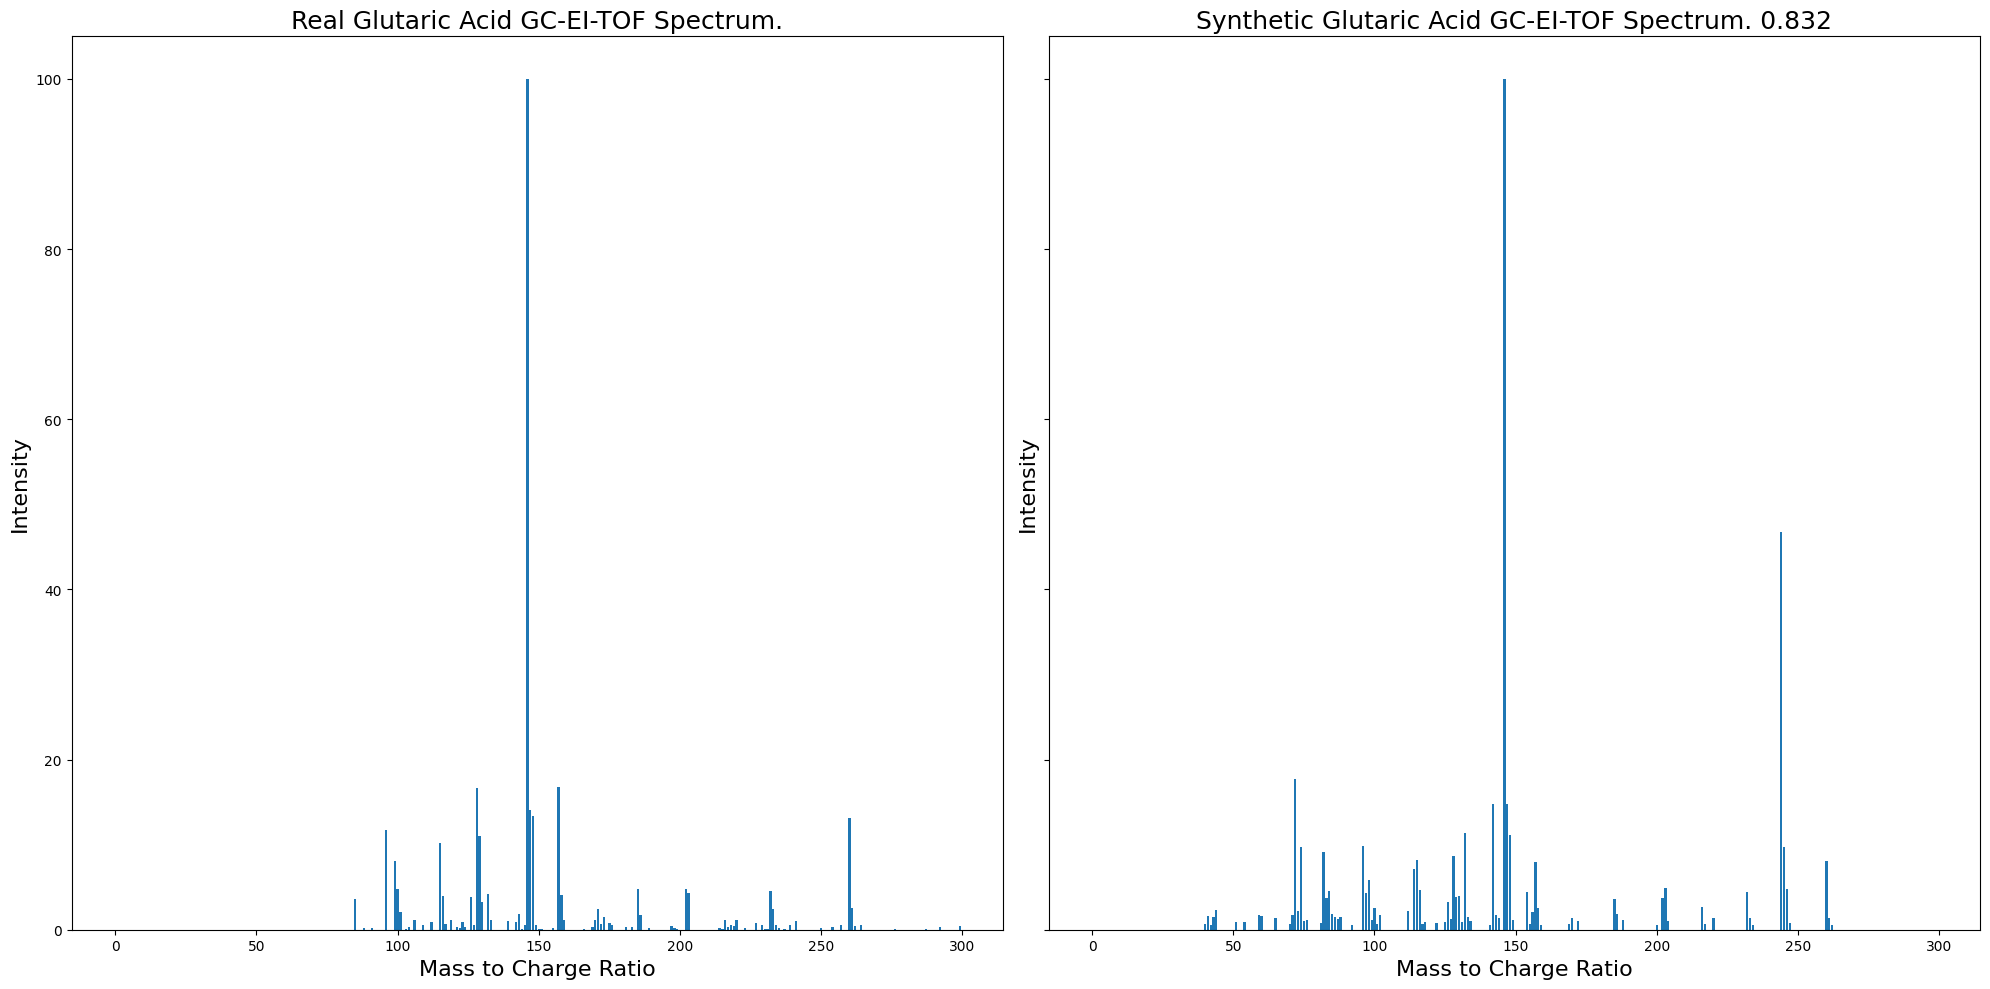

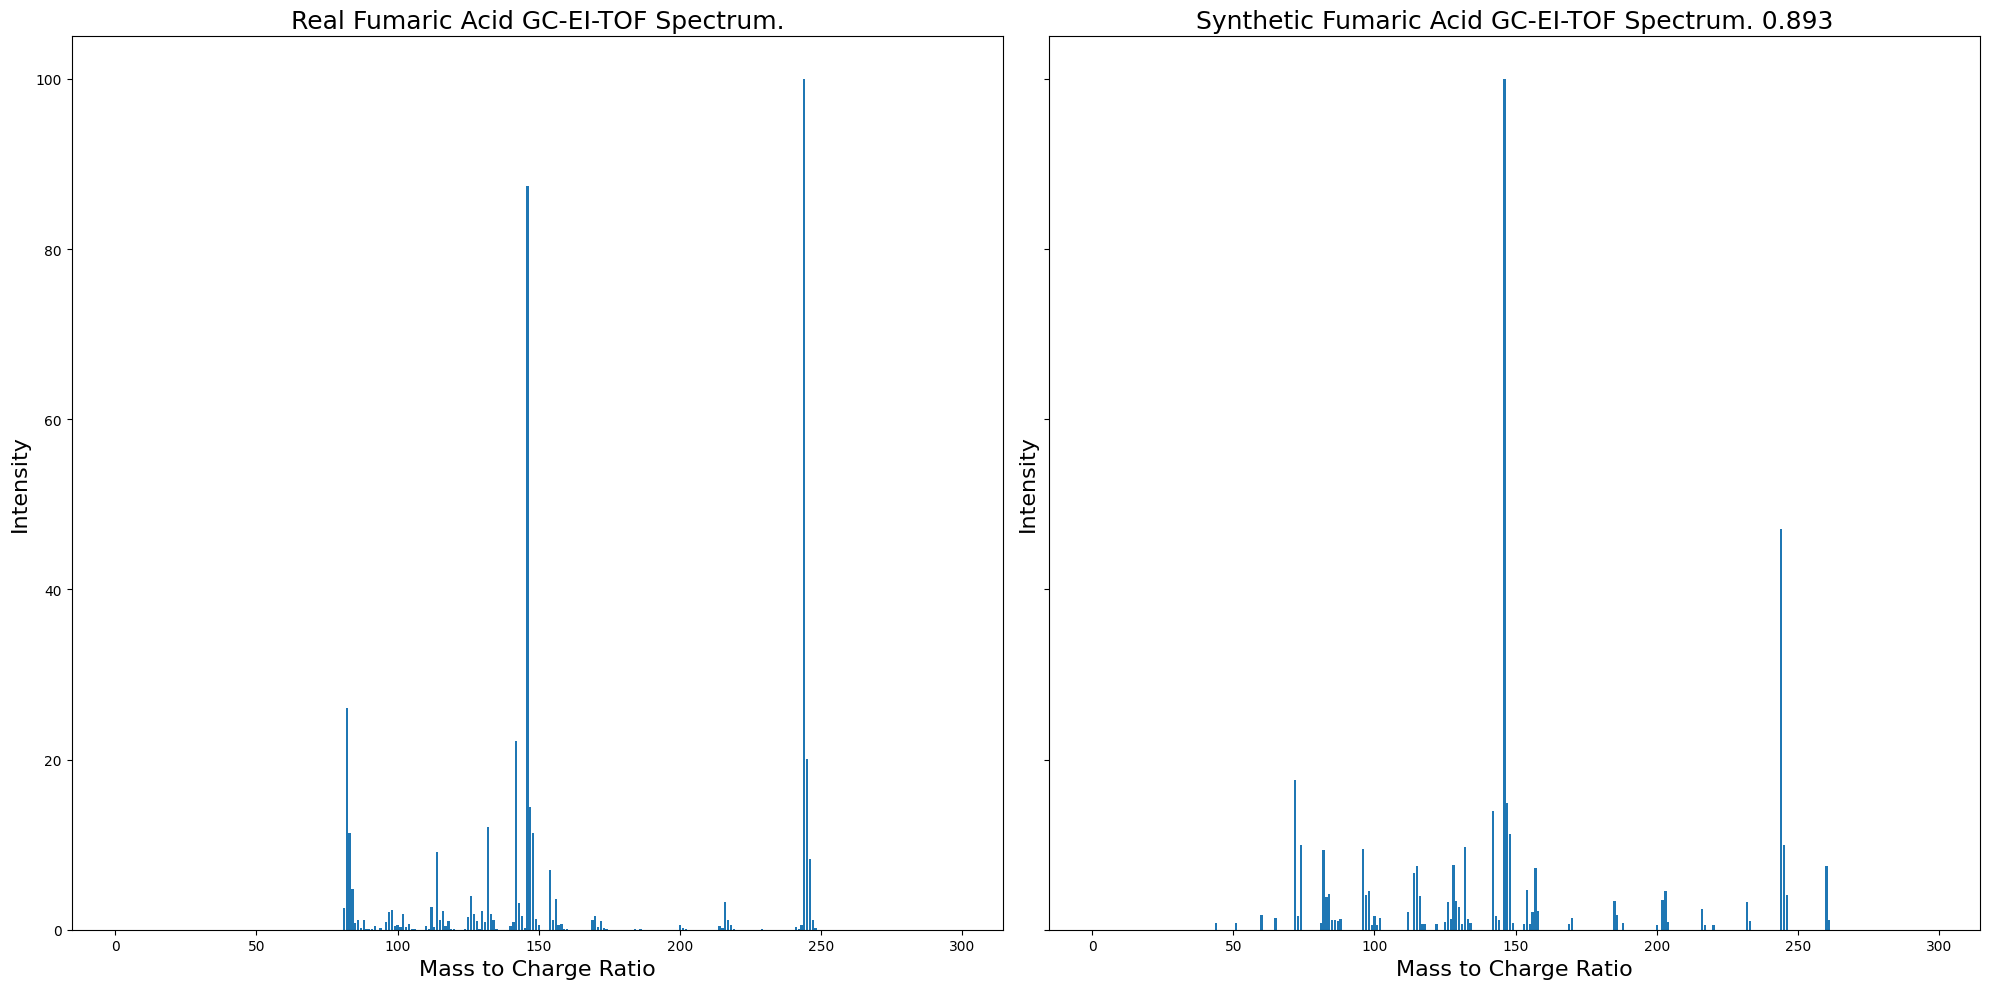

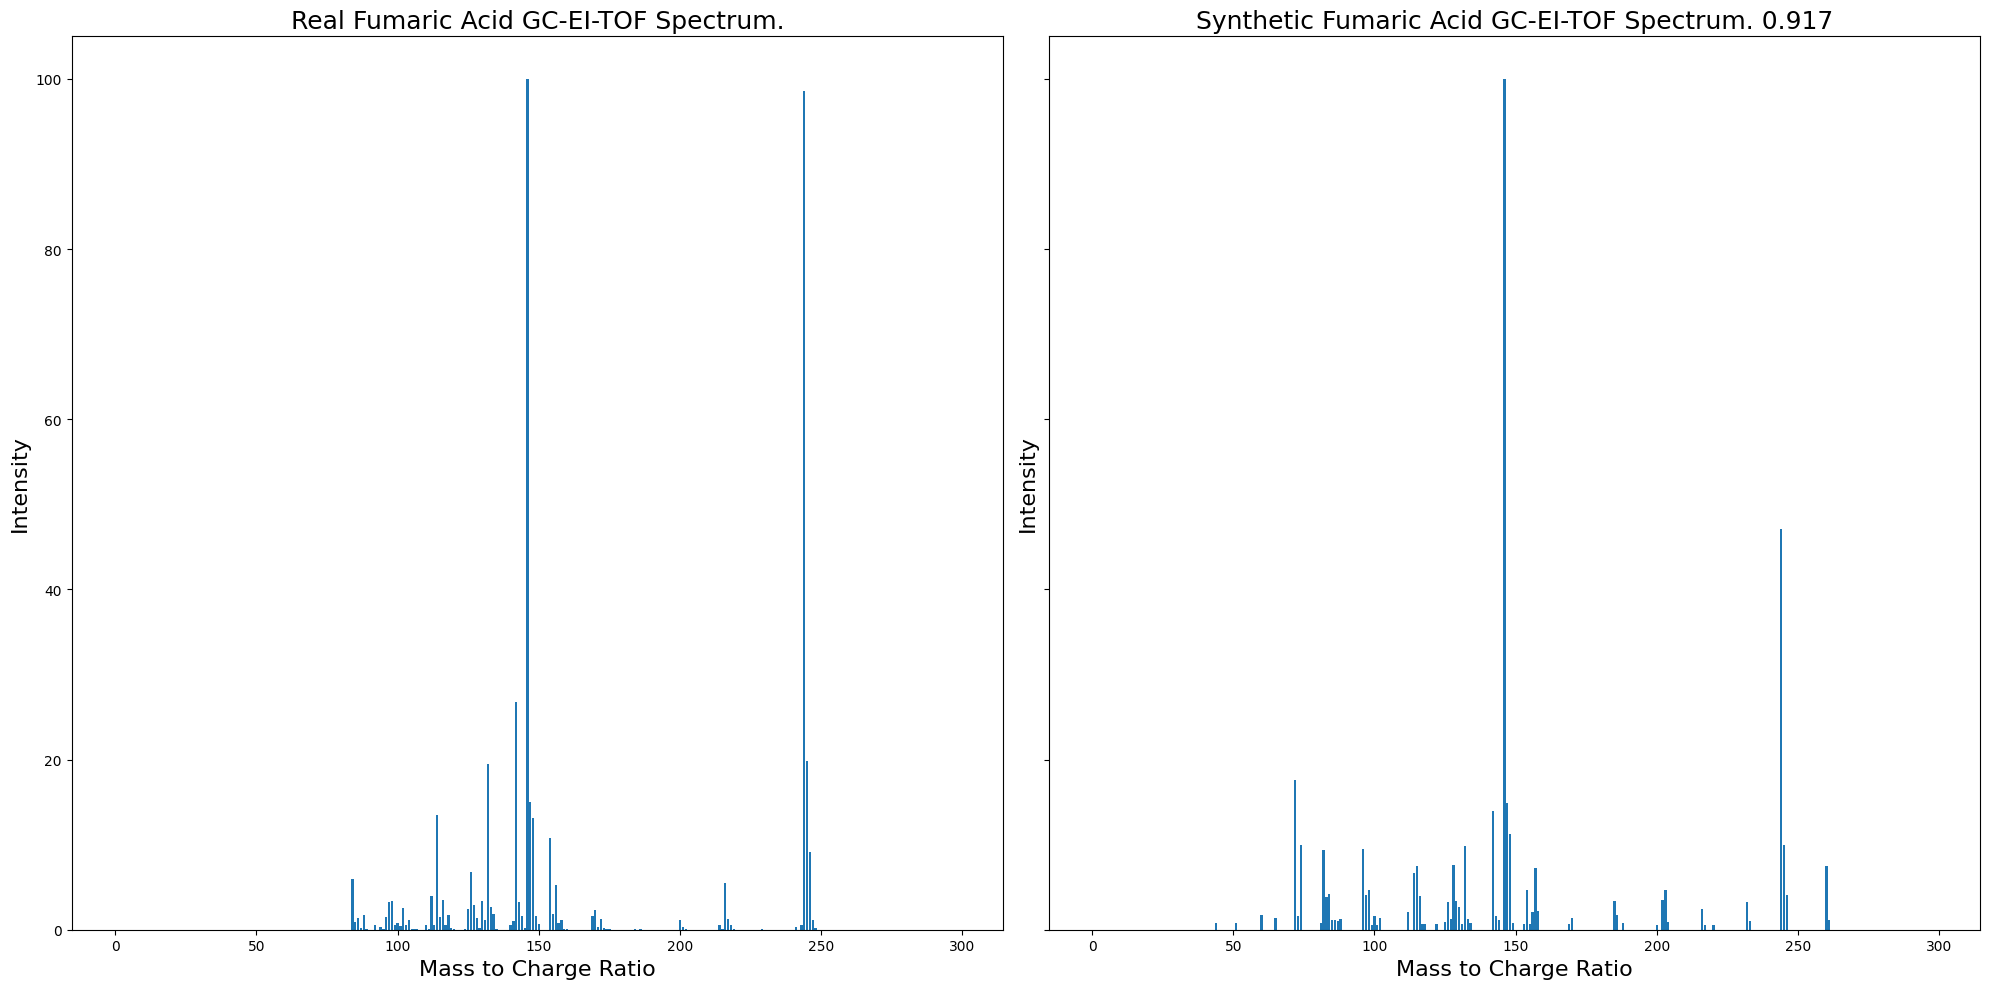

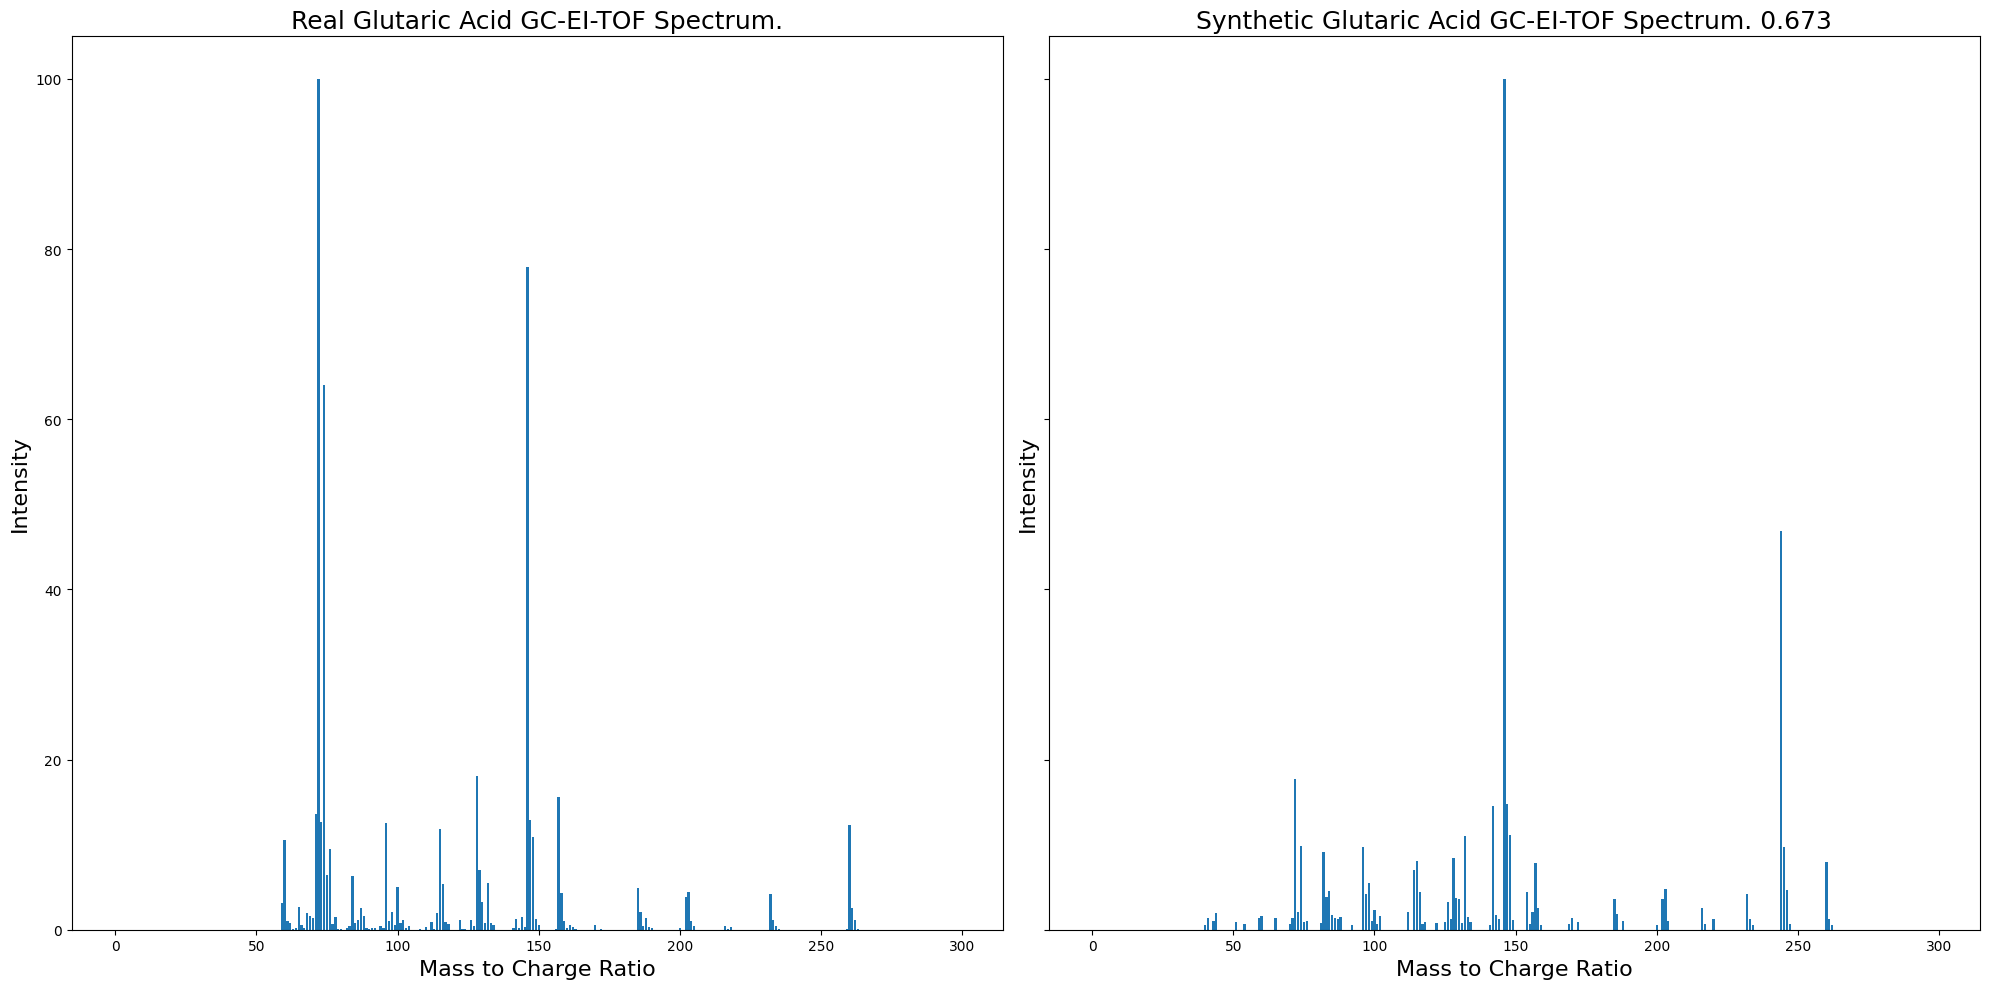

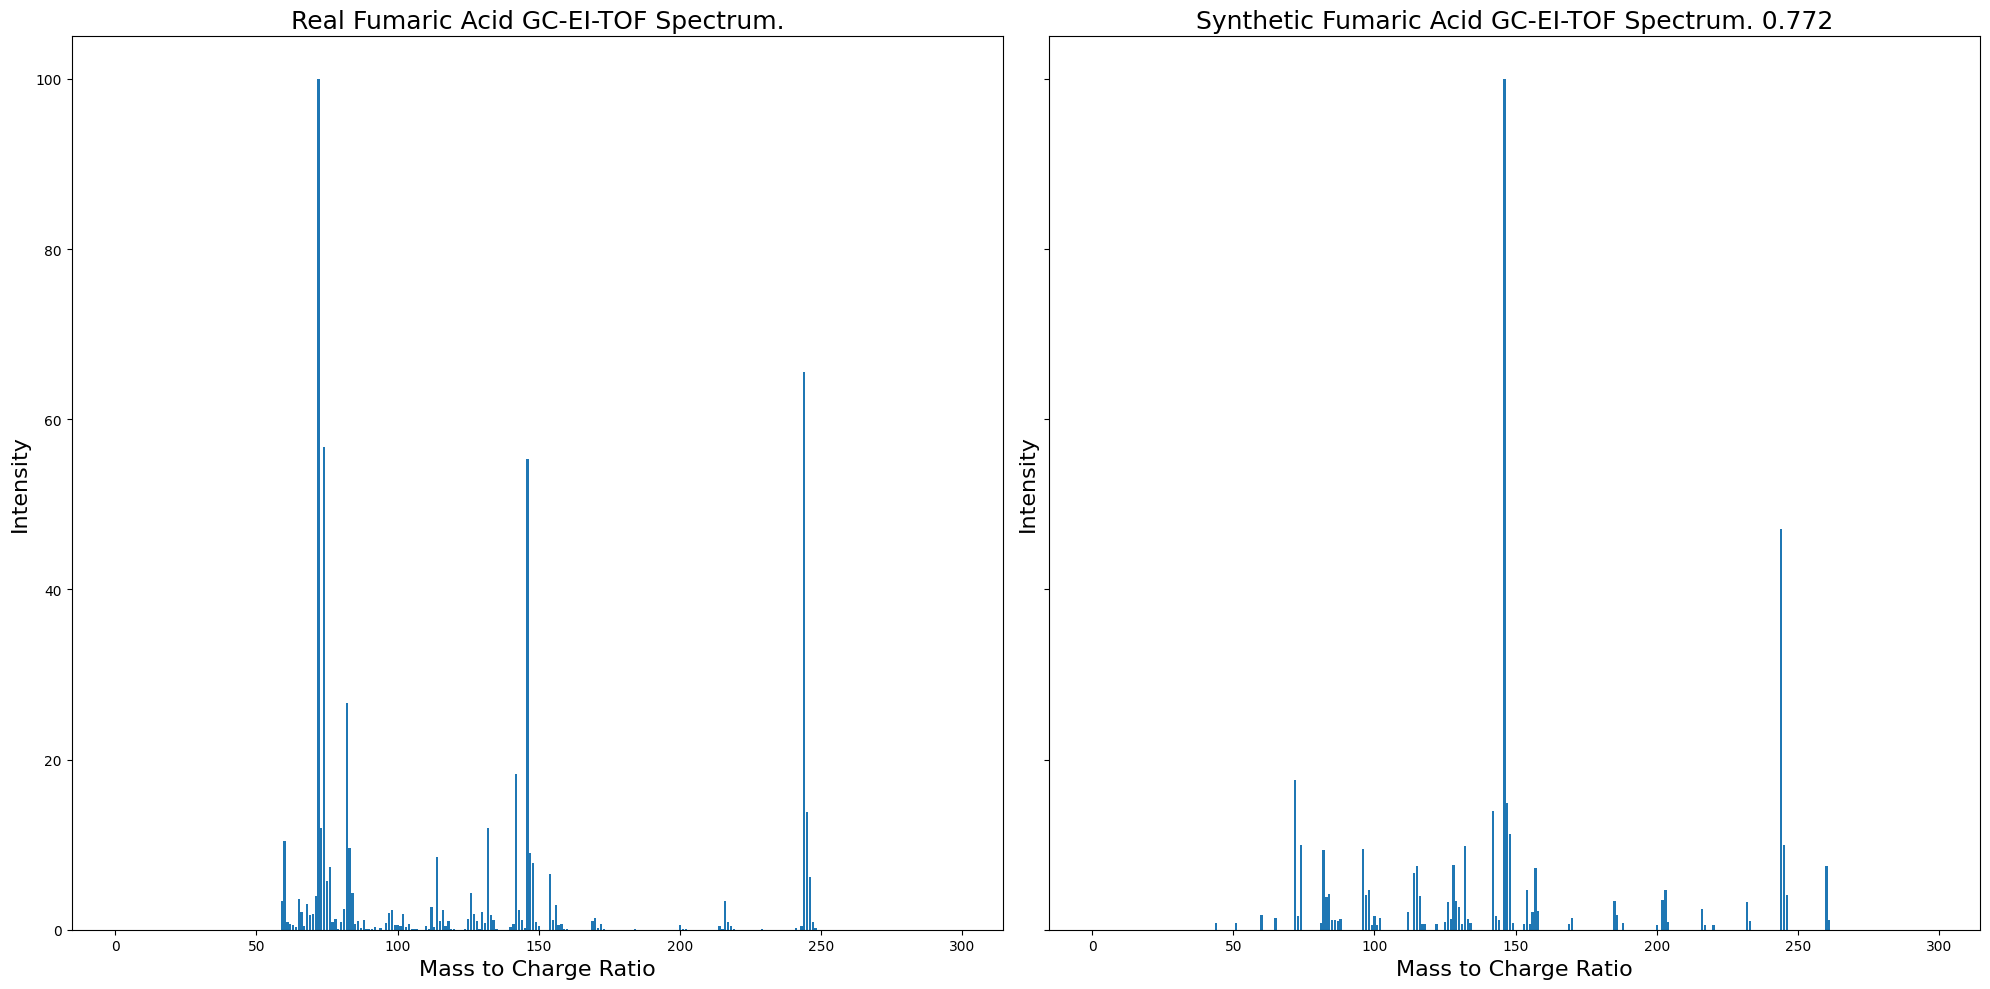

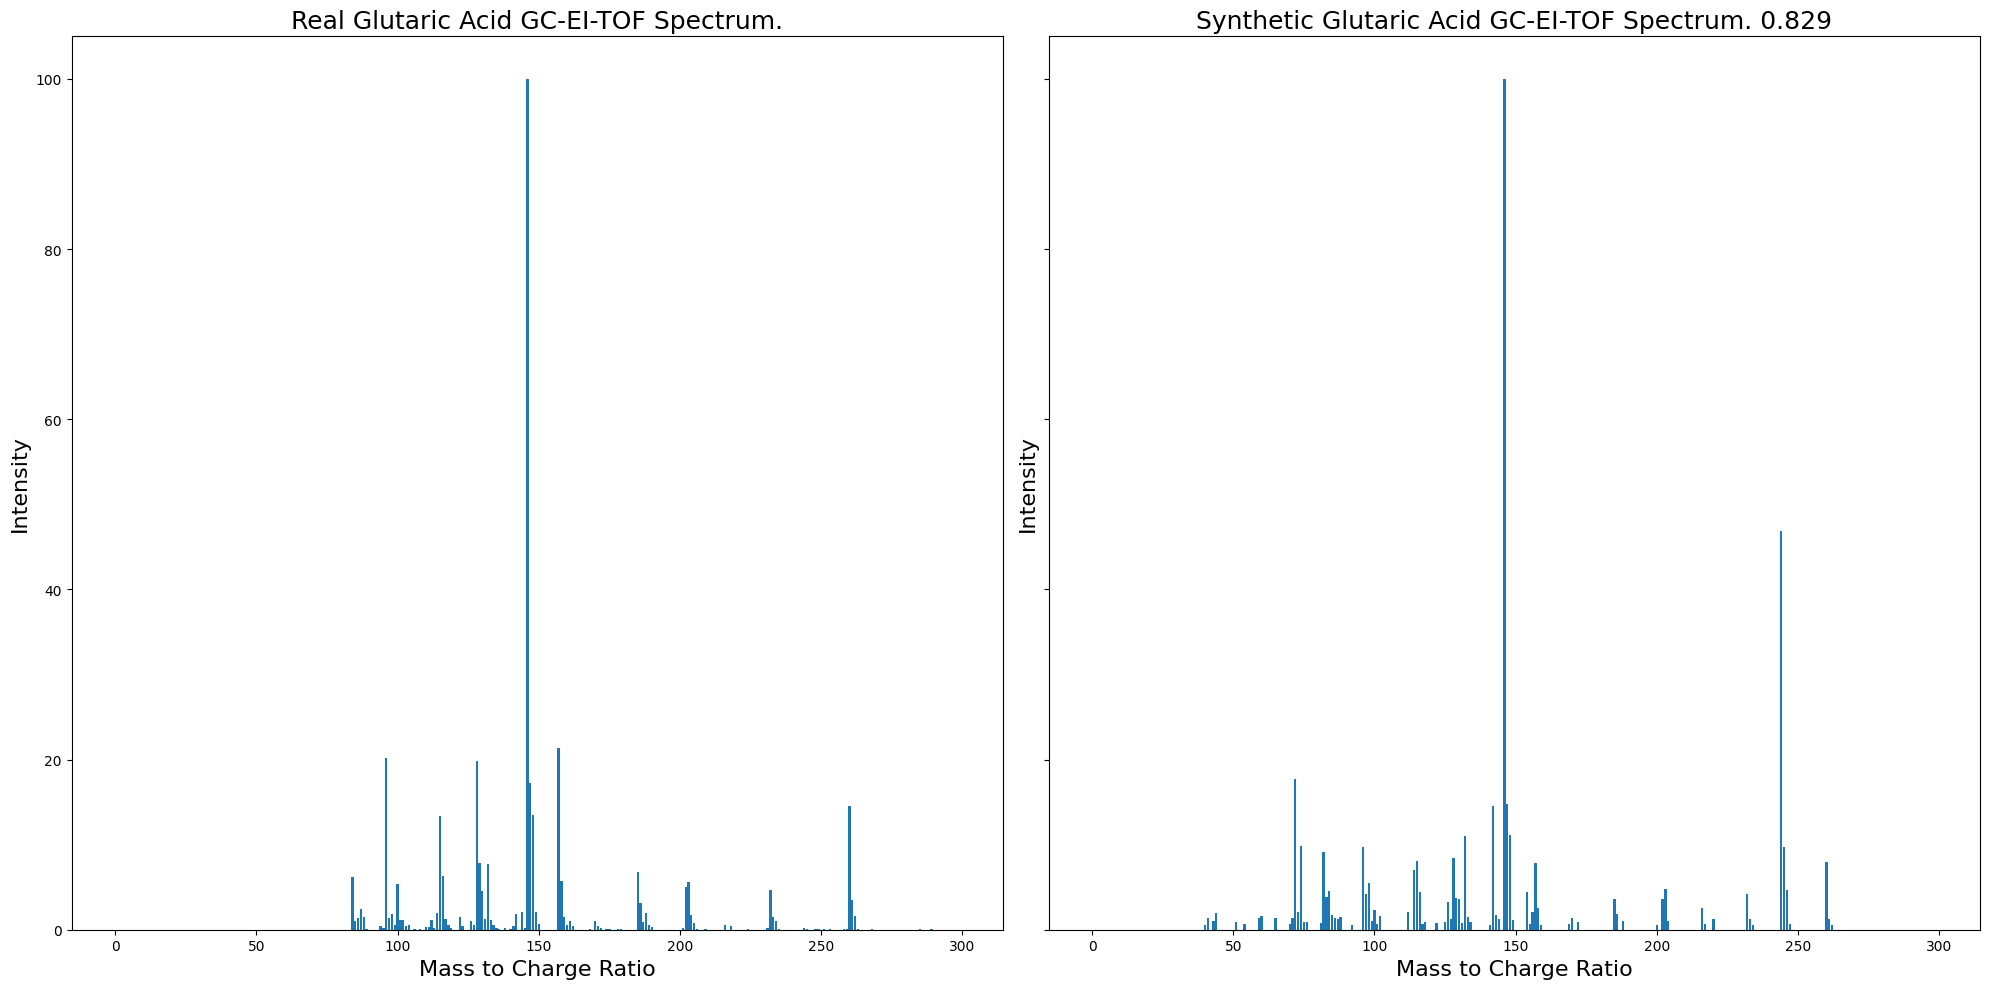

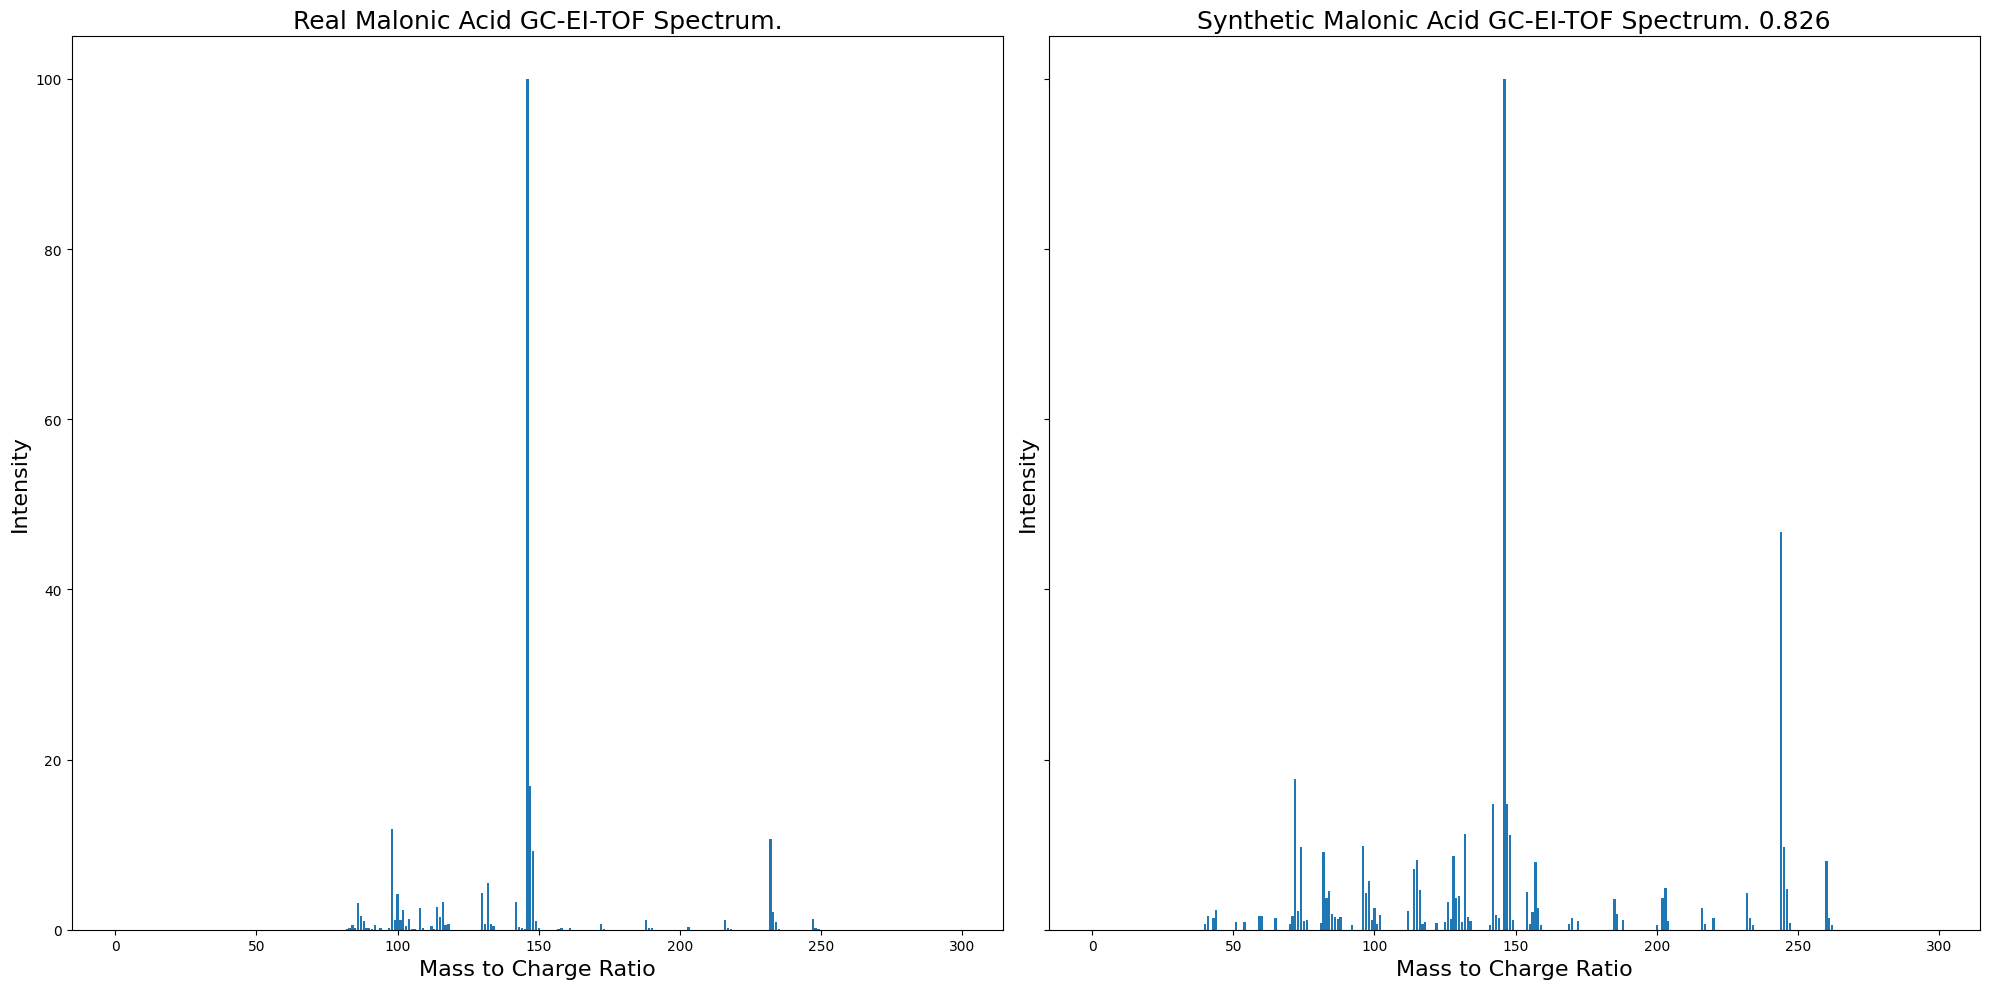

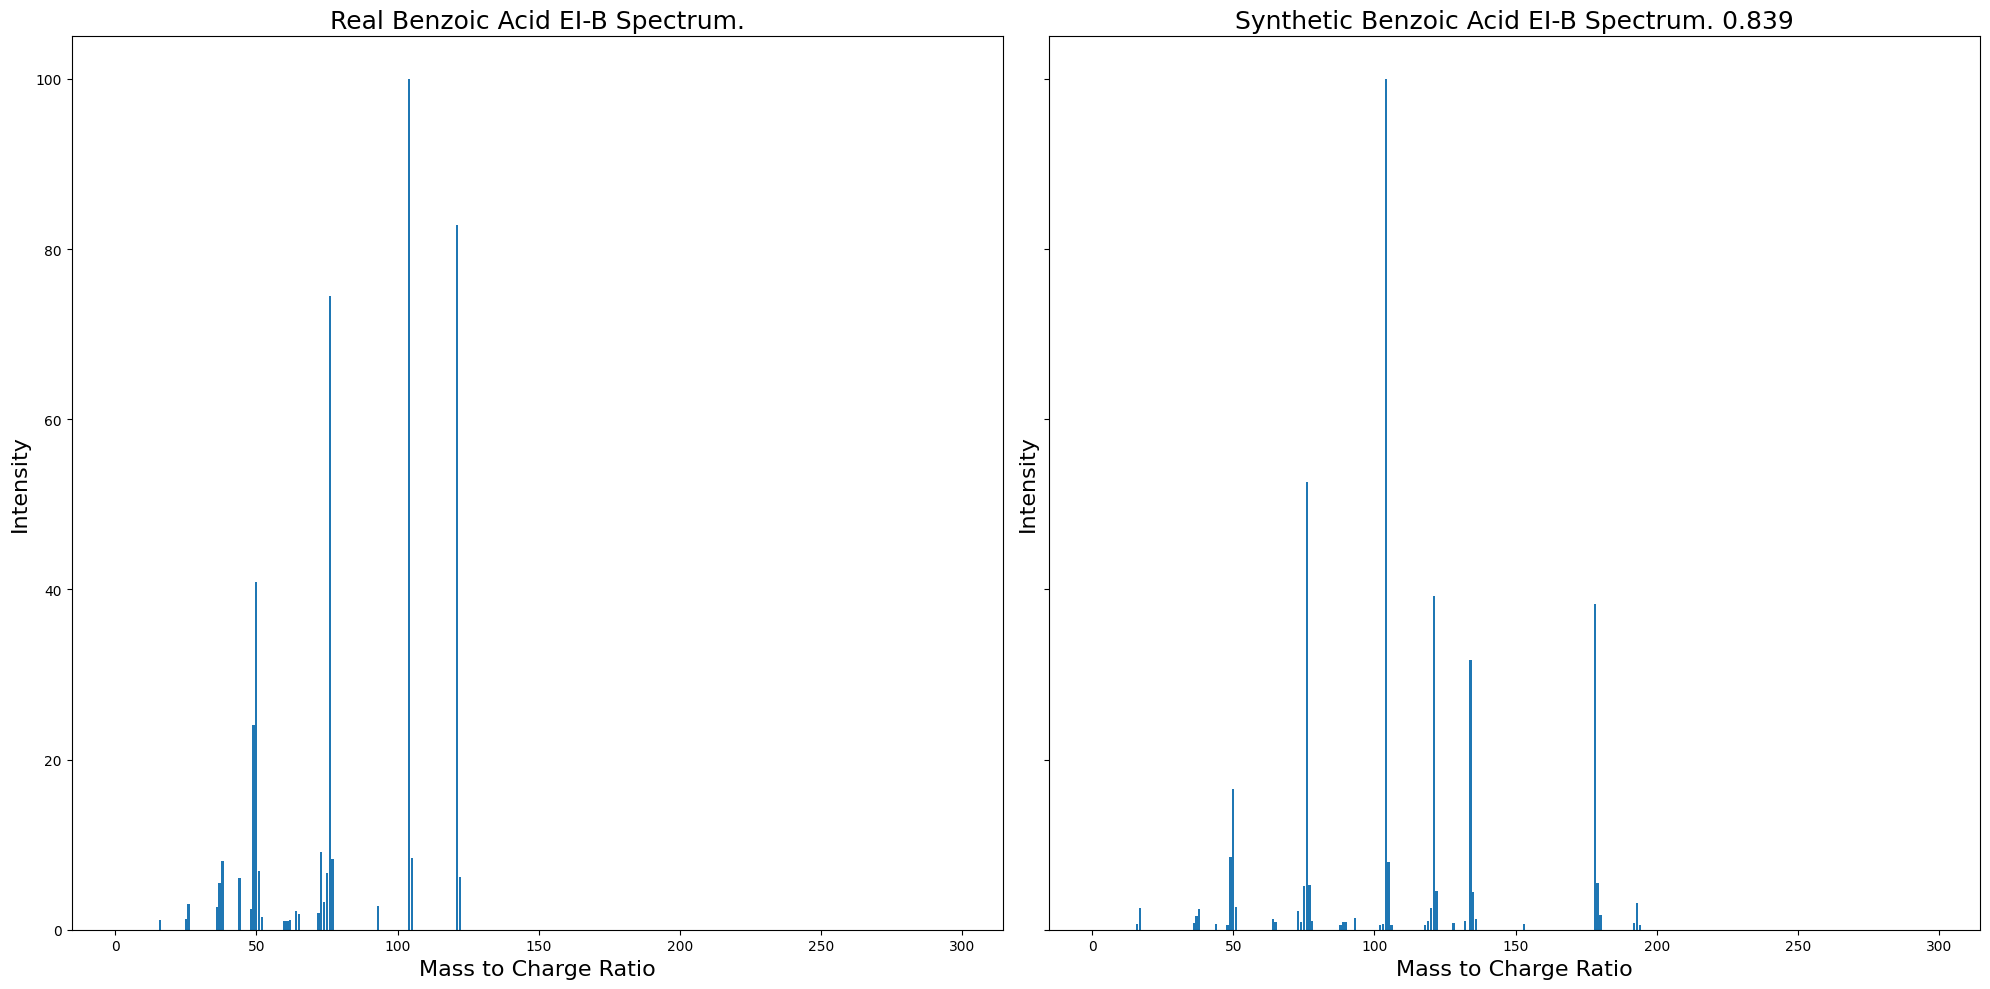

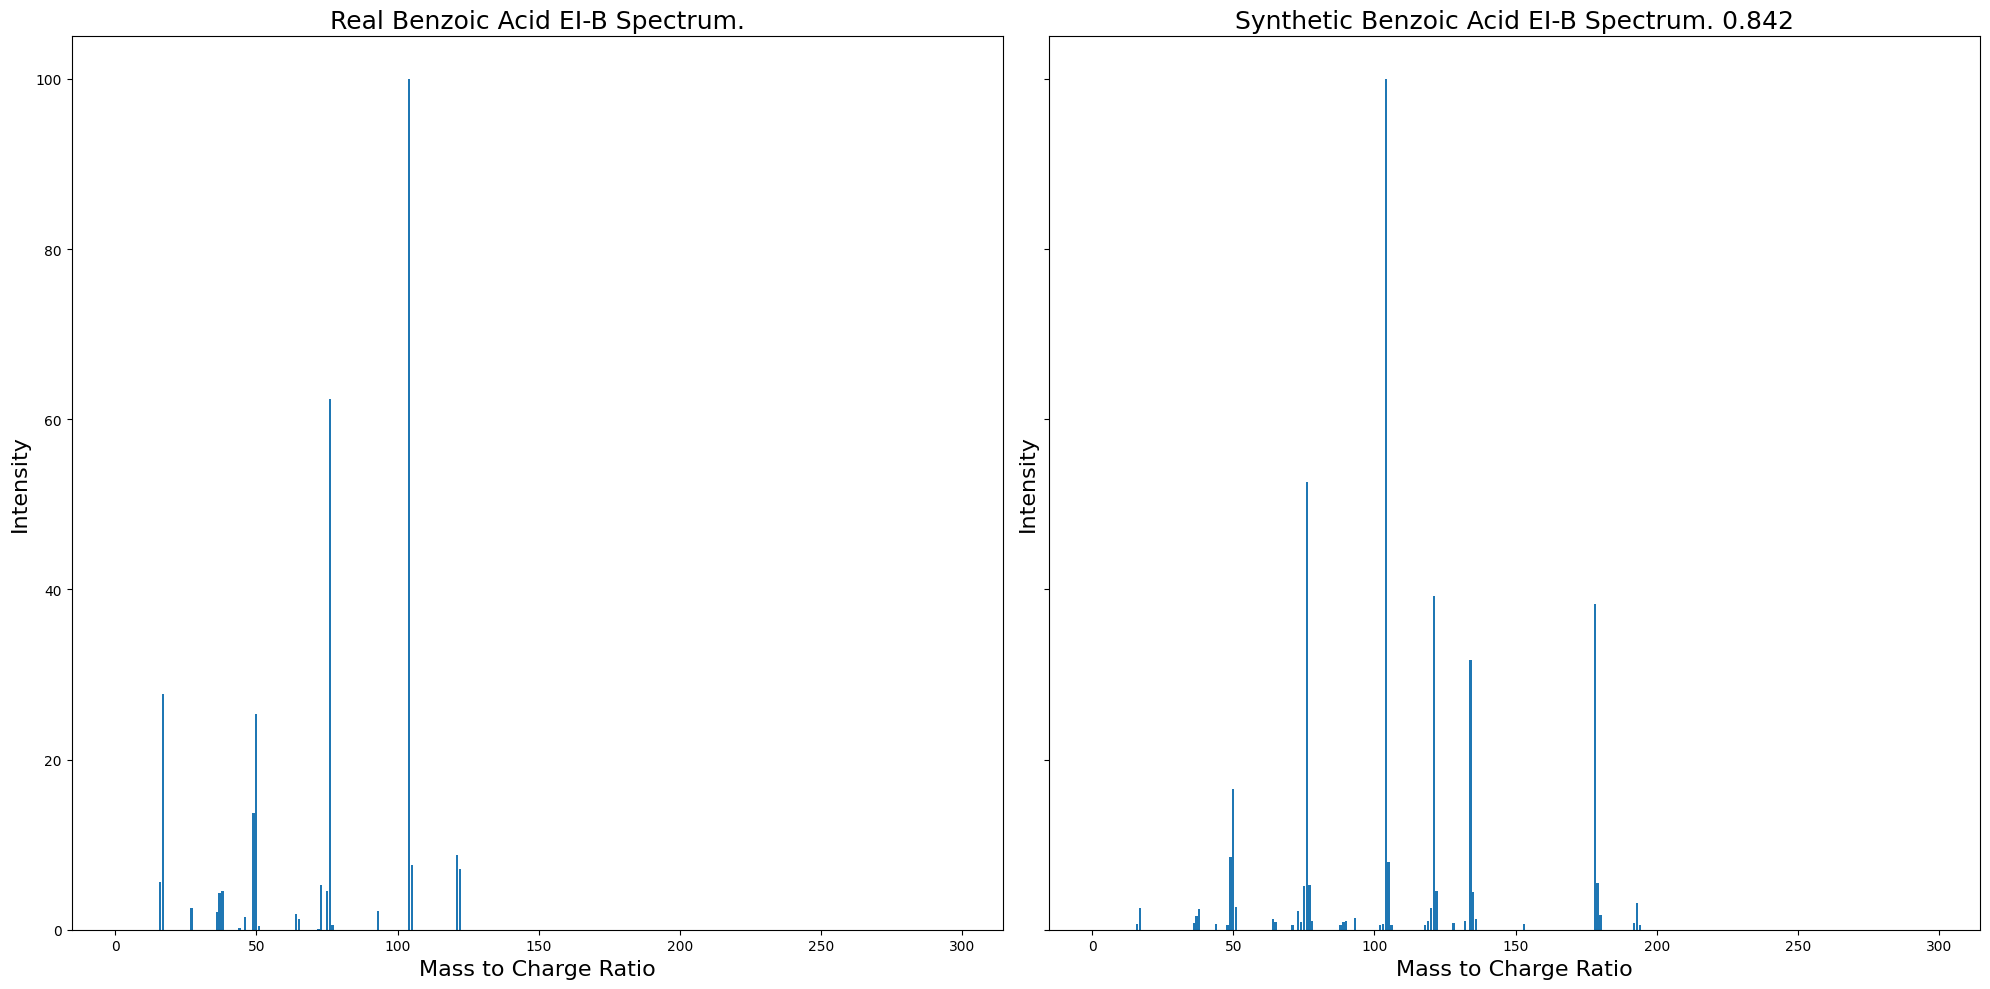

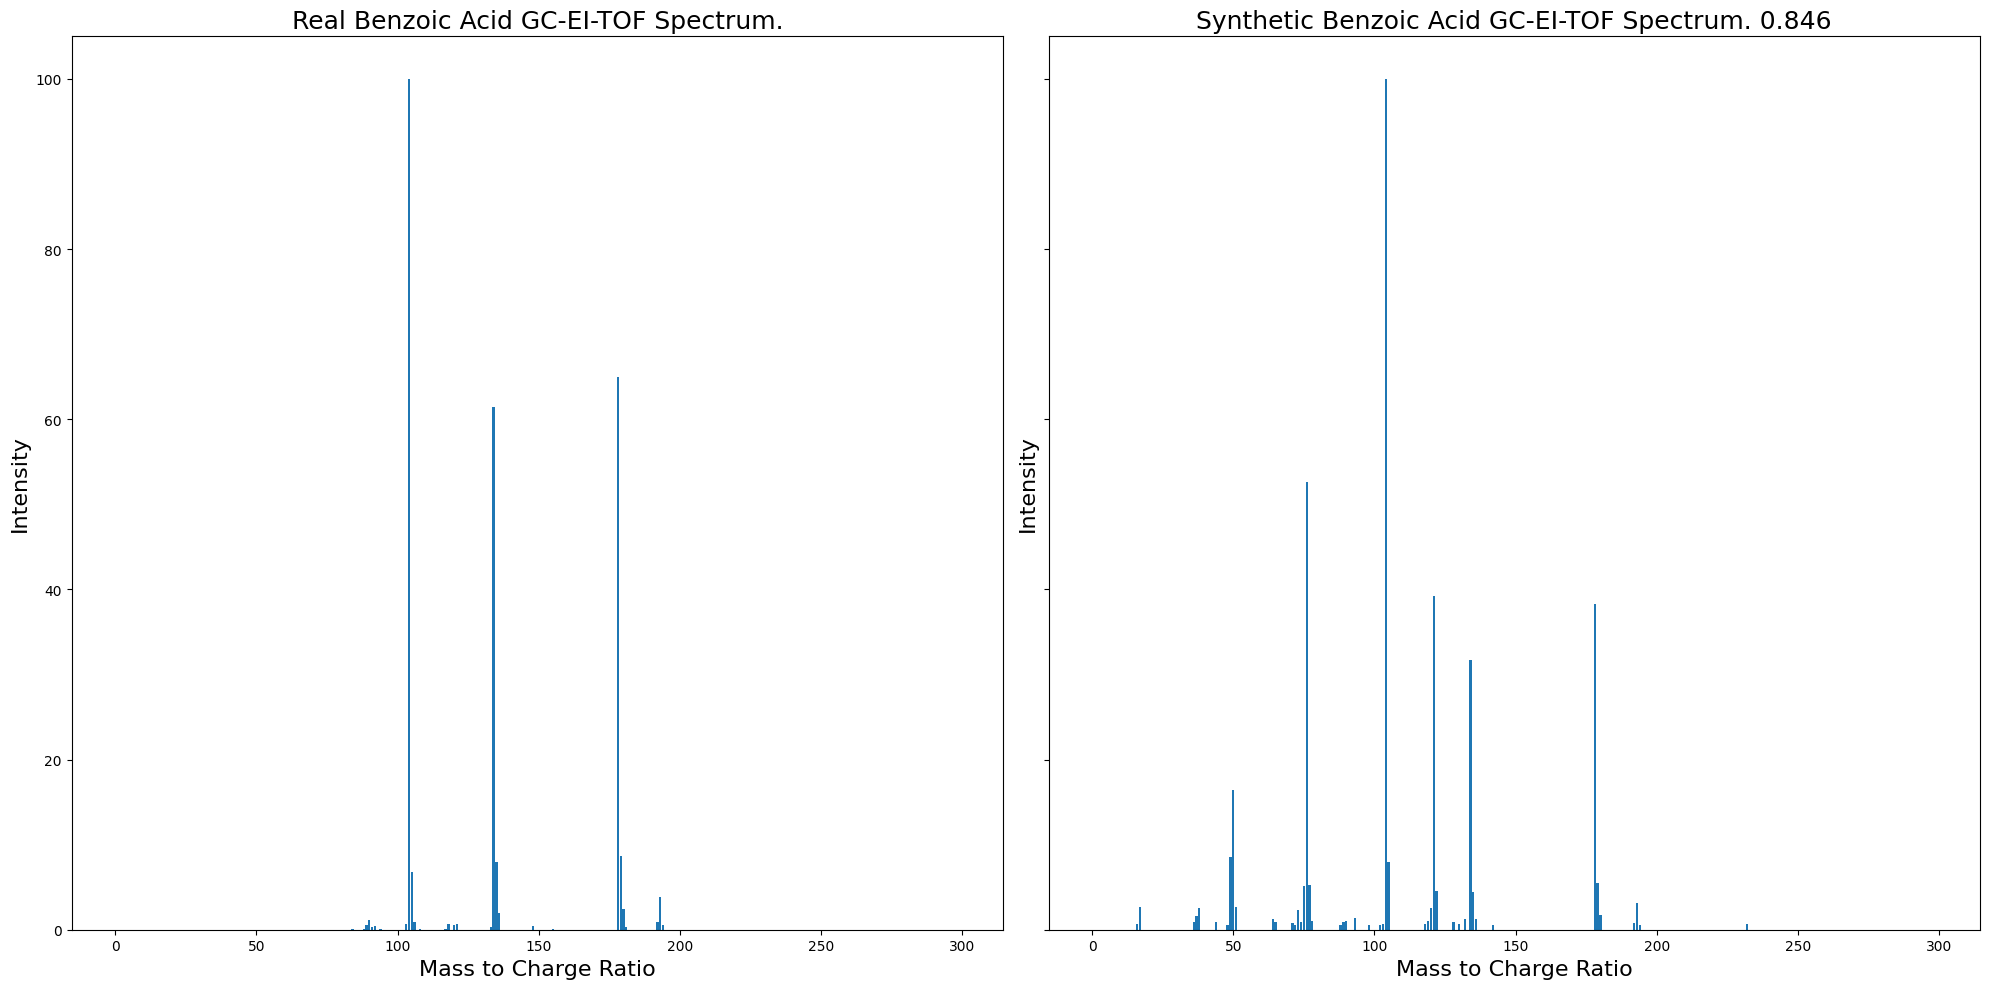

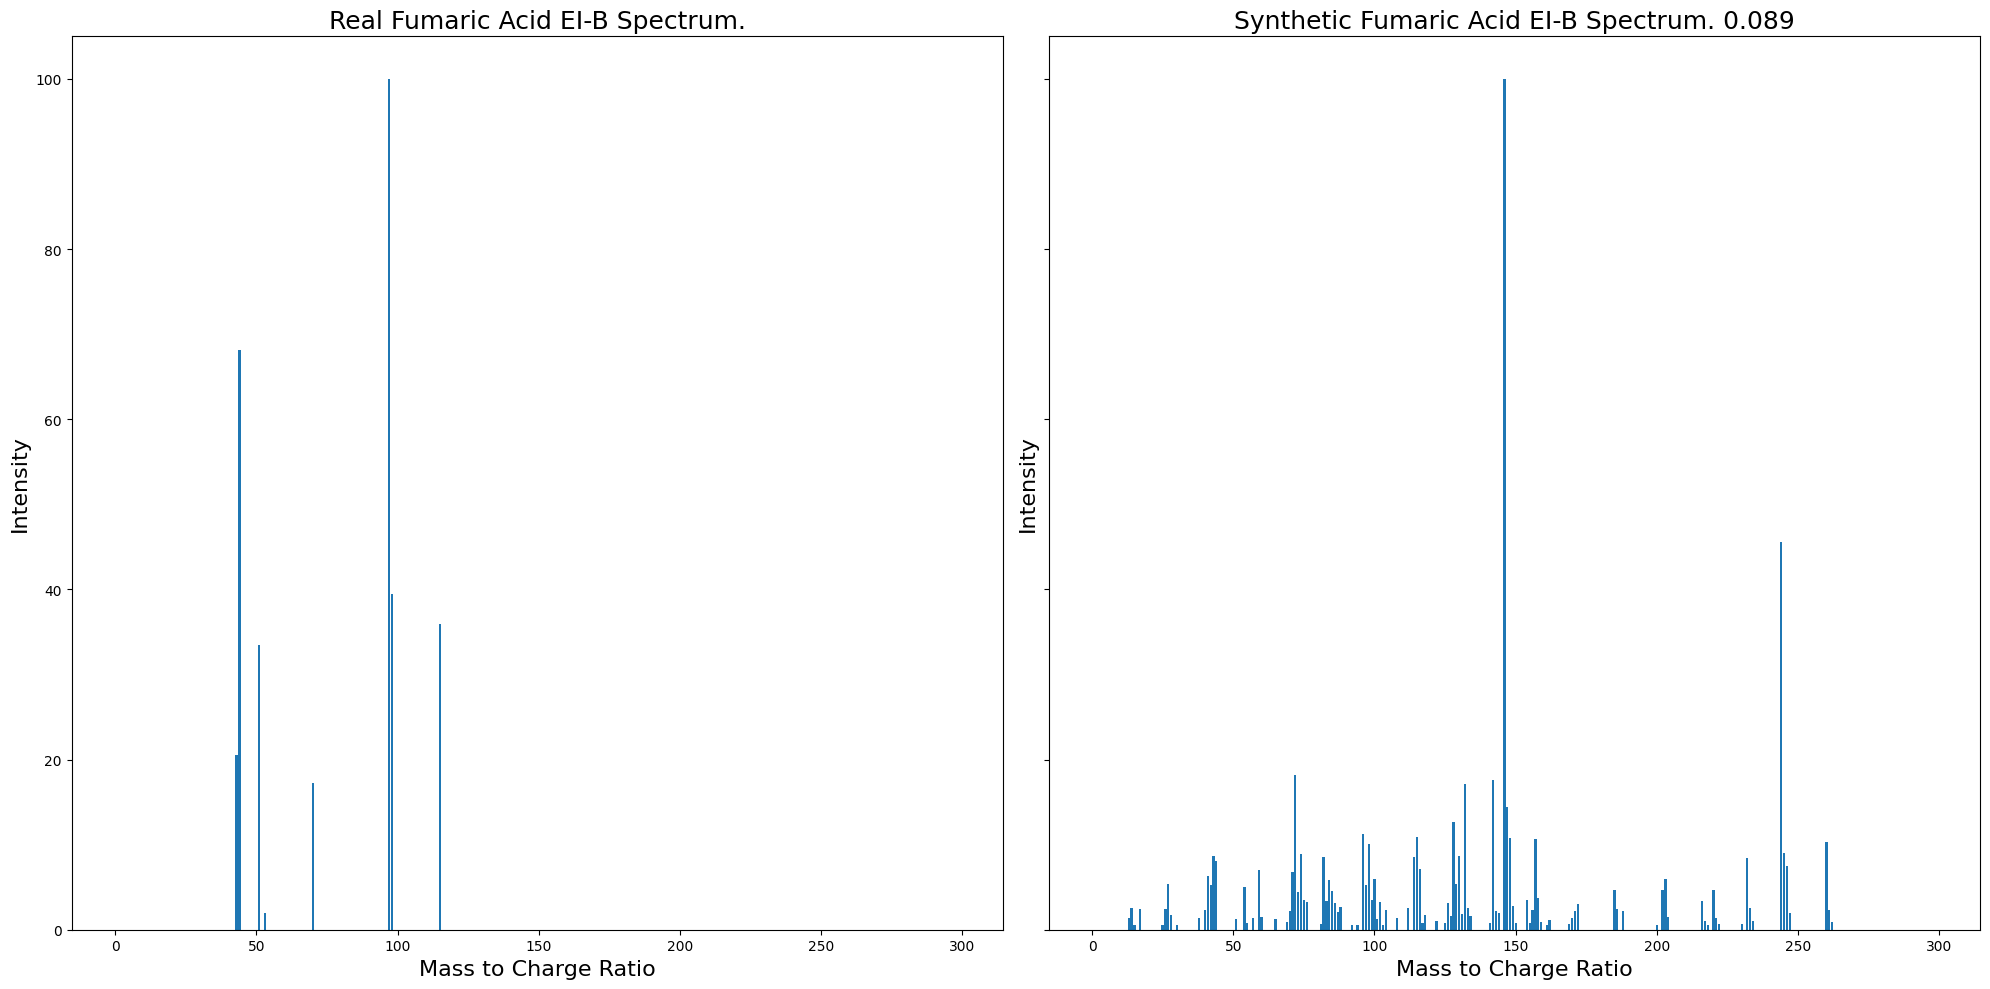

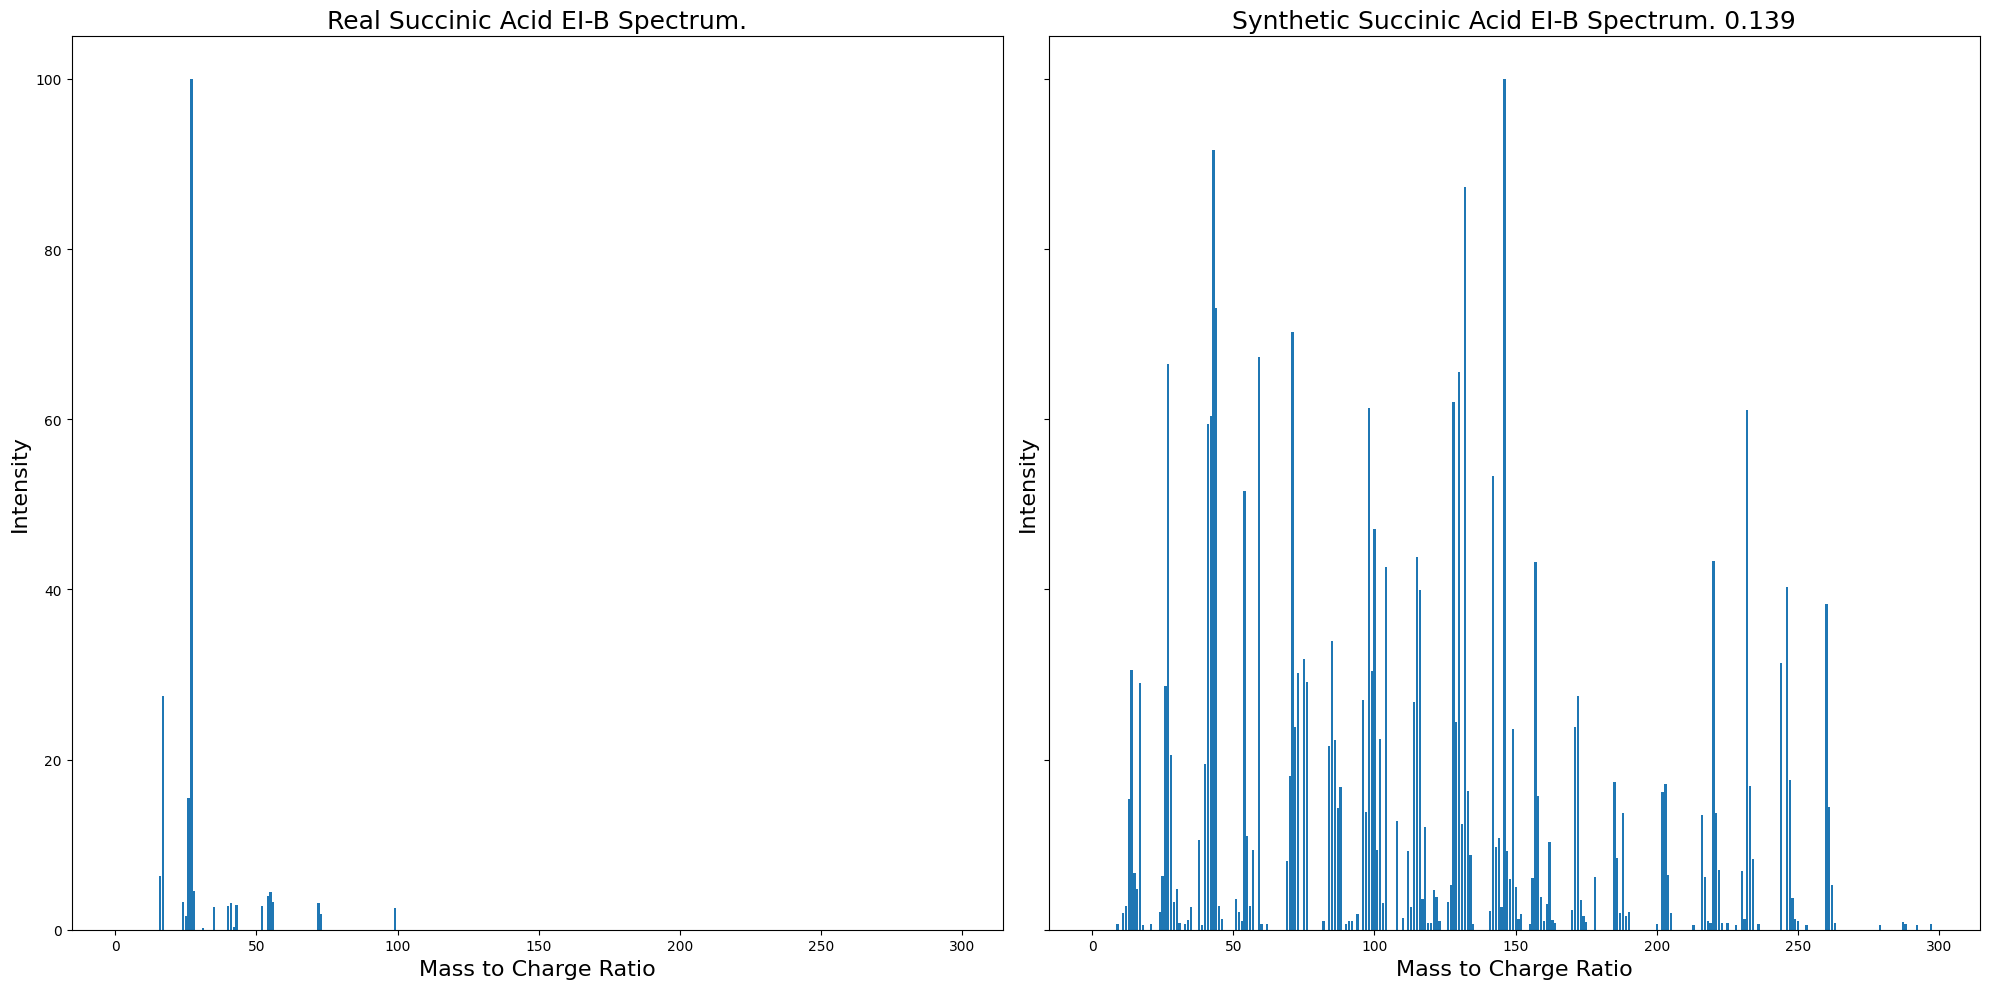

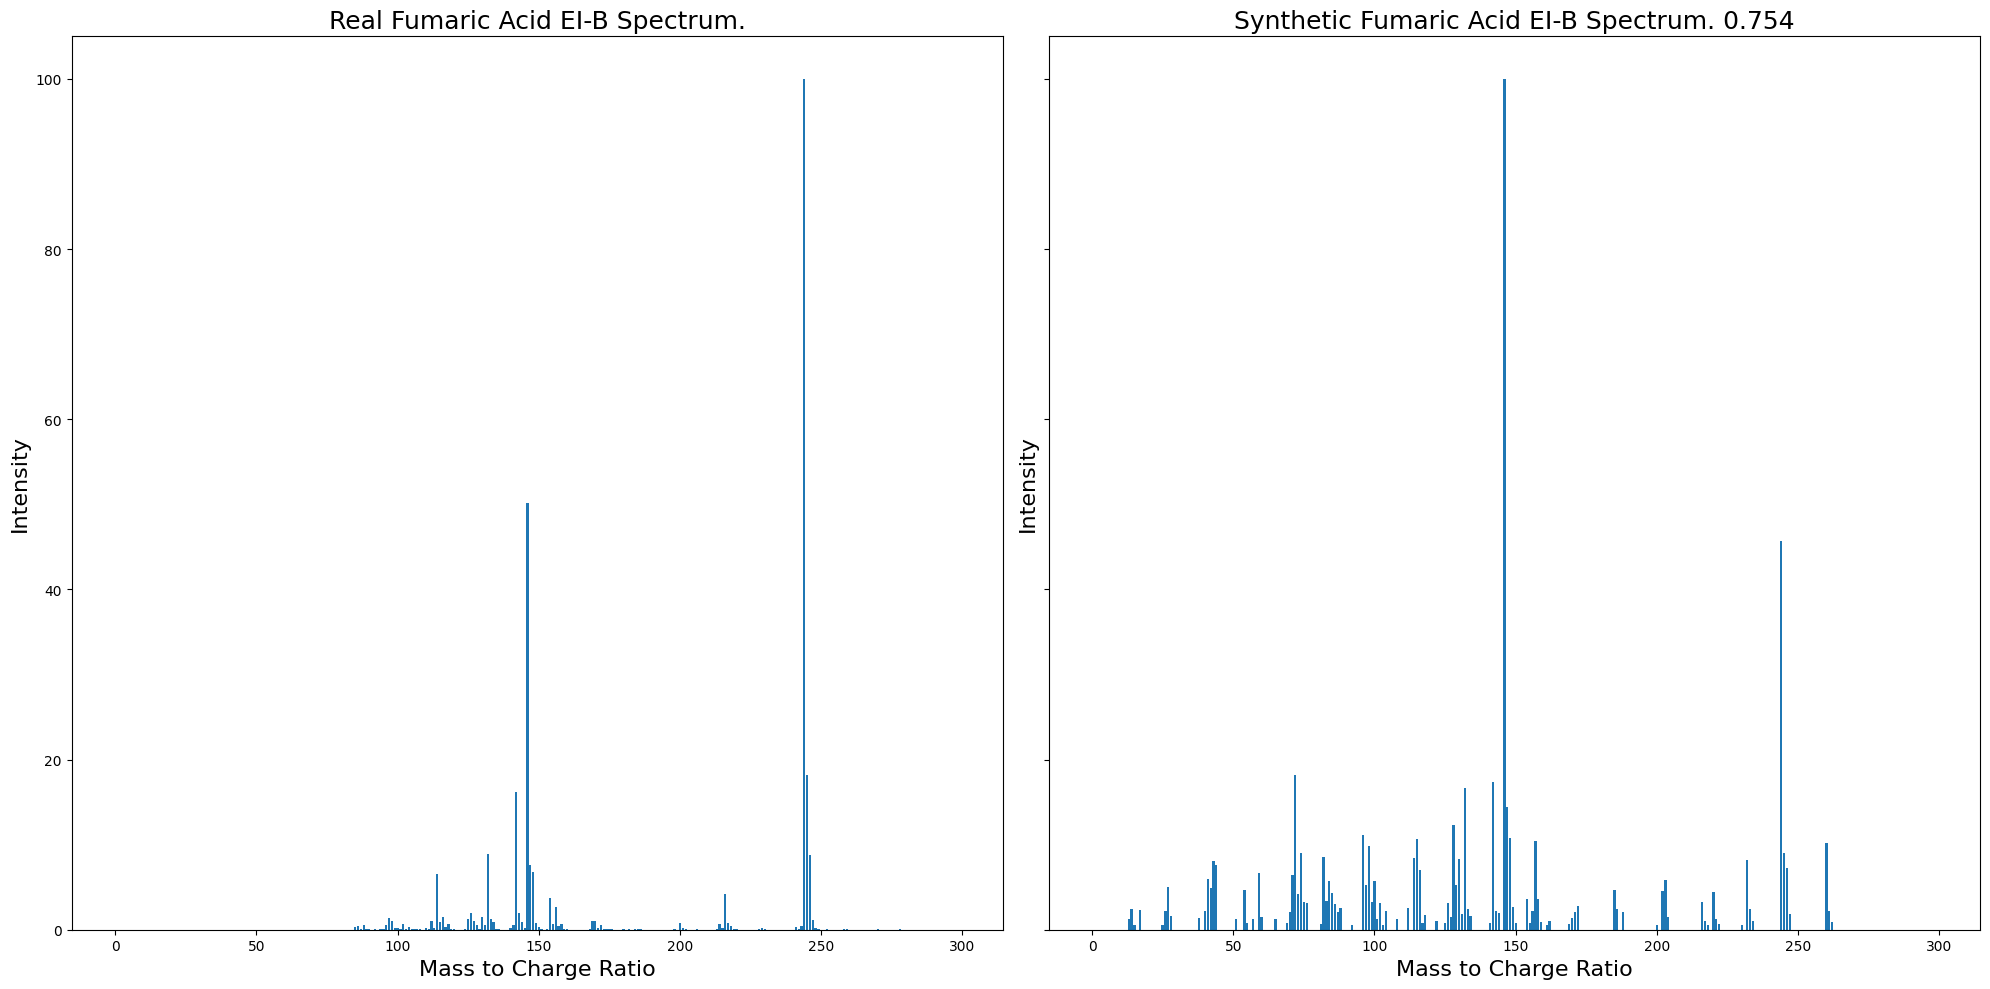

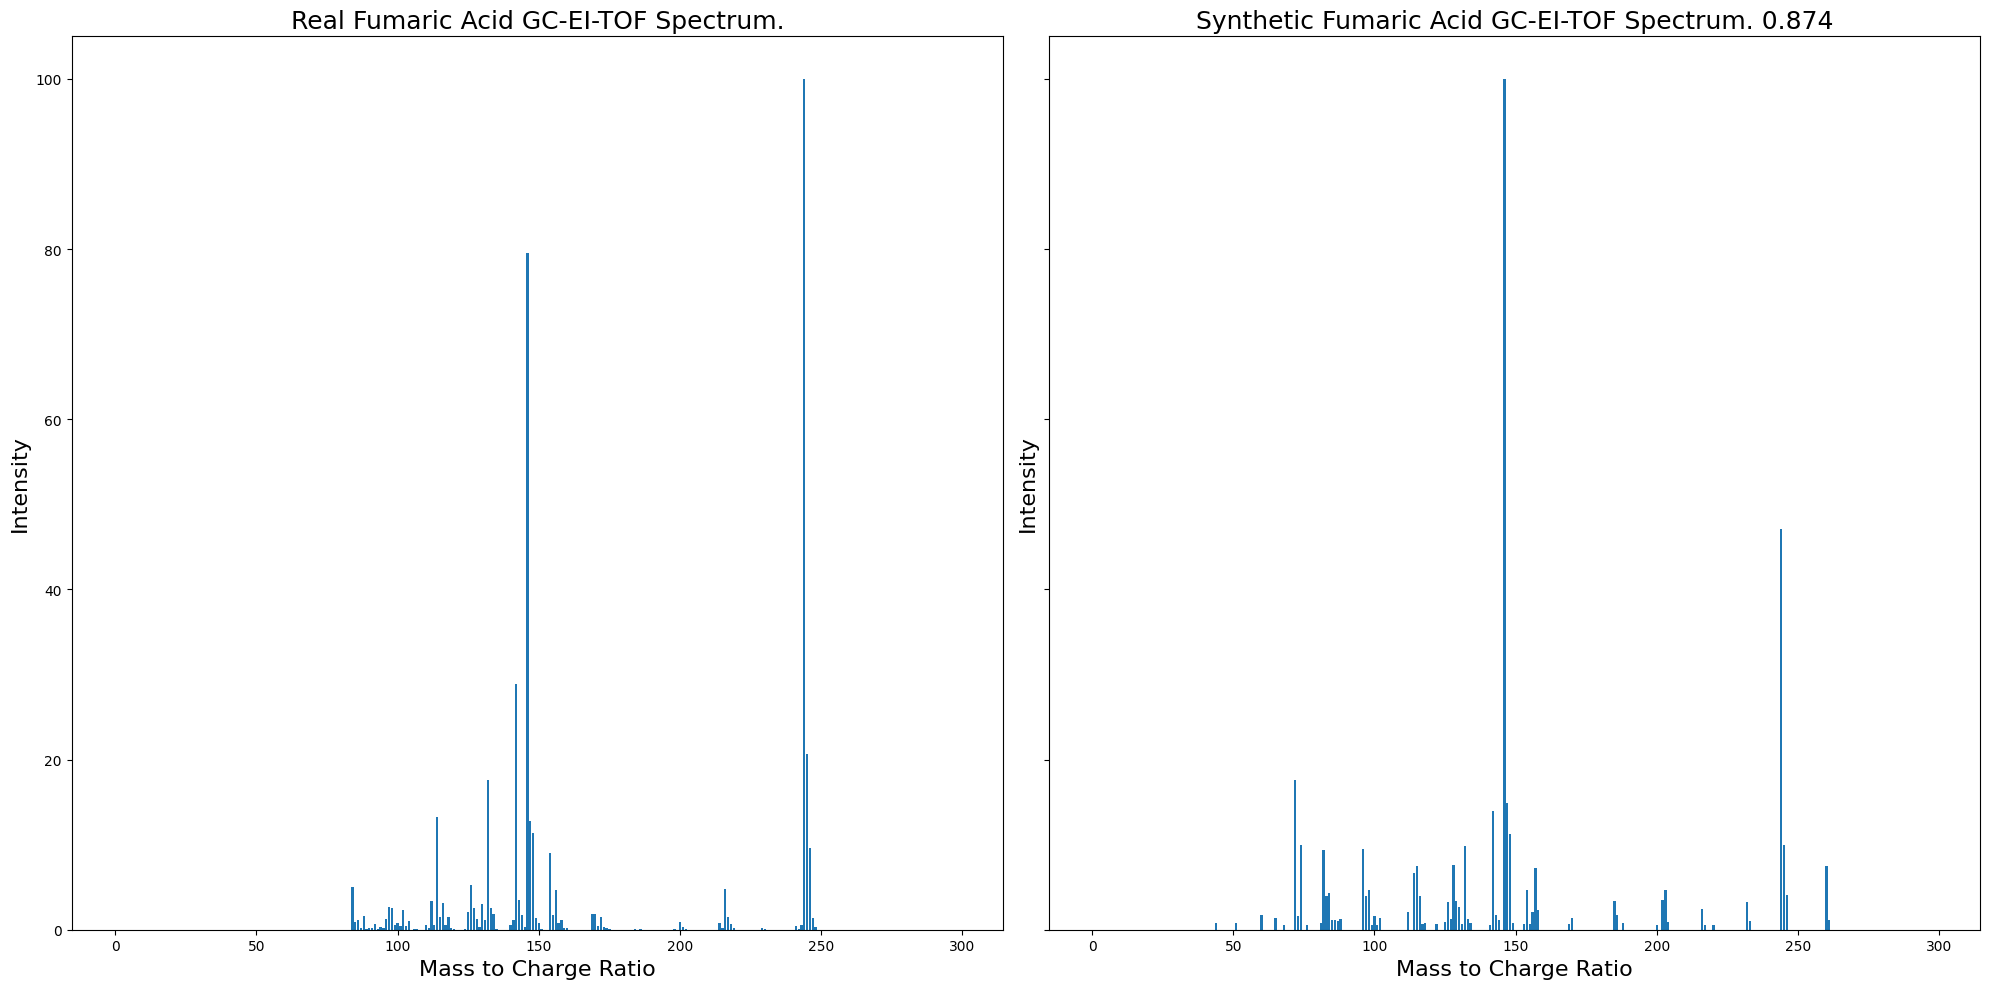

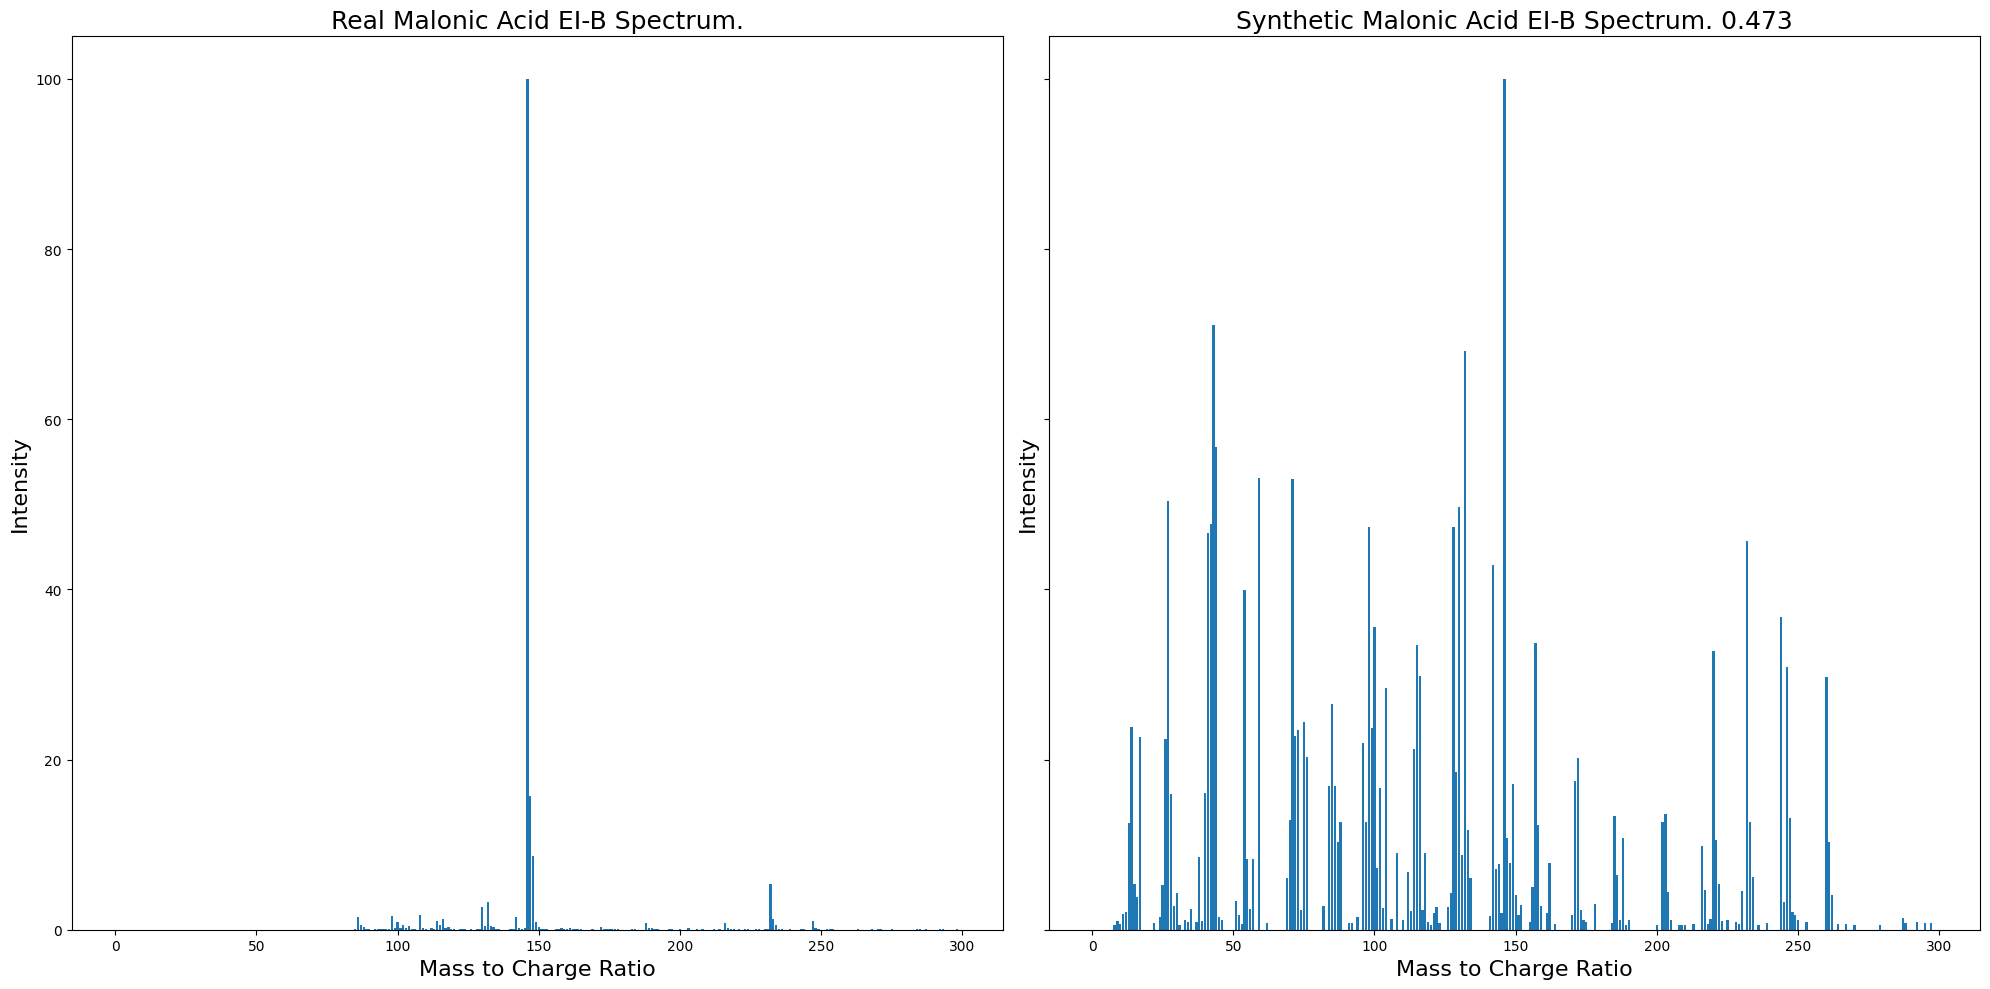

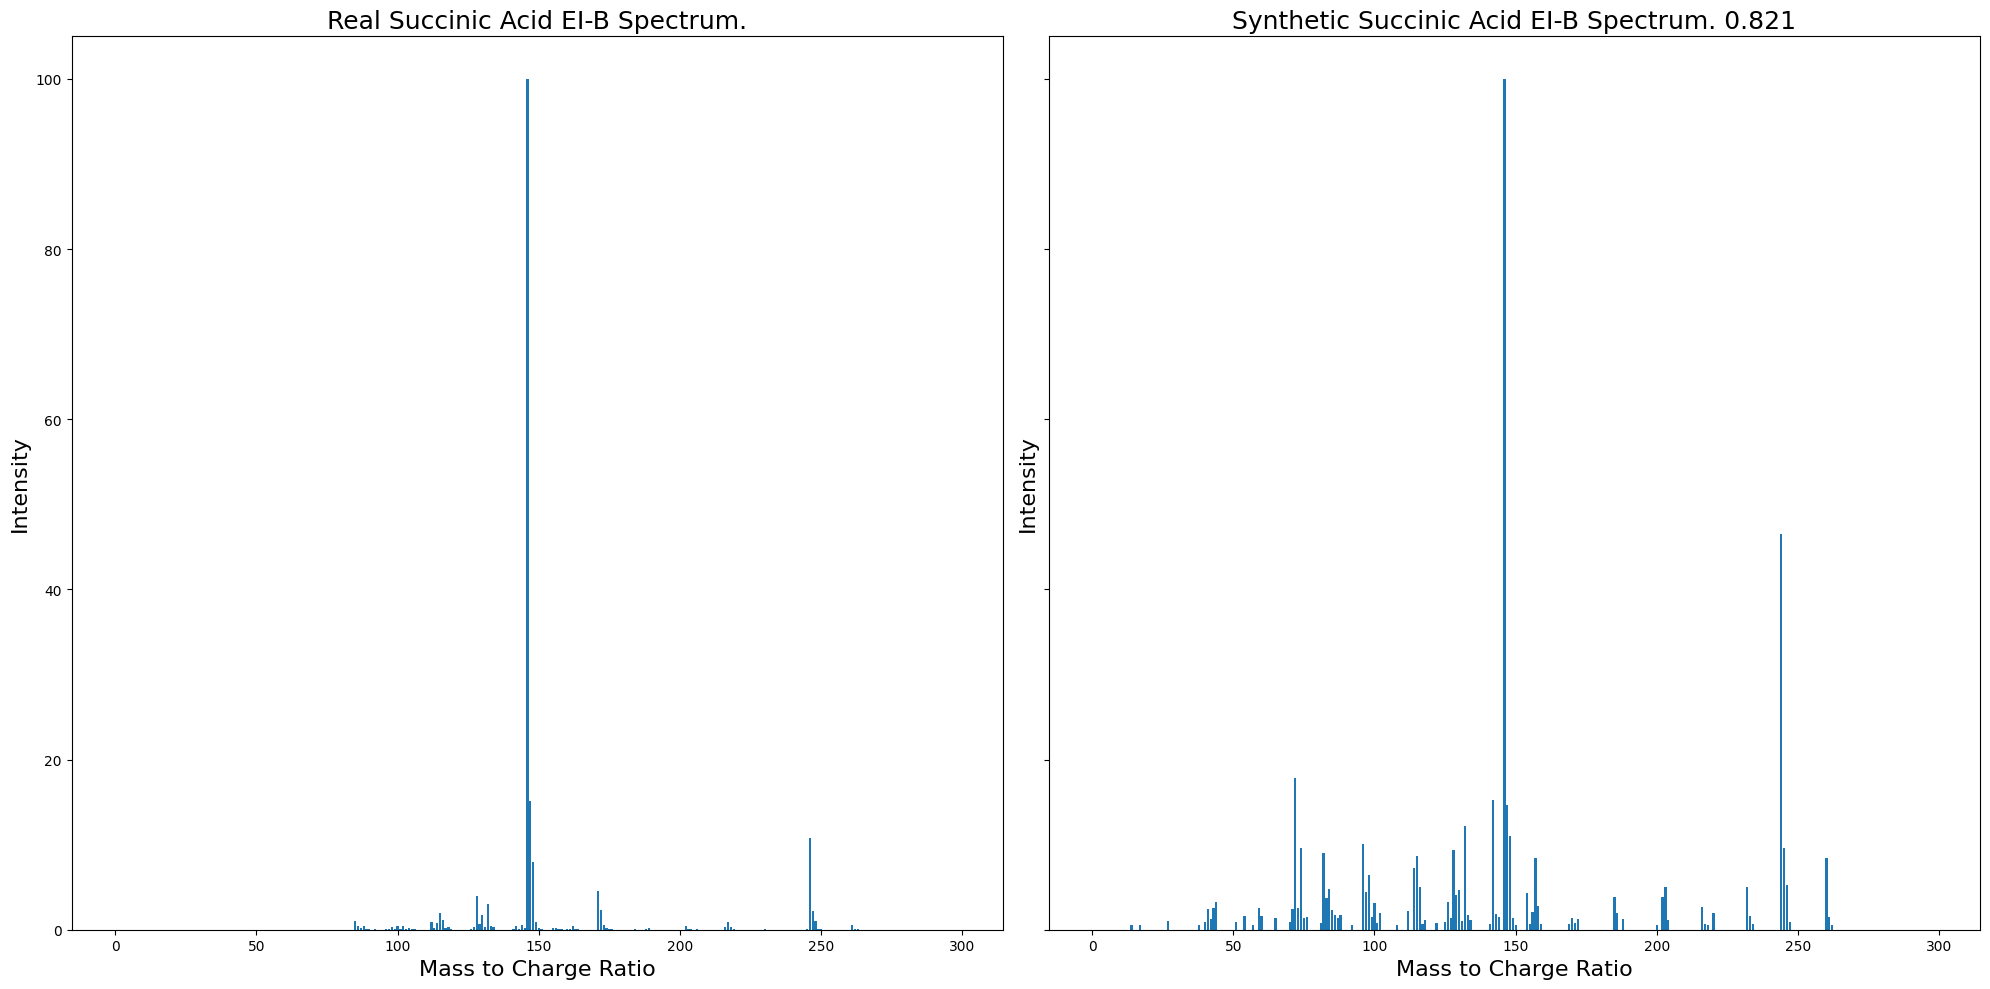

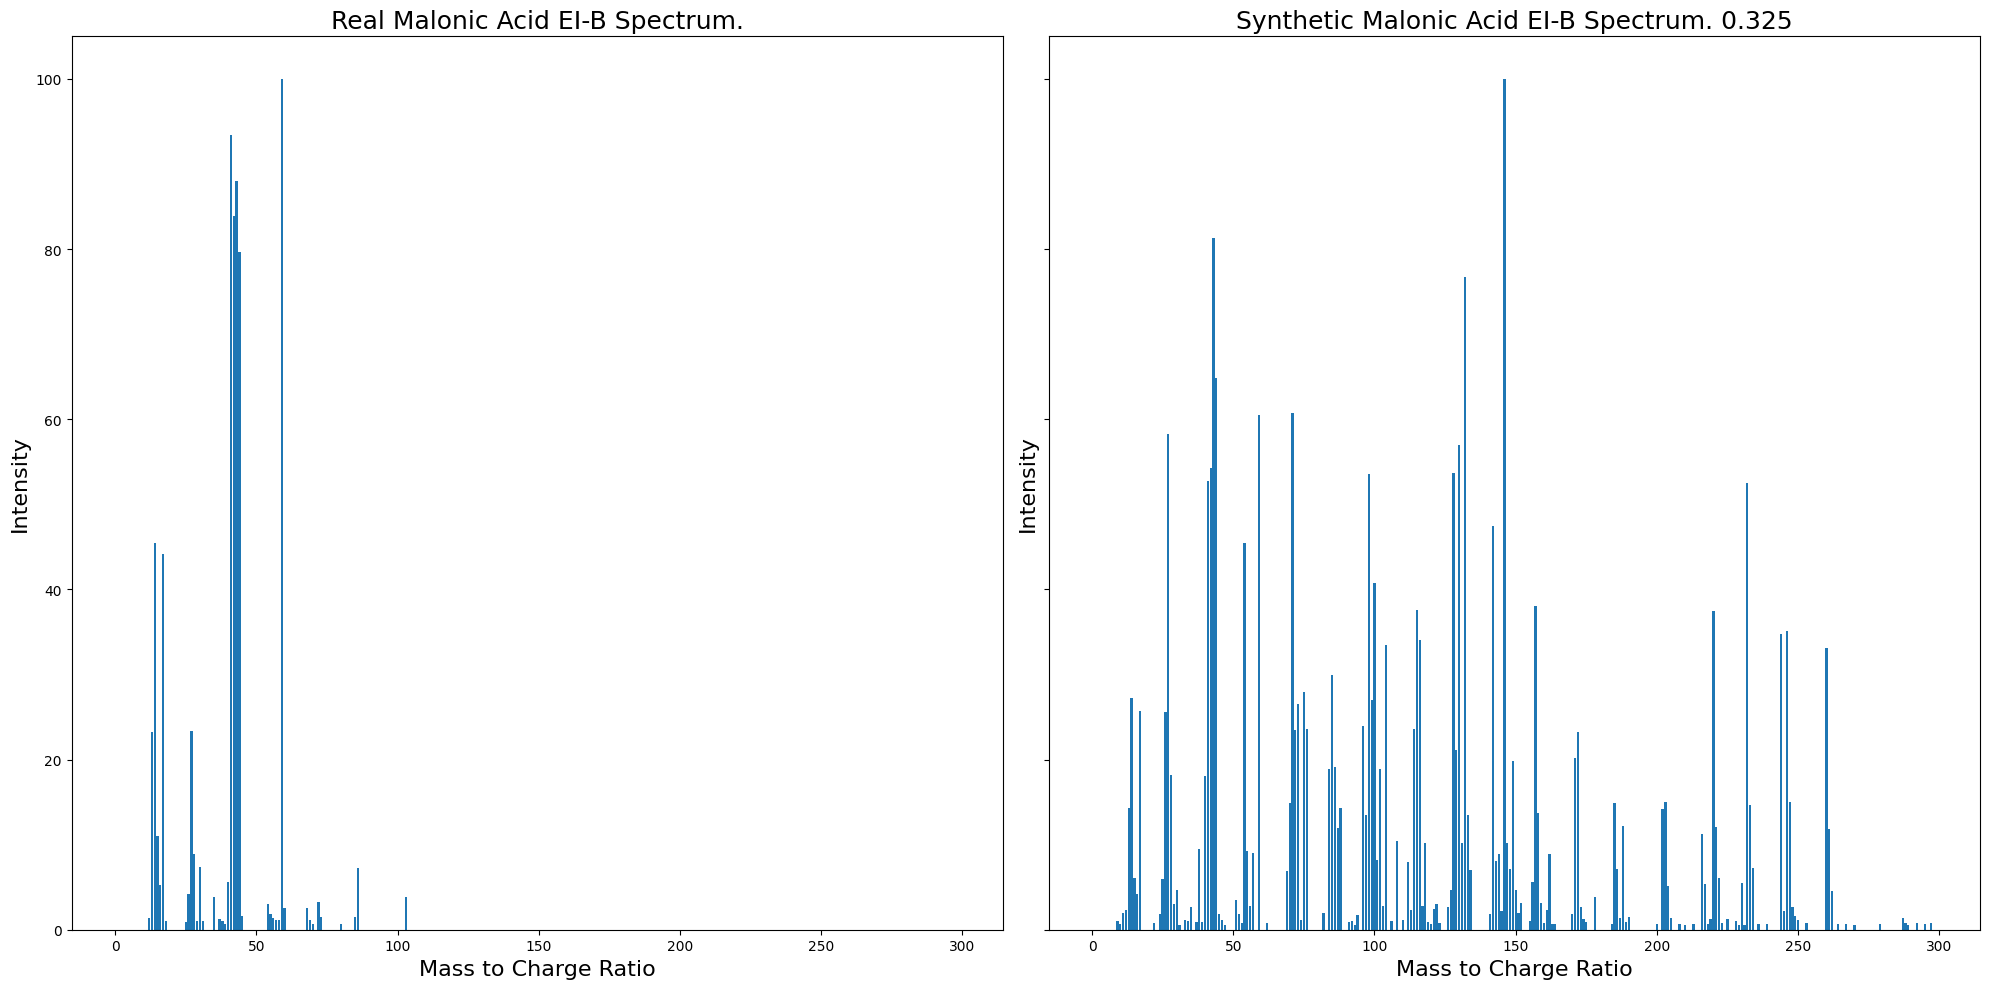

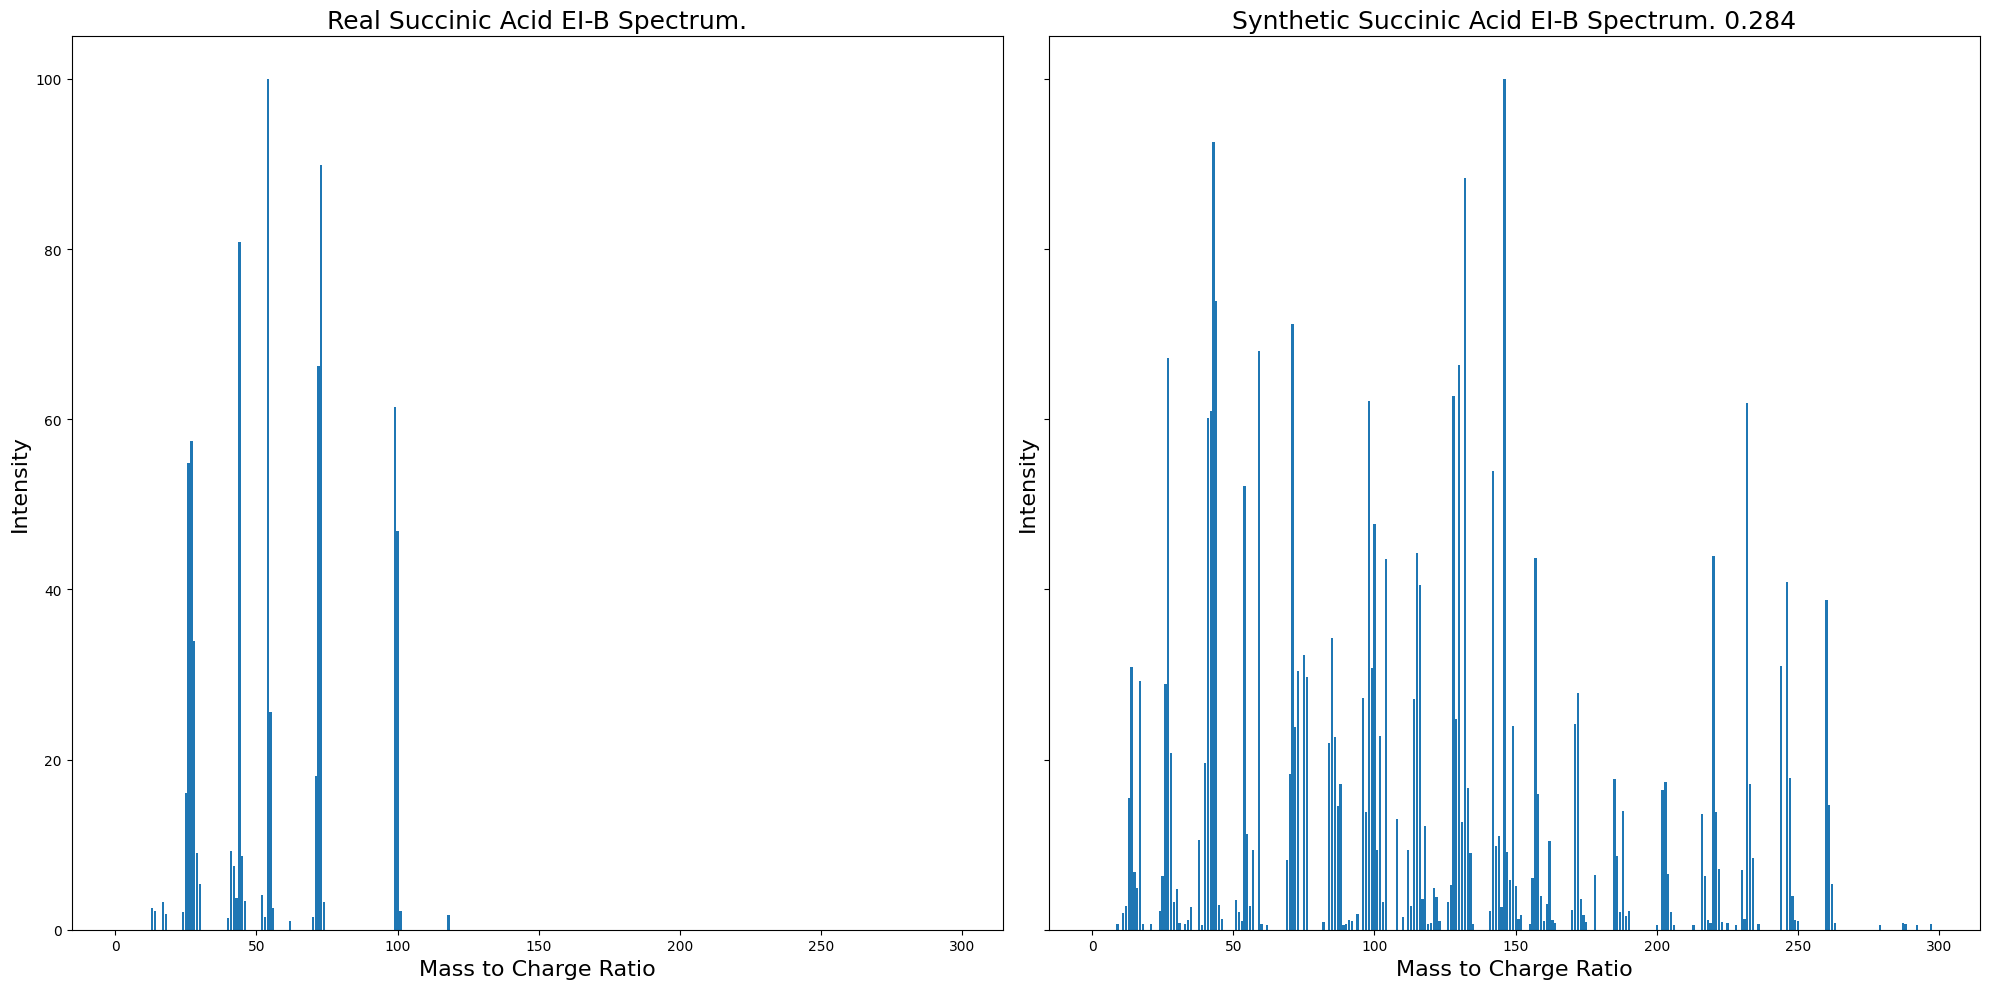

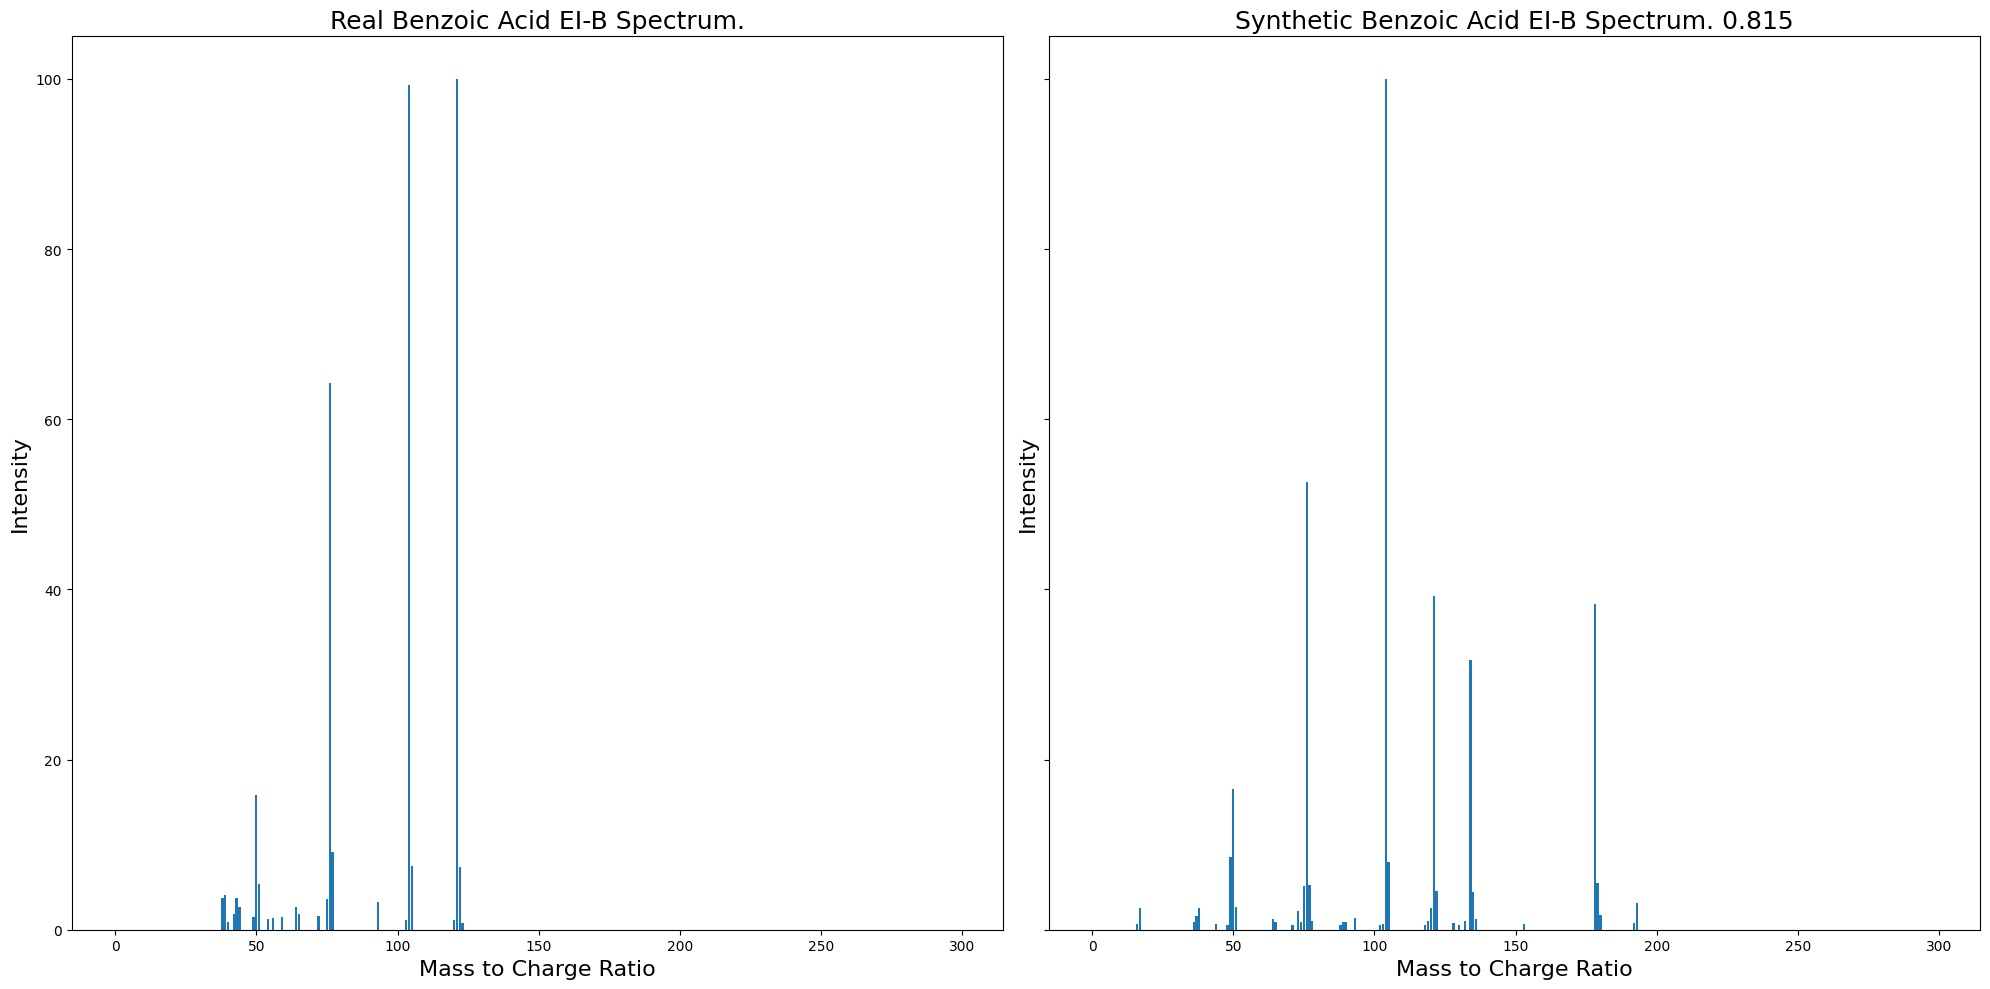

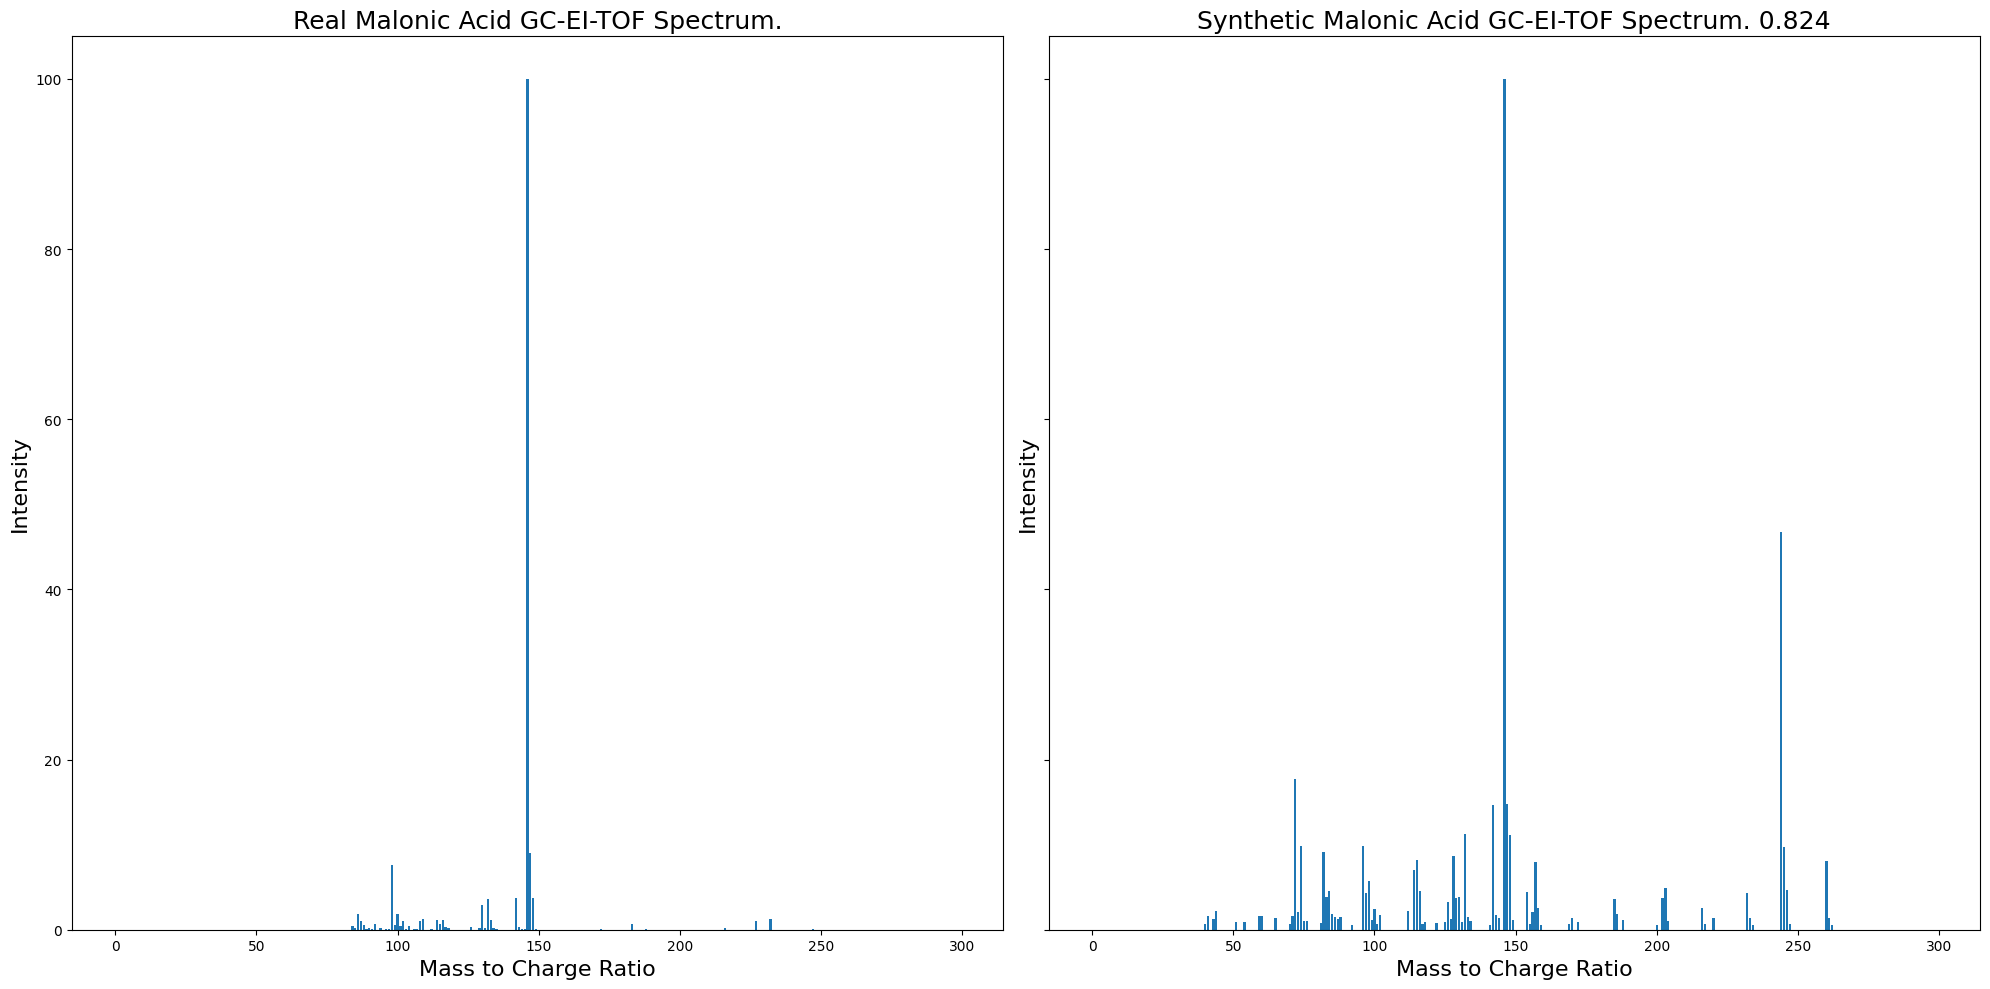

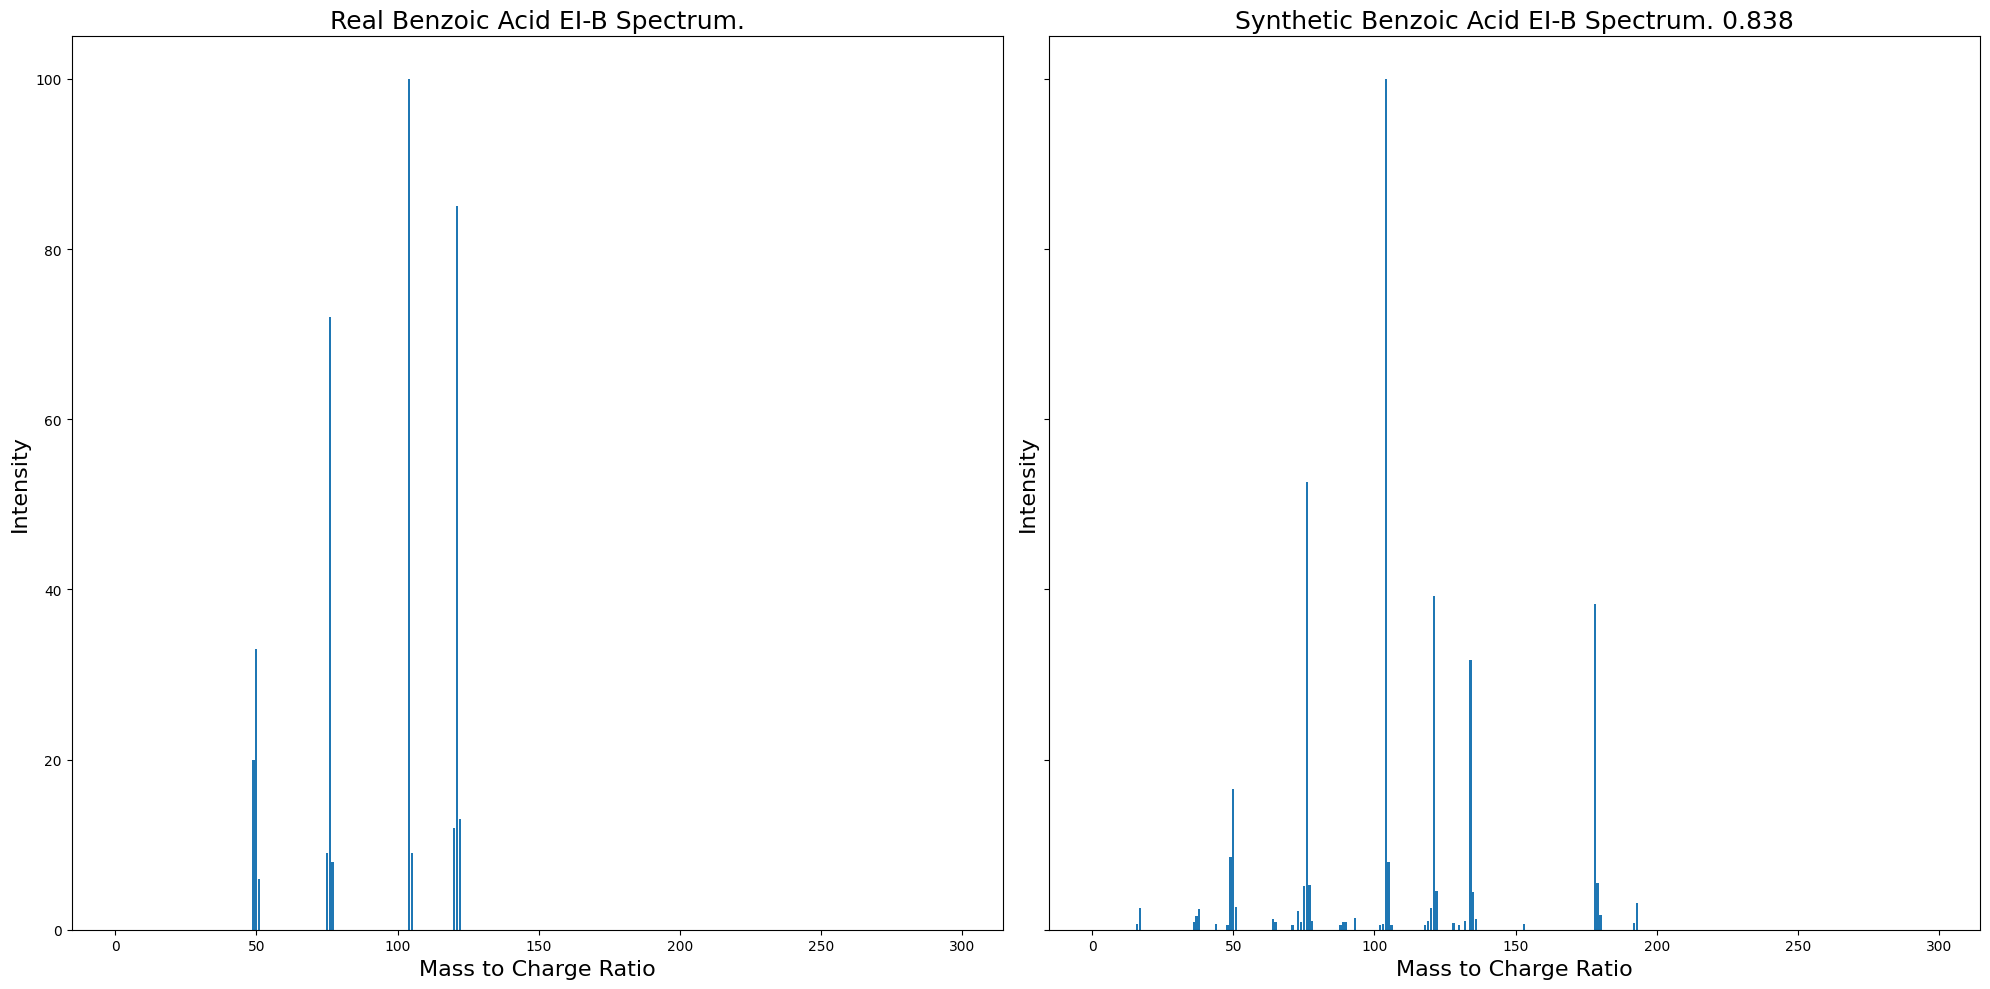

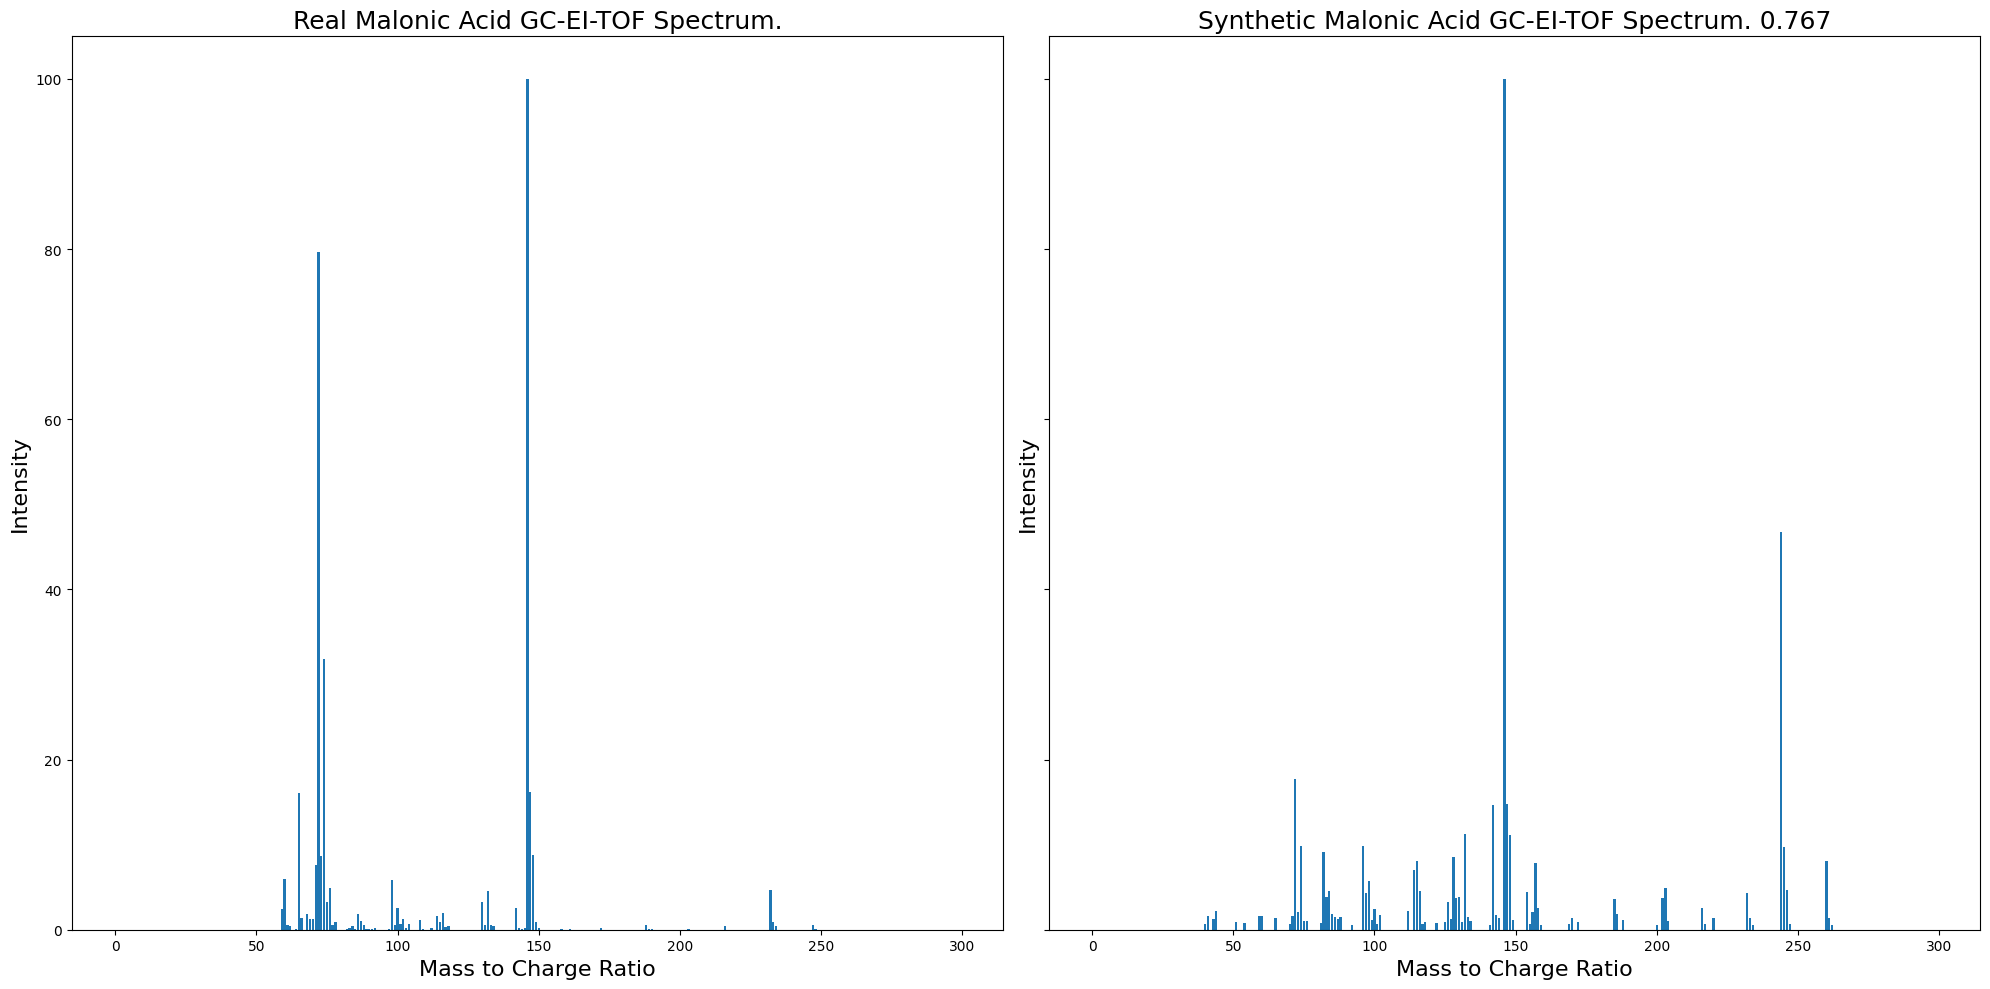

In [ ]:
instrument_names = ['Agilent GC 6890', 'CI-B', 'EI-B', 'GC 6890-5973N',
                    'GC-APCI-QTOF', 'GC-EI-Q', 'GC-EI-QQ', 'GC-EI-QqQMS',
                    'GC-EI-TOF', 'GC-MS', 'GC-MS-EI', 'single quadrupole']

instrument_labels = []
for encoding in instrument_encodings:
  name_idx = list(encoding).index(1)
  instrument_labels.append(instrument_names[name_idx])

chem_labels = []
for encoding in label_encodings:
  name_idx = list(encoding).index(1)
  chem_labels.append(all_chemical_names[name_idx])

plot_results(real_spectra, output_spectra, chem_labels, instrument_labels, idx=[0,30])

In [ ]:
generator.eval()
test_output = []
test_spectra = []
test_loss = 0
test_embeddings = []
test_labels = []
test_instruments = []

with torch.no_grad():
  for batch, encodings in x_test:
    test_instrument_encodings = []
    test_label_encodings = []
    for encoding in encodings:
      test_instrument_encodings.append(list(encoding[-12:]))
      test_instruments.append(list(encoding[-12:]))
      test_label_encodings.append(encoding[:-12])

    encoder_output = encoder(batch)
    embeddings_with_conditions = []

    for instrument, embedding in zip(test_instrument_encodings, encoder_output):
      emb_w_conditions = torch.cat((torch.Tensor(embedding).detach(), torch.Tensor(instrument)))
      embeddings_with_conditions.append(list(emb_w_conditions))

    embeddings_with_conditions = torch.tensor(embeddings_with_conditions, dtype=torch.float)
    test_instrument_encodings = torch.tensor(test_instrument_encodings, dtype=torch.float)
    full_batch = TensorDataset(torch.Tensor(embeddings_with_conditions), test_instrument_encodings)
    full_batch = DataLoader(dataset=full_batch, batch_size=batch_size)

    for data, _ in full_batch:
      output = generator(data.detach())

    mse = generator.criterion(output, batch)
    test_loss += mse

    for fake_spec, real_spec in zip(output, batch):
      max_val = max(fake_spec)
      scaled_spec = (fake_spec/max_val)*100
      test_output.append(scaled_spec)
      test_spectra.append(real_spec)
    for embedding in encoder_output:
      test_embeddings.append(embedding.detach().numpy())
    for label in test_label_encodings:
      test_labels.append(label)

    average_loss = test_loss/len(x_test)
    print(f'Test loss: ', average_loss)

Test loss:  tensor(5.7338)


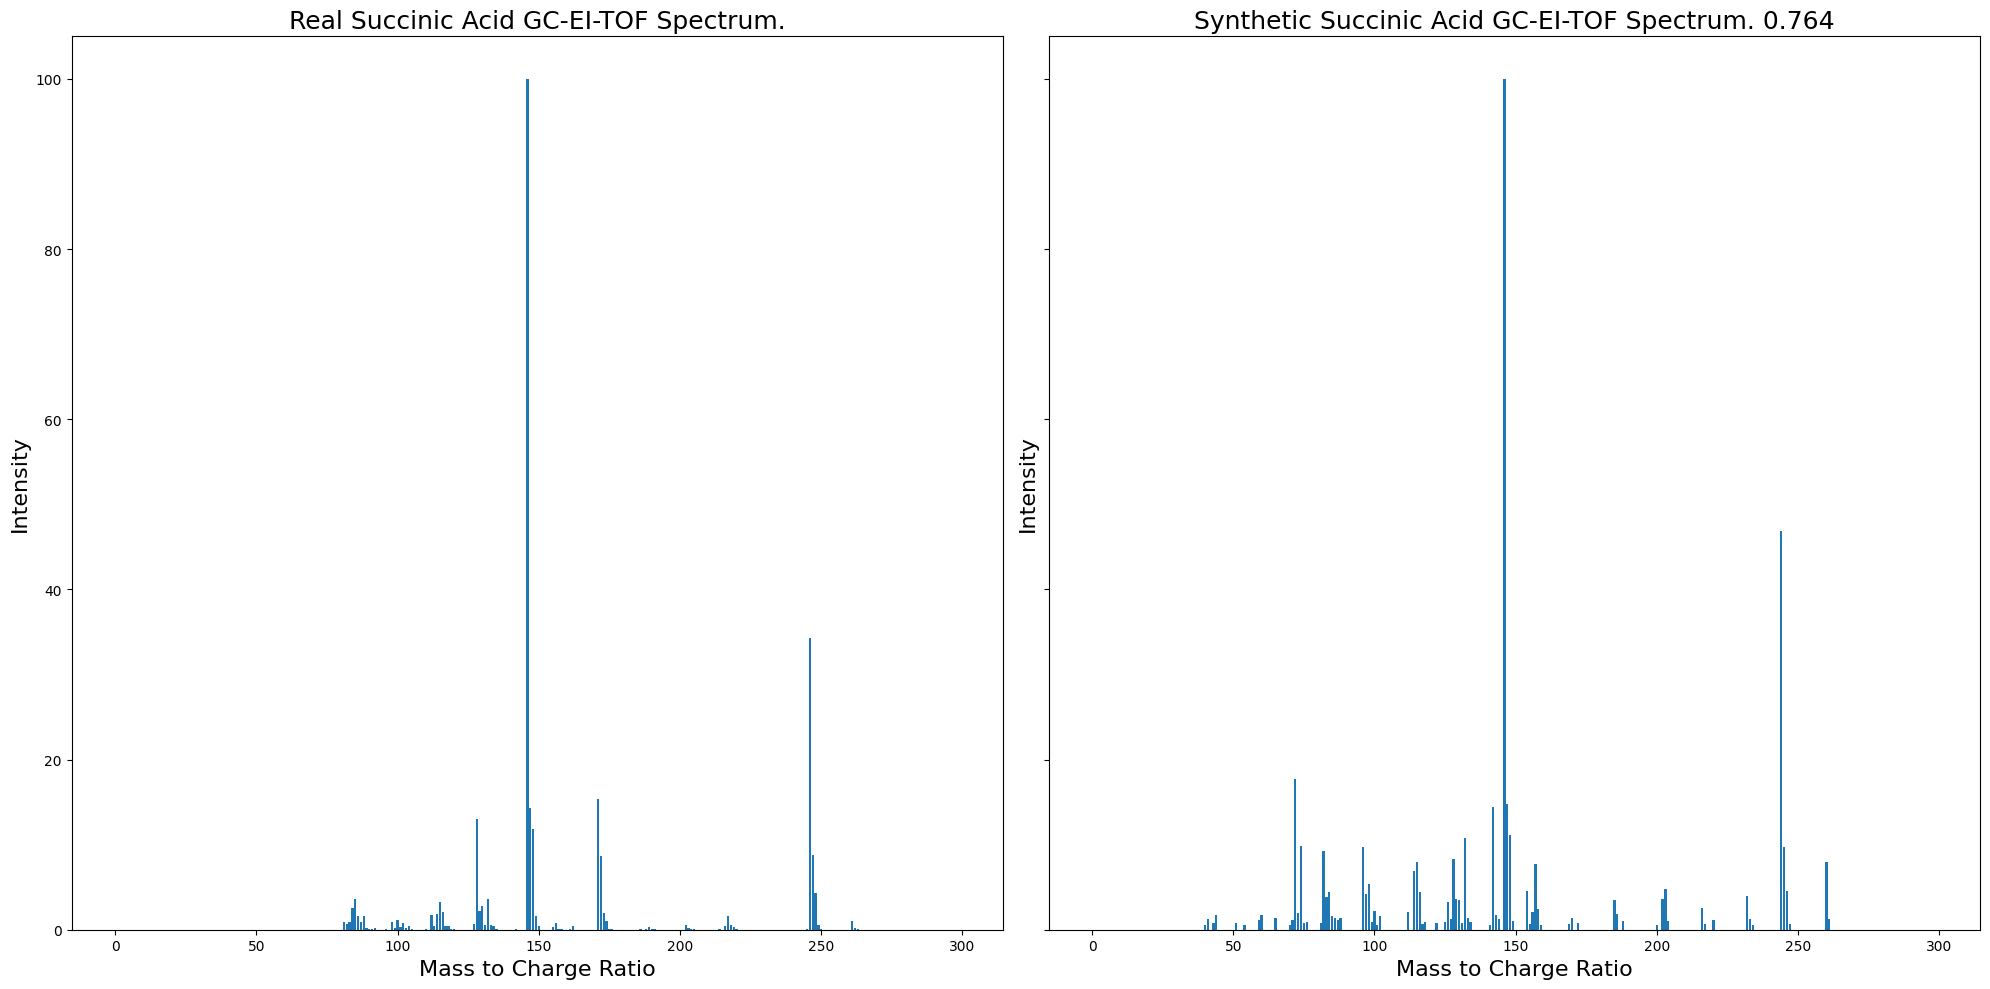

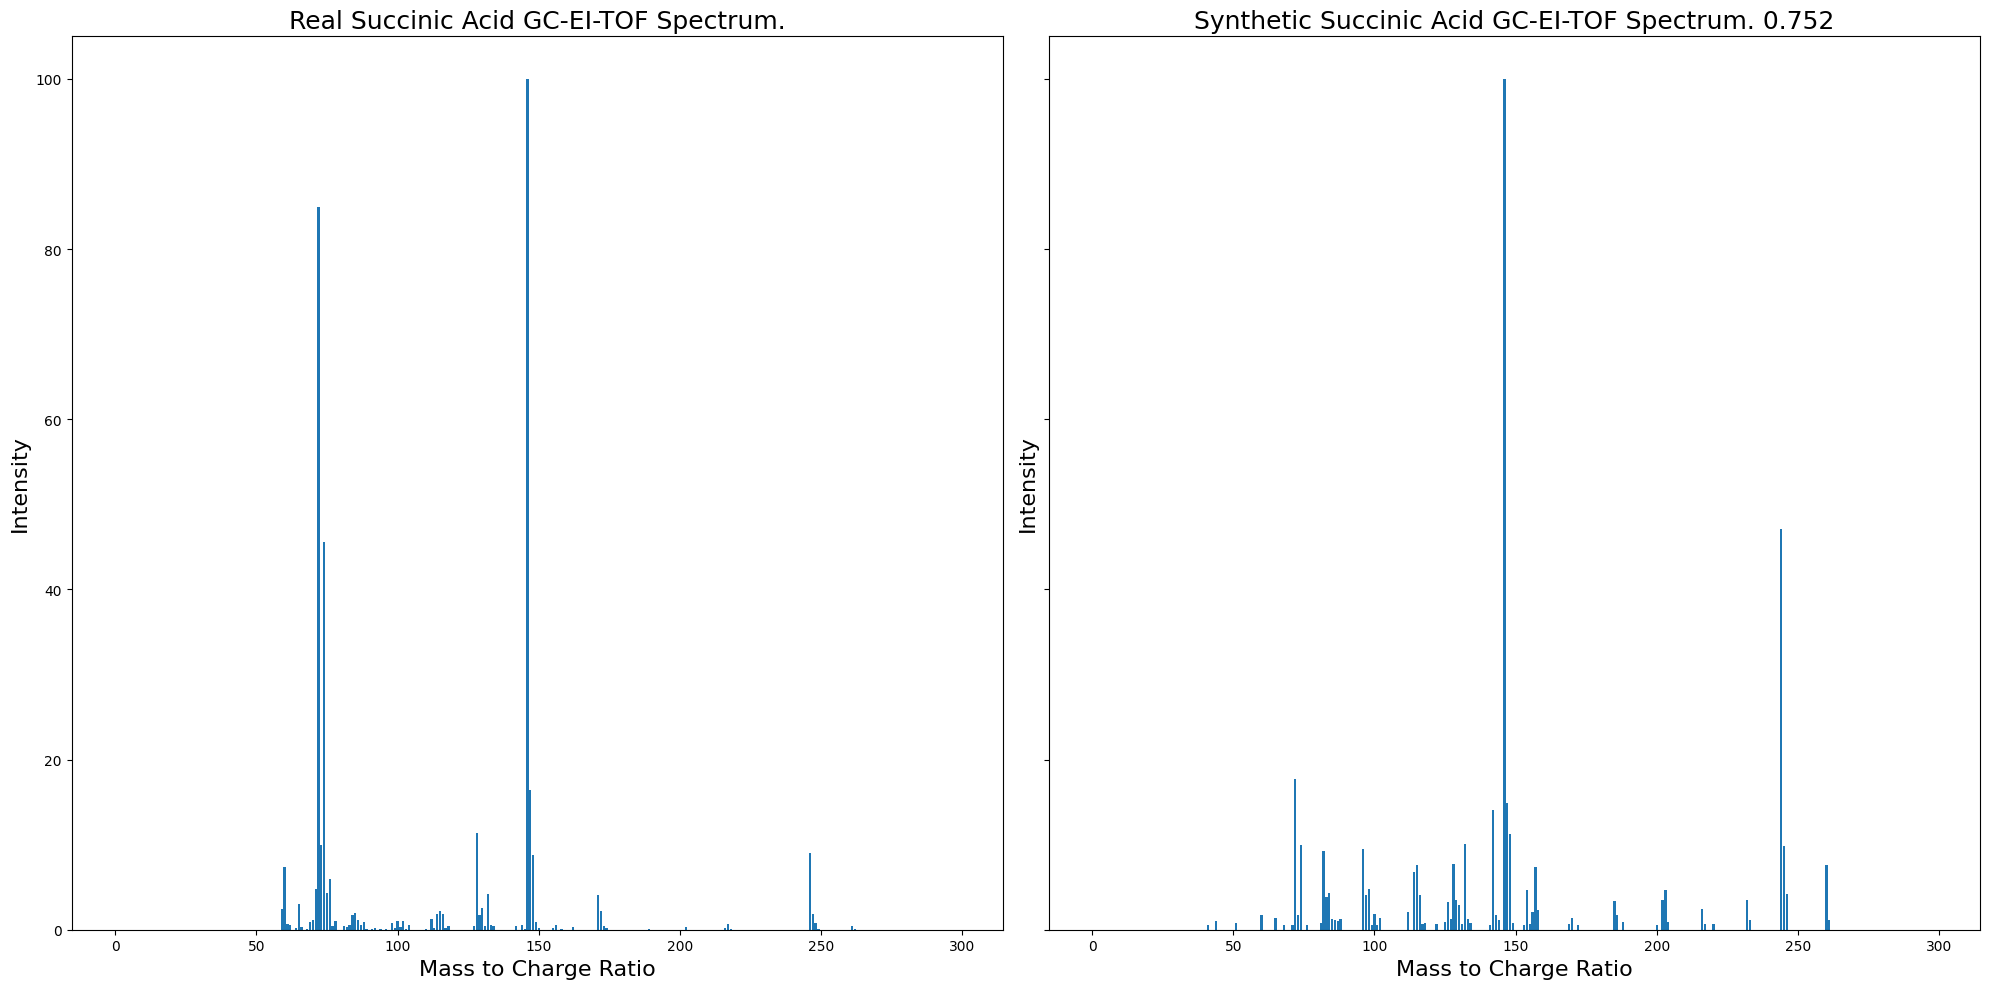

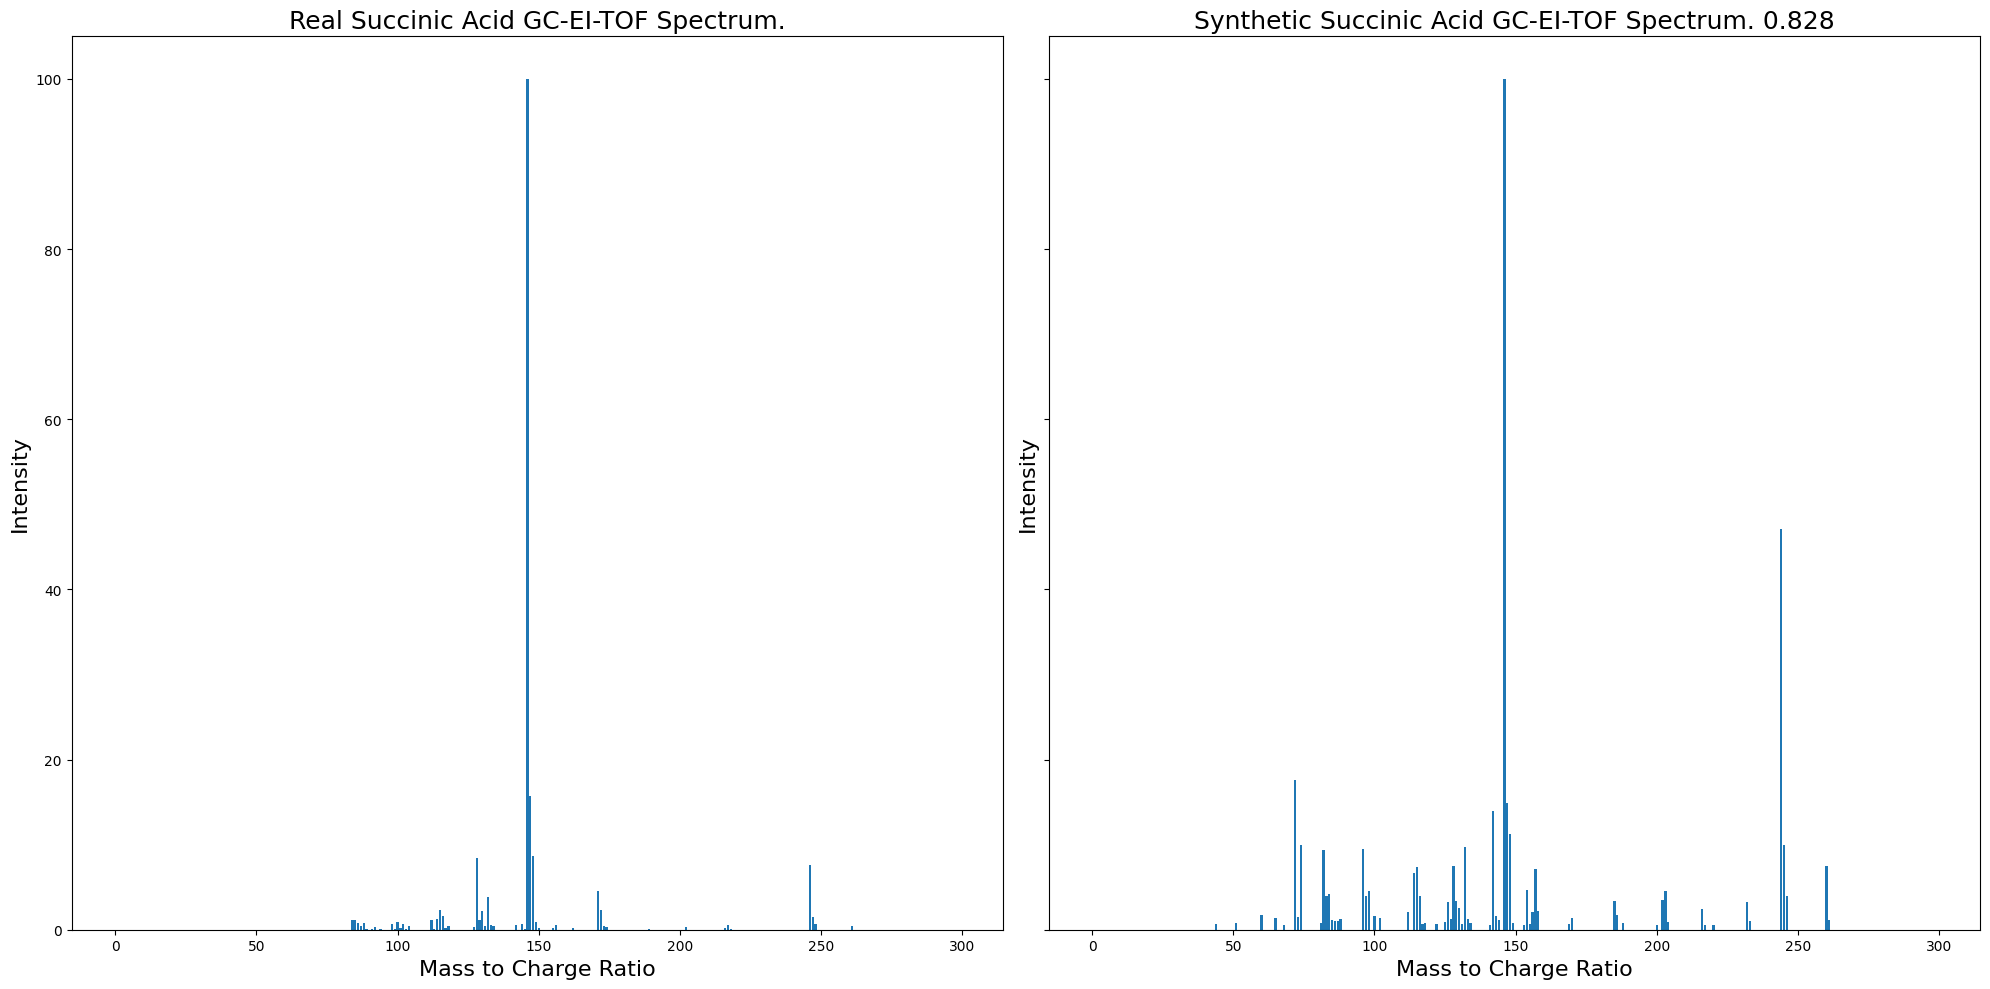

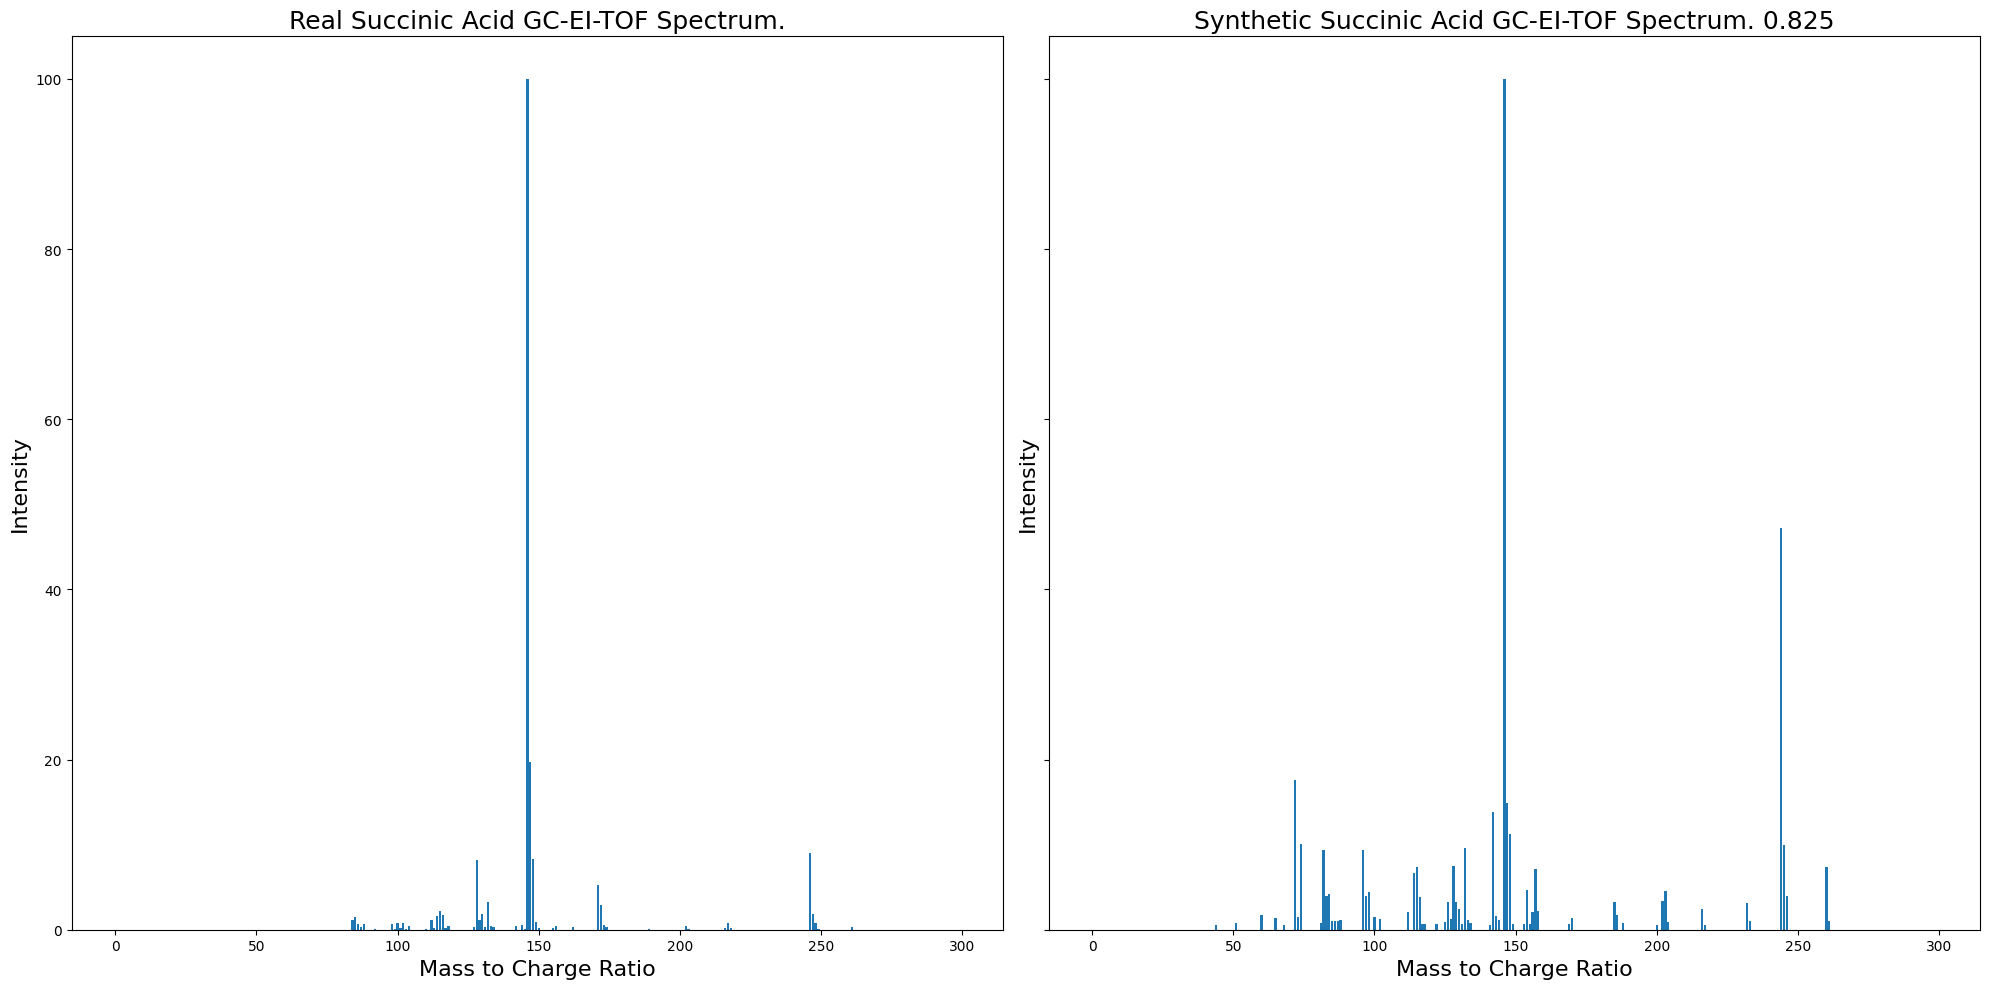

In [ ]:
instrument_names = ['Agilent GC 6890', 'CI-B', 'EI-B', 'GC 6890-5973N',
                    'GC-APCI-QTOF', 'GC-EI-Q', 'GC-EI-QQ', 'GC-EI-QqQMS',
                    'GC-EI-TOF', 'GC-MS', 'GC-MS-EI', 'single quadrupole']

test_instrument_labels = []
for encoding in test_instruments:
  name_idx = list(encoding).index(1)
  test_instrument_labels.append(instrument_names[name_idx])

test_chem_labels = []
for encoding in test_labels:
  name_idx = list(encoding).index(1)
  test_chem_labels.append(all_chemical_names[name_idx])

plot_results(test_spectra, test_output, test_chem_labels, test_instrument_labels)

In [ ]:
fake_spec = test_spectra[0]
max_val = max(fake_spec)
scaled_spec = (fake_spec/max_val)*100
for i, num in enumerate(scaled_spec):
  if num > .1:
    print(i+1, round(float(num), 4))

85 1.2012
86 1.2012
87 0.8008
88 0.4004
89 0.8008
90 0.1001
92 0.1001
93 0.3003
95 0.1001
99 0.7007
100 0.1001
101 0.9009
102 0.2002
103 0.7007
104 0.1001
105 0.4004
113 1.1011
114 0.1001
115 1.3013
116 2.3023
117 1.6016
118 0.2002
119 0.4004
128 0.3003
129 8.4084
130 1.2012
131 2.2022
132 0.4004
133 3.9039
134 0.5005
135 0.4004
143 0.6006
145 0.7007
146 0.1001
147 100.0
148 15.7157
149 8.7087
150 0.9009
151 0.2002
156 0.2002
157 0.5005
163 0.2002
172 4.5045
173 2.3023
174 0.4004
175 0.3003
190 0.1001
203 0.3003
217 0.2002
218 0.6006
219 0.1001
247 7.6076
248 1.5015
249 0.7007
262 0.4004


In [ ]:
max_val = max(test_output[0])
scaled_spec = (test_output[0]/max_val)*100
for i, num in enumerate(scaled_spec):
  if num > .5:
    print(i+1, round(float(num), 4))

60 0.6617
61 1.7583
66 0.7624
72 1.026
73 21.8481
74 1.2062
75 12.1561
76 1.0326
77 1.7928
85 1.6475
86 2.2442
87 1.0707
88 0.5488
89 1.0076
99 0.6011
103 0.9377
113 1.3291
115 1.5228
116 2.9128
117 1.8816
129 10.0994
130 1.4999
131 2.2891
132 0.5151
133 3.9156
147 100.0
148 16.7559
149 9.4159
150 1.0143
172 7.151
173 3.8431
174 1.4822
175 0.5155
218 1.1087
247 14.5514
248 3.5296
249 1.5676


# Old stuff:
---

In [ ]:
chem_group_names = ['Glutaric Acid', 'Fumaric Acid', 'Malonic Acid', 'Succinic Acid', 'Benzoic Acid', 'Biphenyl']
x_train, train_labels, x_test, test_labels = create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', training_chems=chem_group_names, batch_size=1)
print(len(x_train))
# len(x_train[-1])

61


In [ ]:
chem_instrument_counts = {}
for batch, encodings in x_train:
  # print(len(encodings[:-12]))
  label = all_chemical_names[list(encodings[0][:-12]).index(1)]
  # if label == 'Succinic Acid':
  #   print(encodings[0][-12:])
  # print(len(encodings[0]))
  # break
  # 2 = 'EI-B', 8 = 'GC-EI-TOF'
  if label not in chem_instrument_counts.keys():
    chem_instrument_counts[label] = {}
  if list(encodings[0][-12:]).index(1) == 2:
    instrument = 'EI-B'
  elif list(encodings[0][-12:]).index(1) == 8:
    instrument = 'GC-EI-TOF'
  else:
    instrument = 'Other'

  if instrument not in chem_instrument_counts[label].keys():
    chem_instrument_counts[label][instrument] = 1
  else:
    chem_instrument_counts[label][instrument] += 1

chem_instrument_counts

{'Fumaric Acid': {'Other': 1, 'GC-EI-TOF': 6, 'EI-B': 2},
 'Glutaric Acid': {'Other': 1, 'GC-EI-TOF': 5, 'EI-B': 2},
 'Biphenyl': {'EI-B': 16, 'Other': 2, 'GC-EI-TOF': 2},
 'Malonic Acid': {'EI-B': 4, 'GC-EI-TOF': 5, 'Other': 2},
 'Benzoic Acid': {'EI-B': 6, 'GC-EI-TOF': 2, 'Other': 1},
 'Succinic Acid': {'Other': 1, 'EI-B': 3}}

In [ ]:
# get differences between each chemical and succinic acid to determine which chemicals to group it with
succinic_acid_chemical_similarities = {}
mse = nn.MSELoss()
for chem in all_chemical_names:
  if not chem == 'Succinic Acid':
    succinic_acid_chemical_similarities[chem] = mse(torch.Tensor(embeddings['Succinic Acid']),torch.Tensor(embeddings[chem]))

succinic_acid_chemical_similarities = dict(sorted(succinic_acid_chemical_similarities.items(), key=lambda item: item[1]))
list(succinic_acid_chemical_similarities.keys())[:6]